In [ ]:
import os
os.environ["OPENAI_API_KEY"] = ""
import openai
openai.api_key = os.getenv("OPENAI_API_KEY")

In [ ]:
pip install tree-of-thoughts-llm

In [ ]:
!git clone https://github.com/princeton-nlp/tree-of-thought-llm
%cd tree-of-thought-llm

!pip install -r requirements.txt
!pip install -e .  # install 'tot' package



fatal: destination path 'tree-of-thought-llm' already exists and is not an empty directory.
/content/tree-of-thought-llm
Obtaining file:///content/tree-of-thought-llm
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for tree-of-thoughts-llm (pyproject.toml) ... done
  Created wheel for tree-of-thoughts-llm: filename=tree_of_thoughts_llm-0.1.0-0.editable-py3-none-any.whl size=4923 sha256=d8da236bc16e235c50ebb55a5d64b5841c22f8cd638fb620436c7484791acb46
  Stored in directory: /tmp/pip-ephem-wheel-cache-98wbcv1q/wheels/6e/5c/a3/642a16a17d96508a147b3b63dcc842172e57d643ee7d17f30b
Successfully built tree-of-thoughts-llm


In [ ]:
!pip install -e .

Obtaining file:///content/tree-of-thought-llm/scripts/crosswords
ERROR: file:///content/tree-of-thought-llm/scripts/crosswords does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [ ]:
%cd /content/tree-of-thought-llm


/content/tree-of-thought-llm


In [ ]:
!pip install -e .


Obtaining file:///content/tree-of-thought-llm
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for tree-of-thoughts-llm (pyproject.toml) ... done
  Created wheel for tree-of-thoughts-llm: filename=tree_of_thoughts_llm-0.1.0-0.editable-py3-none-any.whl size=4923 sha256=50d1931a24ce0652d6e3b6bc00f670a781c739c423558568d04f420c34af4e2f
  Stored in directory: /tmp/pip-ephem-wheel-cache-cgze26fu/wheels/6e/5c/a3/642a16a17d96508a147b3b63dcc842172e57d643ee7d17f30b
Successfully built tree-of-thoughts-llm
  Attempting uninstall: tree-of-thoughts-llm
    Found existing installation: tree-of-thoughts-llm 0.1.0
    Uninstalling tree-of-thoughts-llm-0.1.0:
      Successfully uninstalled tree-of-thoughts-llm-0.1.0


In [ ]:
%cd /content/tree-of-thought-llm/src/

# Add the current directory to Python path
import sys
sys.path.append('.')

# Now try your imports
import argparse
from tot.methods.bfs import solve
from tot.tasks.text import TextTask

/content/tree-of-thought-llm/src


# Mini Crossword


# TOT version

In [ ]:
%cd /content/tree-of-thought-llm/scripts/crosswords/
!python search_crosswords-dfs.ipynb
import argparse

from tot.tasks.text import TextTask
from tot.tasks.crosswords import MiniCrosswordsTask
#from tree_of_thought_llm.scripts.search_crosswords_dfs import dfs
args = argparse.Namespace(backend='gpt-4', temperature=0.7, task='crosswords', naive_run=False, prompt_sample=None, method_generate='propose', method_evaluate='value', method_select='greedy', n_generate_sample=1, n_evaluate_sample=3, n_select_sample=5)
task = MiniCrosswordsTask()
ys, infos = dfs(args, task, 10)
dfs(env, actions, infos, time_limit, prune, max_per_state)
print(ys[0])



/content/tree-of-thought-llm/scripts/crosswords
Traceback (most recent call last):
  File "/content/tree-of-thought-llm/scripts/crosswords/search_crosswords-dfs.ipynb", line 13, in <module>
    "execution_count": null,
NameError: name 'null' is not defined


ModuleNotFoundError: No module named 'tot'

In [ ]:

%cd ..
#TOT version
import json
from tot.prompts.crosswords import propose_prompt, value_prompt
from tot.models import gpt
from tot.tasks.crosswords import MiniCrosswordsEnv

env = MiniCrosswordsEnv()


def prompt_wrap(obs):
    return propose_prompt.format(input=obs)

print(prompt_wrap(env.reset(0)))
# print('---------')
# print(prompt_wrap(env.step('h2. value')[0]))


import re
import copy
from tot.models import gpt

def parse_line(input_str):
    # regular expression pattern to match the input string format
    pattern = r'^([hv][1-5])\. ([a-zA-Z]{5,5}) \((certain|high|medium|low)\).*$'

    # use regex to extract the parts of the input string
    match = re.match(pattern, input_str)

    if match:
        # extract the matched groups
        parts = [match.group(1), match.group(2), match.group(3)]
        return parts
    else:
        return None

confidence_to_value = {'certain': 1, 'high': 0.5, 'medium': 0.2, 'low': 0.1}  # TODO: ad hoc

def parse_response(response):
    # split the response into lines
    lines = response.split('\n')

    # parse each line
    parsed_lines = [parse_line(line) for line in lines]

    # filter out the lines that didn't match the format
    parsed_lines = [(line[0].lower() + '. ' + line[1].lower(), confidence_to_value.get(line[2], 0)) for line in parsed_lines if line is not None]

    return parsed_lines if len(parsed_lines) >= 1 else None


def get_candidates_to_scores(env):
    obs = env.render()
    if obs in env.cache:
        print('cache hit')
        return env.cache[obs]
    print('call gpt')
    responses = gpt(prompt_wrap(obs), model='gpt-4', n=8)
    candidates_to_scores = {}
    for response in responses:
        parsed_response = parse_response(response)
        if parsed_response:
            for candidate, score in parsed_response:
                candidates_to_scores[candidate] = candidates_to_scores.get(candidate, 0) + score
        # choose candiate with highest score
    # print(sorted(candidates_to_scores.items(), key=lambda x: x[1], reverse=True))
    env.cache[obs] = candidates_to_scores
    return candidates_to_scores

def propose_score(env, idx):
    obs = env.reset(idx)
    done = False
    infos = []
    while not done:
        responses = gpt(prompt_wrap(obs), model='gpt-4', n=5)
        candidates_to_scores = {}
        for response in responses:
            parsed_response = parse_response(response)
            if parsed_response:
                for candidate, score in parsed_response:
                    candidates_to_scores[candidate] = candidates_to_scores.get(candidate, 0) + score
        # choose candiate with highest score
        print(sorted(candidates_to_scores.items(), key=lambda x: x[1], reverse=True))
        if len(candidates_to_scores) == 0:
            break
        candidates =  sorted(candidates_to_scores, key=candidates_to_scores.get, reverse=True)
        for candidate in candidates:
            env_ = copy.deepcopy(env)
            env_.step(candidate)
            if not any(_ == 2 for _ in env_.status):
                break
        print(candidate)
        # candidate = input()
        obs, r, done, info = env.step(candidate)
        print(obs)
        print(env.steps, info)
        print('-------------------\n\n\n')
        infos.append(info)
    return infos

def dfs(env, actions, infos, time_limit, prune, max_per_state):
    # get candidate thoughts
    candidates_to_scores = get_candidates_to_scores(env)
    if len(candidates_to_scores) == 0: return 0, [], []
    print(sorted(candidates_to_scores.items(), key=lambda x: x[1], reverse=True))

    # back up current state
    board, status, steps = env.board.copy(), env.status.copy(), env.steps

    # try each candidate
    cnt_per_state = 0
    for action in sorted(candidates_to_scores, key=candidates_to_scores.get, reverse=True):
        obs, r, done, info = env.step(action)
        r = info['r_word']
        if len(infos) < time_limit and env.steps < 10 and not any(_ == 2 for _ in env.status):  # not violating any existing constraints
            cnt_per_state += 1
            if cnt_per_state > max_per_state: break
            count = env.prompt_status()
            actions.append(action)

            print(len(infos))
            print(actions)
            print(env.render_board())
            print(info)
            print(count)
            if infos:
                best = max(infos, key=lambda x: x['info']['r_word'])
                print('best', best)
            print('--------------')
            print()

            info = {'total_step': len(infos), 'env_step': env.steps, 'actions': actions.copy(), 'info': info, 'count': count}
            infos.append(info)
            if not prune or count['impossible'] < 1:  # only continue if the current status is possible
                dfs(env, actions, infos, time_limit, prune, max_per_state)
            actions.pop()
        env.reset(env.idx, board=board.copy(), status=status.copy(), steps=steps)


# dfs with pruning
infoss = []
for i in range(0, 100):
    env.reset(i)
    infos = []
    actions = []
    dfs(env, actions, infos, 100, prune=True, max_per_state=3)
    infoss.append(infos)
    with open('logs/crosswords/infoss_dfs_prune.json', 'w') as fout:
        json.dump(infoss, fout)


# # dfs without pruning
# infoss = []
# for i in range(0, 100, 5):
#     env.reset(i)
#     infos = []
#     actions = []
#     dfs(env, actions, infos, 100, prune=False, max_per_state=3)
#     infoss.append(infos)
#     with open('logs/crosswords/infoss_dfs_no_prune.json', 'w') as fout:
#         json.dump(infoss, fout)


/content/tree-of-thought-llm/scripts
Let's play a 5 x 5 mini crossword, where each word should have exactly 5 letters.

Current Board:
_____
_____
_____
_____
_____

Unfilled:
h1. An agendum; something to be done: _____
h2. An engine: _____
h3. Pretentious; flowery: _____
h4. A salon; a hall: _____
h5. To mock; to sneer: _____
v1. To heap: _____
v2. An Indian antelope: _____
v3. To intend; to plan; to devise; a nettle; to guess: _____
v4. A nozzle: _____
v5. Desiccator; more dry: _____

Filled:

Changed:


Given the current status, list all possible answers for unfilled or changed words, and your confidence levels (certain/high/medium/low), using the format "h1. apple (medium)". Use "certain" cautiously and only when you are 100% sure this is the correct word. You can list more then one possible answer for each word.

call gpt
[('h2. motor', 2.0), ('h4. salon', 1.5), ('v5. drier', 1.5), ('v4. spout', 1.2), ('h5. scorn', 1.0), ('h1. tasks', 1), ('h3. grand', 0.9), ('h5. scoff', 0.5), ('

INFO:backoff:Backing off completions_with_backoff(...) for 0.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2556, Requested 8199. Please try again in 4.53s. Visit https://platform.openai.com/account/rate-limits to learn more.)


1
['h2. motor', 'h1. tasks']
Current Board:
TASKS
MOTOR
_____
_____
_____

{'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}
{'sure': 3, 'maybe': 4, 'impossible': 0}
best {'total_step': 0, 'env_step': 1, 'actions': ['h2. motor'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 2.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2475, Requested 8199. Please try again in 4.044s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 1.1s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2130, Requested 8199. Please try again in 1.974s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 8.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1935, Requested 8199. Please try again in 804ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('v3. start', 0.5), ('h3. grand', 0.4), ('h4. salon', 0.2), ('h5. scorn', 0.2), ('h4. lodge', 0.2), ('h5. sneer', 0.2), ('v1. tower', 0.2), ('v5. sorer', 0.2), ('v1. tmese', 0.1), ('v4. kozak', 0.1), ('v2. aouda', 0.1), ('v3. stork', 0.1), ('v4. konas', 0.1)]
2
['h2. motor', 'h1. tasks', 'v3. start']
Current Board:
TASKS
MOTOR
__A__
__R__
__T__

{'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}
{'sure': 3, 'maybe': 4, 'impossible': 0}
best {'total_step': 0, 'env_step': 1, 'actions': ['h2. motor'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt
[('h3. grand', 2), ('h5. taunt', 2), ('h4. manor', 1), ('v4. knout', 0.1), ('v1. tmpan', 0.1), ('v4. kozmo', 0.1)]
3
['h2. motor', 'h1. tasks', 'v3. start', 'h3. grand']
Current Board:
TASKS
MOTOR
GRAND
__R__
__T__

{'r_letter': 0.24, 'r_word': 0.1, 'r_game': False}
{'sure': 4, 'maybe': 0, 'impossible': 4}
best {'total_step': 0, 'env_step': 1, 'actions': ['h2

INFO:backoff:Backing off completions_with_backoff(...) for 0.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 7158, Requested 8199. Please try again in 32.141s. Visit https://platform.openai.com/account/rate-limits to learn more.)


8
['h2. motor', 'v1. amass']
Current Board:
A____
MOTOR
A____
S____
S____

{'r_letter': 0.36, 'r_word': 0.2, 'r_game': False}
{'sure': 2, 'maybe': 0, 'impossible': 0}
best {'total_step': 0, 'env_step': 1, 'actions': ['h2. motor'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 7060, Requested 8199. Please try again in 31.554s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 3.8s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 7040, Requested 8199. Please try again in 31.434s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 1.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 6385, Requested 8199. Please try again in 27.504s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO

[('h4. salon', 6.5), ('v5. drier', 5.7), ('h5. scoff', 4.1), ('h3. artsy', 1.4), ('v3. think', 1.2999999999999998), ('h1. acted', 0.2)]
9
['h2. motor', 'v1. amass', 'h4. salon']
Current Board:
A____
MOTOR
A____
SALON
S____

{'r_letter': 0.44, 'r_word': 0.2, 'r_game': False}
{'sure': 3, 'maybe': 4, 'impossible': 0}
best {'total_step': 8, 'env_step': 2, 'actions': ['h2. motor', 'v1. amass'], 'info': {'r_letter': 0.36, 'r_word': 0.2, 'r_game': False}, 'count': {'sure': 2, 'maybe': 0, 'impossible': 0}}
--------------

call gpt
[('v5. drier', 6.0), ('v4. spout', 5.4), ('h5. scorn', 3.2), ('h5. scoff', 2.7), ('v2. cobra', 2.5), ('h3. artsy', 2.4000000000000004), ('v3. steel', 1.4), ('v3. total', 1.2), ('v2. chiru', 0.30000000000000004), ('v2. korha', 0.2), ('v2. chowa', 0.1), ('v2. koala', 0.1), ('v5. dryer', 0.1)]
10
['h2. motor', 'v1. amass', 'h4. salon', 'h5. scorn']
Current Board:
A____
MOTOR
A____
SALON
SCORN

{'r_letter': 0.44, 'r_word': 0.2, 'r_game': False}
{'sure': 4, 'maybe': 0, 'i

INFO:backoff:Backing off completions_with_backoff(...) for 1.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 6241, Requested 8199. Please try again in 26.64s. Visit https://platform.openai.com/account/rate-limits to learn more.)


13
['h2. motor', 'v1. amass', 'v5. drier']
Current Board:
A___D
MOTOR
A___I
S___E
S___R

{'r_letter': 0.48, 'r_word': 0.2, 'r_game': False}
{'sure': 4, 'maybe': 3, 'impossible': 0}
best {'total_step': 12, 'env_step': 4, 'actions': ['h2. motor', 'v1. amass', 'h4. salon', 'h3. artsy'], 'info': {'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 0, 'impossible': 2}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 6061, Requested 8199. Please try again in 25.56s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 1.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 5833, Requested 8199. Please try again in 24.192s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 7.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 5543, Requested 8199. Please try again in 22.452s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:

[('h1. ahead', 6.5), ('h4. salon', 5.4), ('v3. think', 3.1000000000000005), ('h5. scorn', 3.1), ('h3. artsy', 2.2), ('h5. sneer', 1), ('v4. nozzl', 0.30000000000000004), ('v4. spout', 0.2), ('h1. avoid', 0.2), ('h4. salve', 0.1), ('v4. nozzy', 0.1), ('v3. straw', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 1.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2684, Requested 8199. Please try again in 5.298s. Visit https://platform.openai.com/account/rate-limits to learn more.)


14
['h2. motor', 'v1. amass', 'v5. drier', 'h1. ahead']
Current Board:
AHEAD
MOTOR
A___I
S___E
S___R

{'r_letter': 0.52, 'r_word': 0.2, 'r_game': False}
{'sure': 5, 'maybe': 5, 'impossible': 0}
best {'total_step': 12, 'env_step': 4, 'actions': ['h2. motor', 'v1. amass', 'h4. salon', 'h3. artsy'], 'info': {'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 0, 'impossible': 2}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2501, Requested 8199. Please try again in 4.2s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 3.8s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2241, Requested 8199. Please try again in 2.64s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h5. sneer', 1.4), ('h3. artsy', 1.2), ('h4. salon', 1.1), ('h5. scorn', 1), ('h4. suite', 0.8999999999999999), ('v4. aorta', 0.5), ('h5. scoff', 0.5), ('h3. artie', 0.4), ('v2. horal', 0.4), ('v3. ether', 0.4), ('v3. enter', 0.2), ('h4. sable', 0.1), ('v3. etnas', 0.1), ('v2. horas', 0.1), ('v3. ettle', 0.1), ('v4. anode', 0.1), ('v2. hoper', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 0.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3145, Requested 8199. Please try again in 8.063s. Visit https://platform.openai.com/account/rate-limits to learn more.)


15
['h2. motor', 'v1. amass', 'v5. drier', 'h1. ahead', 'h5. sneer']
Current Board:
AHEAD
MOTOR
A___I
S___E
SNEER

{'r_letter': 0.6, 'r_word': 0.2, 'r_game': False}
{'sure': 5, 'maybe': 5, 'impossible': 0}
best {'total_step': 12, 'env_step': 4, 'actions': ['h2. motor', 'v1. amass', 'h4. salon', 'h3. artsy'], 'info': {'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 0, 'impossible': 2}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3068, Requested 8199. Please try again in 7.602s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 2.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2782, Requested 8199. Please try again in 5.886s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 6.9s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2437, Requested 8199. Please try again in 3.816s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h4. salon', 2.1), ('h3. artsy', 2), ('v3. ether', 1.2), ('h4. scene', 1.0), ('h3. artie', 0.6), ('v2. horns', 0.5), ('v4. arose', 0.4), ('v2. hosen', 0.30000000000000004), ('v2. horin', 0.30000000000000004), ('h4. salve', 0.2), ('v4. anode', 0.2), ('h4. space', 0.2), ('v3. etude', 0.1), ('v3. ettle', 0.1), ('v4. adore', 0.1), ('v3. etile', 0.1), ('v4. apone', 0.1), ('v4. aorte', 0.1), ('v2. hogon', 0.1), ('v4. aonee', 0.1)]
16
['h2. motor', 'v1. amass', 'v5. drier', 'h1. ahead', 'h5. sneer', 'h4. scene']
Current Board:
AHEAD
MOTOR
A___I
SCENE
SNEER

{'r_letter': 0.6, 'r_word': 0.2, 'r_game': False}
{'sure': 6, 'maybe': 1, 'impossible': 3}
best {'total_step': 12, 'env_step': 4, 'actions': ['h2. motor', 'v1. amass', 'h4. salon', 'h3. artsy'], 'info': {'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 0, 'impossible': 2}}
--------------

17
['h2. motor', 'v1. amass', 'v5. drier', 'h1. ahead', 'h5. sneer', 'v2. hosen']
Current Board:
AHEAD
MOTOR
AS__I
SE__E

INFO:backoff:Backing off completions_with_backoff(...) for 0.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3463, Requested 8199. Please try again in 9.972s. Visit https://platform.openai.com/account/rate-limits to learn more.)


18
['h2. motor', 'v1. amass', 'v5. drier', 'h1. ahead', 'h5. sneer', 'v2. horin']
Current Board:
AHEAD
MOTOR
AR__I
SI__E
SNEER

{'r_letter': 0.64, 'r_word': 0.2, 'r_game': False}
{'sure': 7, 'maybe': 3, 'impossible': 0}
best {'total_step': 12, 'env_step': 4, 'actions': ['h2. motor', 'v1. amass', 'h4. salon', 'h3. artsy'], 'info': {'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 0, 'impossible': 2}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3382, Requested 8199. Please try again in 9.486s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 3.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3260, Requested 8199. Please try again in 8.754s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 2.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2629, Requested 8199. Please try again in 4.968s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:ba

[('h3. artsy', 3.0), ('v3. meant', 1.9), ('h4. salon', 1.7999999999999998), ('v4. spout', 1.7), ('v4. adore', 0.6000000000000001), ('h3. artyi', 0.4), ('v3. ettle', 0.2), ('v3. etude', 0.2), ('h4. sieve', 0.2), ('h4. sitie', 0.1), ('v4. angle', 0.1), ('v3. estee', 0.1), ('h4. siege', 0.1), ('v3. etrie', 0.1)]
19
['h2. motor', 'v1. amass', 'v5. drier', 'h1. ahead', 'h5. sneer', 'v2. horin', 'h3. artyi']
Current Board:
AHEAD
MOTOR
ARTYI
SI__E
SNEER

{'r_letter': 0.68, 'r_word': 0.2, 'r_game': False}
{'sure': 8, 'maybe': 0, 'impossible': 2}
best {'total_step': 12, 'env_step': 4, 'actions': ['h2. motor', 'v1. amass', 'h4. salon', 'h3. artsy'], 'info': {'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 0, 'impossible': 2}}
--------------

20
['h2. motor', 'v1. amass', 'v5. drier', 'h1. ahead', 'h5. sneer', 'v2. horin', 'v3. ettle']
Current Board:
AHEAD
MOTOR
ART_I
SIL_E
SNEER

{'r_letter': 0.72, 'r_word': 0.3, 'r_game': False}
{'sure': 7, 'maybe': 2, 'impossibl

INFO:backoff:Backing off completions_with_backoff(...) for 0.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 6735, Requested 8199. Please try again in 29.604s. Visit https://platform.openai.com/account/rate-limits to learn more.)


24
['h2. motor', 'v1. amass', 'v5. drier', 'h5. sneer']
Current Board:
A___D
MOTOR
A___I
S___E
SNEER

{'r_letter': 0.56, 'r_word': 0.2, 'r_game': False}
{'sure': 4, 'maybe': 6, 'impossible': 0}
best {'total_step': 12, 'env_step': 4, 'actions': ['h2. motor', 'v1. amass', 'h4. salon', 'h3. artsy'], 'info': {'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 0, 'impossible': 2}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 6633, Requested 8199. Please try again in 28.992s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 2.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 6534, Requested 8199. Please try again in 28.398s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 1.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 6132, Requested 8199. Please try again in 25.986s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO

[('h1. avoid', 5.5), ('h4. salon', 3.5), ('h3. artsy', 3.4), ('h1. ahead', 1.5), ('v3. stare', 1.0), ('v4. spore', 1.0), ('h4. salve', 0.8), ('v3. stage', 0.5), ('v2. oryxn', 0.4), ('v4. spoke', 0.2), ('v3. sting', 0.2), ('v3. stile', 0.2), ('v2. orlon', 0.1), ('v2. oryon', 0.1), ('h3. artyi', 0.1), ('v2. oryan', 0.1), ('v4. dozer', 0.1), ('v2. orion', 0.1)]
25
['h2. motor', 'v1. amass', 'v5. drier', 'h5. sneer', 'h1. avoid']
Current Board:
AVOID
MOTOR
A___I
S___E
SNEER

{'r_letter': 0.56, 'r_word': 0.2, 'r_game': False}
{'sure': 5, 'maybe': 5, 'impossible': 0}
best {'total_step': 12, 'env_step': 4, 'actions': ['h2. motor', 'v1. amass', 'h4. salon', 'h3. artsy'], 'info': {'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 0, 'impossible': 2}}
--------------

call gpt
[('h4. suite', 1.3), ('v3. often', 0.9), ('v4. inlet', 0.5), ('h3. artie', 0.4), ('v4. ionic', 0.30000000000000004), ('v4. iones', 0.30000000000000004), ('h4. scene', 0.2), ('h3. artic', 0.2), 

INFO:backoff:Backing off completions_with_backoff(...) for 0.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 6587, Requested 8199. Please try again in 28.716s. Visit https://platform.openai.com/account/rate-limits to learn more.)


38
['h2. motor', 'v1. amass', 'h5. scoff']
Current Board:
A____
MOTOR
A____
S____
SCOFF

{'r_letter': 0.36, 'r_word': 0.2, 'r_game': False}
{'sure': 3, 'maybe': 4, 'impossible': 0}
best {'total_step': 12, 'env_step': 4, 'actions': ['h2. motor', 'v1. amass', 'h4. salon', 'h3. artsy'], 'info': {'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 0, 'impossible': 2}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 6465, Requested 8199. Please try again in 27.984s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 1.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 6240, Requested 8199. Please try again in 26.634s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 1.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 6016, Requested 8199. Please try again in 25.29s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:

[('h4. salon', 8), ('v5. drier', 5.9), ('v4. spout', 3.6000000000000005), ('h3. artsy', 3.5000000000000004), ('v3. sting', 2.0), ('h1. acted', 1), ('v2. oryxc', 0.30000000000000004), ('v2. orbic', 0.2), ('v3. stowo', 0.1), ('v4. spoof', 0.1), ('v3. stopo', 0.1)]
39
['h2. motor', 'v1. amass', 'h5. scoff', 'h4. salon']
Current Board:
A____
MOTOR
A____
SALON
SCOFF

{'r_letter': 0.44, 'r_word': 0.2, 'r_game': False}
{'sure': 4, 'maybe': 0, 'impossible': 4}
best {'total_step': 12, 'env_step': 4, 'actions': ['h2. motor', 'v1. amass', 'h4. salon', 'h3. artsy'], 'info': {'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 0, 'impossible': 2}}
--------------

40
['h2. motor', 'v1. amass', 'h5. scoff', 'h3. artsy']
Current Board:
A____
MOTOR
ARTSY
S____
SCOFF

{'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}
{'sure': 4, 'maybe': 0, 'impossible': 4}
best {'total_step': 12, 'env_step': 4, 'actions': ['h2. motor', 'v1. amass', 'h4. salon', 'h3. artsy'], 'info': {'r_let

INFO:backoff:Backing off completions_with_backoff(...) for 0.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2282, Requested 8199. Please try again in 2.886s. Visit https://platform.openai.com/account/rate-limits to learn more.)


68
['h2. motor', 'v5. drier', 'h5. sneer']
Current Board:
____D
MOTOR
____I
____E
SNEER

{'r_letter': 0.44, 'r_word': 0.1, 'r_game': False}
{'sure': 4, 'maybe': 3, 'impossible': 0}
best {'total_step': 12, 'env_step': 4, 'actions': ['h2. motor', 'v1. amass', 'h4. salon', 'h3. artsy'], 'info': {'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 0, 'impossible': 2}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 2.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2164, Requested 8199. Please try again in 2.178s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 1.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1819, Requested 8199. Please try again in 108ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h1. deeds', 8), ('v1. amass', 6), ('h4. salon', 2.2), ('h3. grand', 1.7), ('h4. lobby', 1), ('v4. dozer', 0.5), ('v3. stele', 0.30000000000000004), ('h4. lobbe', 0.2), ('v1. ammas', 0.2), ('v3. stare', 0.2), ('v2. oryxn', 0.2), ('h4. lodge', 0.2), ('v2. orlon', 0.2), ('v3. thebe', 0.1), ('v2. ooral', 0.1), ('h4. salve', 0.1), ('v2. chink', 0.1), ('v4. nozze', 0.1)]
69
['h2. motor', 'v5. drier', 'h5. sneer', 'v1. amass']
Current Board:
A___D
MOTOR
A___I
S___E
SNEER

{'r_letter': 0.56, 'r_word': 0.2, 'r_game': False}
{'sure': 4, 'maybe': 6, 'impossible': 0}
best {'total_step': 12, 'env_step': 4, 'actions': ['h2. motor', 'v1. amass', 'h4. salon', 'h3. artsy'], 'info': {'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 0, 'impossible': 2}}
--------------

cache hit
[('h1. avoid', 5.5), ('h4. salon', 3.5), ('h3. artsy', 3.4), ('h1. ahead', 1.5), ('v3. stare', 1.0), ('v4. spore', 1.0), ('h4. salve', 0.8), ('v3. stage', 0.5), ('v2. oryxn', 0.4), ('v4. spoke', 

INFO:backoff:Backing off completions_with_backoff(...) for 0.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4206, Requested 8199. Please try again in 14.43s. Visit https://platform.openai.com/account/rate-limits to learn more.)


84
['h2. motor', 'v5. drier', 'h4. lodge']
Current Board:
____D
MOTOR
____I
LODGE
____R

{'r_letter': 0.32, 'r_word': 0.1, 'r_game': False}
{'sure': 4, 'maybe': 3, 'impossible': 0}
best {'total_step': 12, 'env_step': 4, 'actions': ['h2. motor', 'v1. amass', 'h4. salon', 'h3. artsy'], 'info': {'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 0, 'impossible': 2}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.8s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4109, Requested 8199. Please try again in 13.848s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 1.1s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3787, Requested 8199. Please try again in 11.916s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 6.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3581, Requested 8199. Please try again in 10.68s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:

[('h1. deeds', 8), ('h3. grand', 4.6000000000000005), ('h5. scorn', 2.3000000000000003), ('h5. sneer', 2), ('v3. tends', 2), ('v4. spout', 1.1), ('h5. scoff', 1), ('v1. amply', 1), ('v3. study', 1), ('h5. jeers', 1), ('v2. oribi', 1), ('v1. pilem', 0.30000000000000004), ('v2. obolo', 0.2), ('v1. ammol', 0.2), ('v3. inted', 0.2), ('v4. spoug', 0.2), ('v1. email', 0.2), ('v4. dogge', 0.1), ('v2. oryxo', 0.1), ('v4. ology', 0.1), ('v2. googo', 0.1), ('v3. pland', 0.1), ('v4. nozzg', 0.1), ('v2. chink', 0.1), ('v4. noggs', 0.1)]
85
['h2. motor', 'v5. drier', 'h4. lodge', 'h5. sneer']
Current Board:
____D
MOTOR
____I
LODGE
SNEER

{'r_letter': 0.44, 'r_word': 0.1, 'r_game': False}
{'sure': 4, 'maybe': 1, 'impossible': 3}
best {'total_step': 12, 'env_step': 4, 'actions': ['h2. motor', 'v1. amass', 'h4. salon', 'h3. artsy'], 'info': {'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 0, 'impossible': 2}}
--------------

86
['h2. motor', 'v5. drier', 'h4. lodge', 'v

INFO:backoff:Backing off completions_with_backoff(...) for 0.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3485, Requested 8199. Please try again in 10.104s. Visit https://platform.openai.com/account/rate-limits to learn more.)


87
['h2. motor', 'v5. drier', 'h4. lodge', 'v3. study']
Current Board:
__S_D
MOTOR
__U_I
LODGE
__Y_R

{'r_letter': 0.32, 'r_word': 0.1, 'r_game': False}
{'sure': 5, 'maybe': 5, 'impossible': 0}
best {'total_step': 12, 'env_step': 4, 'actions': ['h2. motor', 'v1. amass', 'h4. salon', 'h3. artsy'], 'info': {'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 0, 'impossible': 2}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3439, Requested 8199. Please try again in 9.828s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3396, Requested 8199. Please try again in 9.57s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 6.9s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3283, Requested 8199. Please try again in 8.892s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:bac

[('h1. tasks', 4), ('h5. jeers', 1), ('v1. piles', 1), ('h1. taskd', 1), ('v4. spout', 0.5), ('h3. fluid', 0.30000000000000004), ('v1. ample', 0.2), ('h5. joker', 0.2), ('v1. ammol', 0.2), ('v4. doing', 0.2), ('v1. amply', 0.2), ('v1. piled', 0.2), ('h3. flufi', 0.1), ('h5. deris', 0.1), ('v2. cohos', 0.1), ('v4. doggs', 0.1), ('h3. fuggi', 0.1), ('v2. chows', 0.1), ('v4. nozzy', 0.1), ('h3. fusty', 0.1), ('h5. scorn', 0.1), ('h3. fughi', 0.1), ('v2. chink', 0.1), ('v4. spoug', 0.1), ('h5. deray', 0.1), ('v2. oozoo', 0.1), ('h5. sneer', 0.1), ('h3. frily', 0.1), ('h5. jerry', 0.1), ('v2. odoos', 0.1), ('v4. spogs', 0.1), ('h5. query', 0.1), ('v2. cobol', 0.1)]
88
['h2. motor', 'v5. drier', 'h4. lodge', 'v3. study', 'h1. taskd']
Current Board:
TASKD
MOTOR
__U_I
LODGE
__Y_R

{'r_letter': 0.32, 'r_word': 0.1, 'r_game': False}
{'sure': 4, 'maybe': 2, 'impossible': 4}
best {'total_step': 12, 'env_step': 4, 'actions': ['h2. motor', 'v1. amass', 'h4. salon', 'h3. artsy'], 'info': {'r_letter':

INFO:backoff:Backing off completions_with_backoff(...) for 0.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1933, Requested 8199. Please try again in 792ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


90
['h2. motor', 'v5. drier', 'h4. lodge', 'v3. study', 'v1. amply']
Current Board:
A_S_D
MOTOR
P_U_I
LODGE
Y_Y_R

{'r_letter': 0.36, 'r_word': 0.1, 'r_game': False}
{'sure': 4, 'maybe': 4, 'impossible': 2}
best {'total_step': 12, 'env_step': 4, 'actions': ['h2. motor', 'v1. amass', 'h4. salon', 'h3. artsy'], 'info': {'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 0, 'impossible': 2}}
--------------

91
['h4. salon']
Current Board:
_____
_____
_____
SALON
_____

{'r_letter': 0.12, 'r_word': 0.0, 'r_game': False}
{'sure': 1, 'maybe': 0, 'impossible': 0}
best {'total_step': 12, 'env_step': 4, 'actions': ['h2. motor', 'v1. amass', 'h4. salon', 'h3. artsy'], 'info': {'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 0, 'impossible': 2}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1821, Requested 8199. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h1. tasks', 8), ('h2. motor', 8), ('v4. spout', 8), ('v5. drier', 8), ('v1. piles', 7), ('h5. scoff', 6), ('v2. nilga', 3.1), ('v3. meant', 2), ('h5. scorn', 2), ('v3. plans', 1), ('h3. grand', 0.4), ('h3. fancy', 0.4), ('v2. chaal', 0.4), ('v3. email', 0.2), ('h3. flush', 0.2), ('h3. ornat', 0.1), ('v3. small', 0.1), ('v3. planl', 0.1), ('v3. umbel', 0.1), ('v3. steel', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 0.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3112, Requested 8199. Please try again in 7.866s. Visit https://platform.openai.com/account/rate-limits to learn more.)


92
['h4. salon', 'h1. tasks']
Current Board:
TASKS
_____
_____
SALON
_____

{'r_letter': 0.12, 'r_word': 0.0, 'r_game': False}
{'sure': 2, 'maybe': 5, 'impossible': 0}
best {'total_step': 12, 'env_step': 4, 'actions': ['h2. motor', 'v1. amass', 'h4. salon', 'h3. artsy'], 'info': {'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 0, 'impossible': 2}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3061, Requested 8199. Please try again in 7.56s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2956, Requested 8199. Please try again in 6.93s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 3.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2829, Requested 8199. Please try again in 6.168s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:back

[('h2. motor', 3), ('h5. scoff', 0.6000000000000001), ('v3. shall', 0.5), ('v4. knobs', 0.30000000000000004), ('h3. grand', 0.2), ('v1. tease', 0.2), ('v3. spell', 0.2), ('v1. topes', 0.1), ('v2. chiru', 0.1), ('v5. stale', 0.1), ('h3. ornat', 0.1), ('v2. angas', 0.1), ('v4. knock', 0.1), ('v5. seine', 0.1), ('v1. towns', 0.1), ('v2. angar', 0.1), ('v3. shale', 0.1), ('v5. soden', 0.1)]
93
['h4. salon', 'h1. tasks', 'h2. motor']
Current Board:
TASKS
MOTOR
_____
SALON
_____

{'r_letter': 0.32, 'r_word': 0.1, 'r_game': False}
{'sure': 3, 'maybe': 2, 'impossible': 3}
best {'total_step': 12, 'env_step': 4, 'actions': ['h2. motor', 'v1. amass', 'h4. salon', 'h3. artsy'], 'info': {'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 0, 'impossible': 2}}
--------------

94
['h4. salon', 'h1. tasks', 'h5. scoff']
Current Board:
TASKS
_____
_____
SALON
SCOFF

{'r_letter': 0.16, 'r_word': 0.0, 'r_game': False}
{'sure': 3, 'maybe': 2, 'impossible': 3}
best {'total_step'

INFO:backoff:Backing off completions_with_backoff(...) for 0.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2372, Requested 8199. Please try again in 3.426s. Visit https://platform.openai.com/account/rate-limits to learn more.)


95
['h4. salon', 'h1. tasks', 'v3. shall']
Current Board:
TASKS
__H__
__A__
SALON
__L__

{'r_letter': 0.12, 'r_word': 0.0, 'r_game': False}
{'sure': 3, 'maybe': 4, 'impossible': 0}
best {'total_step': 12, 'env_step': 4, 'actions': ['h2. motor', 'v1. amass', 'h4. salon', 'h3. artsy'], 'info': {'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 0, 'impossible': 2}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2250, Requested 8199. Please try again in 2.694s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 3.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1997, Requested 8199. Please try again in 1.176s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h2. march', 0.1), ('h3. grand', 0.1), ('h5. laugh', 0.1), ('v2. antak', 0.1)]
96
['h4. salon', 'h1. tasks', 'v3. shall', 'h3. grand']
Current Board:
TASKS
__H__
GRAND
SALON
__L__

{'r_letter': 0.16, 'r_word': 0.0, 'r_game': False}
{'sure': 4, 'maybe': 1, 'impossible': 3}
best {'total_step': 12, 'env_step': 4, 'actions': ['h2. motor', 'v1. amass', 'h4. salon', 'h3. artsy'], 'info': {'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 0, 'impossible': 2}}
--------------

97
['h4. salon', 'h1. tasks', 'v3. shall', 'v2. antak']
Current Board:
TASKS
_NH__
_TA__
SALON
_KL__

{'r_letter': 0.12, 'r_word': 0.0, 'r_game': False}
{'sure': 3, 'maybe': 6, 'impossible': 1}
best {'total_step': 12, 'env_step': 4, 'actions': ['h2. motor', 'v1. amass', 'h4. salon', 'h3. artsy'], 'info': {'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 0, 'impossible': 2}}
--------------



INFO:backoff:Backing off completions_with_backoff(...) for 0.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3474, Requested 8199. Please try again in 10.038s. Visit https://platform.openai.com/account/rate-limits to learn more.)


98
['h4. salon', 'h2. motor']
Current Board:
_____
MOTOR
_____
SALON
_____

{'r_letter': 0.32, 'r_word': 0.1, 'r_game': False}
{'sure': 3, 'maybe': 4, 'impossible': 0}
best {'total_step': 12, 'env_step': 4, 'actions': ['h2. motor', 'v1. amass', 'h4. salon', 'h3. artsy'], 'info': {'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 0, 'impossible': 2}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.1s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3361, Requested 8199. Please try again in 9.36s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 3.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3155, Requested 8199. Please try again in 8.124s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2580, Requested 8199. Please try again in 4.674s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:bac

[('h1. tasks', 8), ('v1. amass', 8), ('v5. drier', 7.2), ('h5. scoff', 3.6000000000000005), ('v4. spout', 3.6000000000000005), ('v3. total', 2.2), ('v2. cobra', 1.5999999999999999), ('h3. grand', 1.4), ('h5. scorn', 1.2), ('v3. steel', 0.4), ('v2. cobia', 0.30000000000000004), ('h3. ornat', 0.1), ('v4. obolo', 0.1)]
99
['h4. salon', 'h2. motor', 'h1. tasks']
Current Board:
TASKS
MOTOR
_____
SALON
_____

{'r_letter': 0.32, 'r_word': 0.1, 'r_game': False}
{'sure': 3, 'maybe': 2, 'impossible': 3}
best {'total_step': 12, 'env_step': 4, 'actions': ['h2. motor', 'v1. amass', 'h4. salon', 'h3. artsy'], 'info': {'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 0, 'impossible': 2}}
--------------



FileNotFoundError: [Errno 2] No such file or directory: 'logs/crosswords/infoss_dfs_prune.json'

In [ ]:

%cd ..
#TOT version
import json
from tot.prompts.crosswords import propose_prompt, value_prompt
from tot.models import gpt
from tot.tasks.crosswords import MiniCrosswordsEnv

env = MiniCrosswordsEnv()


def prompt_wrap(obs):
    return propose_prompt.format(input=obs)

print(prompt_wrap(env.reset(1)))
# print('---------')
# print(prompt_wrap(env.step('h2. value')[0]))


import re
import copy
from tot.models import gpt

def parse_line(input_str):
    # regular expression pattern to match the input string format
    pattern = r'^([hv][1-5])\. ([a-zA-Z]{5,5}) \((certain|high|medium|low)\).*$'

    # use regex to extract the parts of the input string
    match = re.match(pattern, input_str)

    if match:
        # extract the matched groups
        parts = [match.group(1), match.group(2), match.group(3)]
        return parts
    else:
        return None

confidence_to_value = {'certain': 1, 'high': 0.5, 'medium': 0.2, 'low': 0.1}  # TODO: ad hoc

def parse_response(response):
    # split the response into lines
    lines = response.split('\n')

    # parse each line
    parsed_lines = [parse_line(line) for line in lines]

    # filter out the lines that didn't match the format
    parsed_lines = [(line[0].lower() + '. ' + line[1].lower(), confidence_to_value.get(line[2], 0)) for line in parsed_lines if line is not None]

    return parsed_lines if len(parsed_lines) >= 1 else None


def get_candidates_to_scores(env):
    obs = env.render()
    if obs in env.cache:
        print('cache hit')
        return env.cache[obs]
    print('call gpt')
    responses = gpt(prompt_wrap(obs), model='gpt-4', n=8)
    candidates_to_scores = {}
    for response in responses:
        parsed_response = parse_response(response)
        if parsed_response:
            for candidate, score in parsed_response:
                candidates_to_scores[candidate] = candidates_to_scores.get(candidate, 0) + score
        # choose candiate with highest score
    # print(sorted(candidates_to_scores.items(), key=lambda x: x[1], reverse=True))
    env.cache[obs] = candidates_to_scores
    return candidates_to_scores

def propose_score(env, idx):
    obs = env.reset(idx)
    done = False
    infos = []
    while not done:
        responses = gpt(prompt_wrap(obs), model='gpt-4', n=5)
        candidates_to_scores = {}
        for response in responses:
            parsed_response = parse_response(response)
            if parsed_response:
                for candidate, score in parsed_response:
                    candidates_to_scores[candidate] = candidates_to_scores.get(candidate, 0) + score
        # choose candiate with highest score
        print(sorted(candidates_to_scores.items(), key=lambda x: x[1], reverse=True))
        if len(candidates_to_scores) == 0:
            break
        candidates =  sorted(candidates_to_scores, key=candidates_to_scores.get, reverse=True)
        for candidate in candidates:
            env_ = copy.deepcopy(env)
            env_.step(candidate)
            if not any(_ == 2 for _ in env_.status):
                break
        print(candidate)
        # candidate = input()
        obs, r, done, info = env.step(candidate)
        print(obs)
        print(env.steps, info)
        print('-------------------\n\n\n')
        infos.append(info)
    return infos

def dfs(env, actions, infos, time_limit, prune, max_per_state):
    # get candidate thoughts
    candidates_to_scores = get_candidates_to_scores(env)
    if len(candidates_to_scores) == 0: return 0, [], []
    print(sorted(candidates_to_scores.items(), key=lambda x: x[1], reverse=True))

    # back up current state
    board, status, steps = env.board.copy(), env.status.copy(), env.steps

    # try each candidate
    cnt_per_state = 0
    for action in sorted(candidates_to_scores, key=candidates_to_scores.get, reverse=True):
        obs, r, done, info = env.step(action)
        r = info['r_word']
        if len(infos) < time_limit and env.steps < 10 and not any(_ == 2 for _ in env.status):  # not violating any existing constraints
            cnt_per_state += 1
            if cnt_per_state > max_per_state: break
            count = env.prompt_status()
            actions.append(action)

            print(len(infos))
            print(actions)
            print(env.render_board())
            print(info)
            print(count)
            if infos:
                best = max(infos, key=lambda x: x['info']['r_word'])
                print('best', best)
            print('--------------')
            print()

            info = {'total_step': len(infos), 'env_step': env.steps, 'actions': actions.copy(), 'info': info, 'count': count}
            infos.append(info)
            if not prune or count['impossible'] < 1:  # only continue if the current status is possible
                dfs(env, actions, infos, time_limit, prune, max_per_state)
            actions.pop()
        env.reset(env.idx, board=board.copy(), status=status.copy(), steps=steps)


# dfs with pruning
infoss = []
for i in range(1, 30):
    env.reset(i)
    infos = []
    actions = []
    dfs(env, actions, infos, 5, prune=True, max_per_state=3)
    infoss.append(infos)
    # with open('logs/crosswords/infoss_dfs_prune.json', 'w') as fout:
    #     json.dump(infoss, fout)


# # dfs without pruning
# infoss = []
# for i in range(0, 100, 5):
#     env.reset(i)
#     infos = []
#     actions = []
#     dfs(env, actions, infos, 100, prune=False, max_per_state=3)
#     infoss.append(infos)
#     with open('logs/crosswords/infoss_dfs_no_prune.json', 'w') as fout:
#         json.dump(infoss, fout)


/
Let's play a 5 x 5 mini crossword, where each word should have exactly 5 letters.

Current Board:
_____
_____
_____
_____
_____

Unfilled:
h1. An agendum; something to be done: _____
h2. One who wires: _____
h3. To stir up; to remove from office: _____
h4. Ascended; awakened: _____
h5. To put into action: _____
v1. Mindful; conscious: _____
v2. A gadget: _____
v3. Notched or uneven, as if gnawed away (cognate with "erode"): _____
v4. Not ever: _____
v5. Drenched; drowned: _____

Filled:

Changed:


Given the current status, list all possible answers for unfilled or changed words, and your confidence levels (certain/high/medium/low), using the format "h1. apple (medium)". Use "certain" cautiously and only when you are 100% sure this is the correct word. You can list more then one possible answer for each word.

call gpt
[('v4. never', 5.0), ('v1. aware', 4.2), ('h4. arose', 3.0), ('h5. enact', 2.7), ('h2. wirer', 1.4), ('v3. erose', 1.4), ('h1. tasks', 1), ('v3. erode', 0.8), ('h3. ou

INFO:backoff:Backing off completions_with_backoff(...) for 0.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2211, Requested 8207. Please try again in 2.508s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2194, Requested 8207. Please try again in 2.406s. Visit https://platform.openai.com/account/rate-limits to learn more.)


1
['v4. never', 'v1. aware']
Current Board:
A__N_
W__E_
A__V_
R__E_
E__R_

{'r_letter': 0.4, 'r_word': 0.2, 'r_game': False}
{'sure': 5, 'maybe': 2, 'impossible': 0}
best {'total_step': 0, 'env_step': 1, 'actions': ['v4. never'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 2.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2088, Requested 8207. Please try again in 1.77s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h2. wirer', 7.5), ('h4. risen', 6), ('h3. avert', 4.5), ('h5. enact', 4.5), ('v3. eaten', 2.2), ('h5. enter', 2.2), ('v2. gizmo', 2), ('v3. erose', 1.2), ('v5. swamp', 1), ('h4. rouse', 0.5), ('v5. water', 0.4), ('v3. erode', 0.2), ('h1. aimed', 0.2), ('v2. dooda', 0.2), ('h1. annex', 0.2), ('h4. riser', 0.2), ('v5. soaks', 0.2), ('v3. edged', 0.1), ('v2. wiven', 0.1), ('h1. acton', 0.1), ('v5. soaky', 0.1), ('h3. activ', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 0.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2321, Requested 8207. Please try again in 3.168s. Visit https://platform.openai.com/account/rate-limits to learn more.)


2
['v4. never', 'v1. aware', 'h2. wirer']
Current Board:
A__N_
WIRER
A__V_
R__E_
E__R_

{'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}
{'sure': 5, 'maybe': 2, 'impossible': 0}
best {'total_step': 1, 'env_step': 2, 'actions': ['v4. never', 'v1. aware'], 'info': {'r_letter': 0.4, 'r_word': 0.2, 'r_game': False}, 'count': {'sure': 5, 'maybe': 2, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2202, Requested 8207. Please try again in 2.454s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 1.8s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2084, Requested 8207. Please try again in 1.746s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h4. risen', 4.5), ('h5. enter', 4.0), ('h5. enact', 1.7), ('h4. rouse', 1.5), ('v3. erose', 1.4), ('v5. drown', 0.8999999999999999), ('v2. gizmo', 0.6000000000000001), ('h3. activ', 0.30000000000000004), ('v3. erode', 0.30000000000000004), ('h3. agave', 0.30000000000000004), ('h3. alive', 0.2), ('h1. acton', 0.1), ('v5. rinse', 0.1), ('h3. aggro', 0.1), ('h1. anent', 0.1), ('v2. items', 0.1), ('h1. anend', 0.1), ('v2. trick', 0.1), ('v4. soaky', 0.1), ('v3. errod', 0.1), ('v5. river', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 0.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3153, Requested 8207. Please try again in 8.16s. Visit https://platform.openai.com/account/rate-limits to learn more.)


3
['v4. never', 'v1. aware', 'h2. wirer', 'h4. risen']
Current Board:
A__N_
WIRER
A__V_
RISEN
E__R_

{'r_letter': 0.64, 'r_word': 0.4, 'r_game': False}
{'sure': 6, 'maybe': 4, 'impossible': 0}
best {'total_step': 2, 'env_step': 3, 'actions': ['v4. never', 'v1. aware', 'h2. wirer'], 'info': {'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 5, 'maybe': 2, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3066, Requested 8207. Please try again in 7.638s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 3.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2954, Requested 8207. Please try again in 6.966s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 7.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2348, Requested 8207. Please try again in 3.33s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h5. enter', 3.5), ('v5. drown', 2.7), ('h5. enact', 1.2), ('v3. erose', 1), ('v3. erase', 0.8), ('v2. gizmo', 0.5), ('h3. agave', 0.4), ('h1. acton', 0.2), ('v5. drain', 0.2), ('h3. annoy', 0.2), ('h3. abuse', 0.1), ('v2. dizit', 0.1), ('v2. ivied', 0.1), ('v3. crust', 0.1), ('v2. dingi', 0.1), ('h1. adorn', 0.1), ('h5. error', 0.1), ('v2. whiri', 0.1), ('h3. alive', 0.1), ('v2. kitki', 0.1), ('v3. irreg', 0.1), ('v4. inund', 0.1), ('v2. kilim', 0.1), ('v5. drone', 0.1)]
4
['v4. never', 'v1. aware', 'h2. wirer', 'h4. risen', 'v3. erose']
Current Board:
A_EN_
WIRER
A_OV_
RISEN
E_ER_

{'r_letter': 0.76, 'r_word': 0.5, 'r_game': False}
{'sure': 5, 'maybe': 2, 'impossible': 3}
best {'total_step': 3, 'env_step': 4, 'actions': ['v4. never', 'v1. aware', 'h2. wirer', 'h4. risen'], 'info': {'r_letter': 0.64, 'r_word': 0.4, 'r_game': False}, 'count': {'sure': 6, 'maybe': 4, 'impossible': 0}}
--------------

call gpt
[('v3. elope', 3.5), ('h2. value', 3.0), ('h1. wizen', 1.3), ('v5. covet', 1

INFO:backoff:Backing off completions_with_backoff(...) for 0.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1931, Requested 8204. Please try again in 810ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


1
['v3. elope', 'h2. value']
Current Board:
__E__
VALUE
__O__
__P__
__E__

{'r_letter': 0.36, 'r_word': 0.2, 'r_game': False}
{'sure': 2, 'maybe': 0, 'impossible': 0}
best {'total_step': 0, 'env_step': 1, 'actions': ['v3. elope'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1797, Requested 8204. Please try again in 6ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('v5. yearn', 0.6000000000000001), ('v1. drove', 0.5), ('v2. abras', 0.5), ('h4. loper', 0.5), ('h1. wheat', 0.4), ('h4. galop', 0.4), ('h3. anaco', 0.30000000000000004), ('h1. wizen', 0.30000000000000004), ('v4. puffs', 0.2), ('h5. prime', 0.2), ('v1. dropt', 0.2), ('v5. eager', 0.2), ('v2. amass', 0.2), ('v4. smoky', 0.2), ('h5. perse', 0.2), ('v2. abrad', 0.2), ('h5. inane', 0.1), ('v4. usage', 0.1), ('v5. needs', 0.1), ('h4. leper', 0.1), ('h5. etern', 0.1), ('h1. deify', 0.1), ('h3. boafo', 0.1), ('h5. elide', 0.1), ('v1. divul', 0.1), ('v4. umfus', 0.1), ('v5. edger', 0.1), ('v1. defer', 0.1), ('v5. elate', 0.1), ('v1. diver', 0.1), ('v4. usure', 0.1), ('h3. boaid', 0.1), ('h5. endle', 0.1), ('v2. angle', 0.1), ('v4. usher', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 0.9s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3332, Requested 8204. Please try again in 9.216s. Visit https://platform.openai.com/account/rate-limits to learn more.)


2
['v3. elope', 'h2. value', 'v5. yearn']
Current Board:
__E_Y
VALUE
__O_A
__P_R
__E_N

{'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}
{'sure': 5, 'maybe': 2, 'impossible': 0}
best {'total_step': 1, 'env_step': 2, 'actions': ['v3. elope', 'h2. value'], 'info': {'r_letter': 0.36, 'r_word': 0.2, 'r_game': False}, 'count': {'sure': 2, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.9s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3165, Requested 8204. Please try again in 8.214s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3005, Requested 8204. Please try again in 7.254s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 7.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2920, Requested 8204. Please try again in 6.744s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h4. loper', 3.3), ('h1. parch', 2.5), ('v4. fumer', 0.6), ('h5. aeons', 0.4), ('h5. etern', 0.30000000000000004), ('v2. abras', 0.30000000000000004), ('v1. drove', 0.2), ('v2. amend', 0.2), ('h1. pithy', 0.2), ('v2. lapis', 0.2), ('v1. droop', 0.2), ('v2. amber', 0.2), ('h3. boaer', 0.2), ('v1. dropv', 0.2), ('h1. perry', 0.1), ('h3. boaha', 0.1), ('v2. abrax', 0.1), ('h3. boaas', 0.1), ('h3. boaia', 0.1), ('h5. aeonn', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 0.8s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2950, Requested 8204. Please try again in 6.924s. Visit https://platform.openai.com/account/rate-limits to learn more.)


3
['v3. elope', 'h2. value', 'v5. yearn', 'h4. loper']
Current Board:
__E_Y
VALUE
__O_A
LOPER
__E_N

{'r_letter': 0.64, 'r_word': 0.4, 'r_game': False}
{'sure': 6, 'maybe': 4, 'impossible': 0}
best {'total_step': 2, 'env_step': 3, 'actions': ['v3. elope', 'h2. value', 'v5. yearn'], 'info': {'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 5, 'maybe': 2, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2814, Requested 8204. Please try again in 6.108s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 3.9s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2593, Requested 8204. Please try again in 4.782s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 4.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1936, Requested 8204. Please try again in 840ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h1. parch', 2), ('v1. spill', 1), ('v4. fumer', 0.9), ('h5. reign', 0.6000000000000001), ('h3. boaia', 0.6), ('h5. aeons', 0.4), ('h1. pithy', 0.4), ('v1. drool', 0.4), ('v2. abode', 0.2), ('v1. drops', 0.2), ('v2. amoks', 0.2), ('v2. broad', 0.2), ('h5. green', 0.2), ('v1. pivol', 0.1), ('h3. boaha', 0.1), ('h5. seven', 0.1), ('v4. gruer', 0.1), ('v2. amoka', 0.1), ('v1. dwell', 0.1), ('v2. pumas', 0.1), ('v4. rudee', 0.1), ('h1. pelly', 0.1), ('v1. revel', 0.1), ('v2. abora', 0.1)]
4
['v3. elope', 'h2. value', 'v5. yearn', 'h4. loper', 'v4. fumer']
Current Board:
__EFY
VALUE
__OMA
LOPER
__ERN

{'r_letter': 0.76, 'r_word': 0.5, 'r_game': False}
{'sure': 5, 'maybe': 4, 'impossible': 1}
best {'total_step': 3, 'env_step': 4, 'actions': ['v3. elope', 'h2. value', 'v5. yearn', 'h4. loper'], 'info': {'r_letter': 0.64, 'r_word': 0.4, 'r_game': False}, 'count': {'sure': 6, 'maybe': 4, 'impossible': 0}}
--------------



In [ ]:

%cd ..
#TOT version
import json
from tot.prompts.crosswords import propose_prompt, value_prompt
from tot.models import gpt
from tot.tasks.crosswords import MiniCrosswordsEnv

env = MiniCrosswordsEnv()


def prompt_wrap(obs):
    return propose_prompt.format(input=obs)

print(prompt_wrap(env.reset(1)))
# print('---------')
# print(prompt_wrap(env.step('h2. value')[0]))


import re
import copy
from tot.models import gpt

def parse_line(input_str):
    # regular expression pattern to match the input string format
    pattern = r'^([hv][1-5])\. ([a-zA-Z]{5,5}) \((certain|high|medium|low)\).*$'

    # use regex to extract the parts of the input string
    match = re.match(pattern, input_str)

    if match:
        # extract the matched groups
        parts = [match.group(1), match.group(2), match.group(3)]
        return parts
    else:
        return None

confidence_to_value = {'certain': 1, 'high': 0.5, 'medium': 0.2, 'low': 0.1}  # TODO: ad hoc

def parse_response(response):
    # split the response into lines
    lines = response.split('\n')

    # parse each line
    parsed_lines = [parse_line(line) for line in lines]

    # filter out the lines that didn't match the format
    parsed_lines = [(line[0].lower() + '. ' + line[1].lower(), confidence_to_value.get(line[2], 0)) for line in parsed_lines if line is not None]

    return parsed_lines if len(parsed_lines) >= 1 else None


def get_candidates_to_scores(env):
    obs = env.render()
    if obs in env.cache:
        print('cache hit')
        return env.cache[obs]
    print('call gpt')
    responses = gpt(prompt_wrap(obs), model='gpt-4', n=8)
    candidates_to_scores = {}
    for response in responses:
        parsed_response = parse_response(response)
        if parsed_response:
            for candidate, score in parsed_response:
                candidates_to_scores[candidate] = candidates_to_scores.get(candidate, 0) + score
        # choose candiate with highest score
    # print(sorted(candidates_to_scores.items(), key=lambda x: x[1], reverse=True))
    env.cache[obs] = candidates_to_scores
    return candidates_to_scores

def propose_score(env, idx):
    obs = env.reset(idx)
    done = False
    infos = []
    while not done:
        responses = gpt(prompt_wrap(obs), model='gpt-4', n=5)
        candidates_to_scores = {}
        for response in responses:
            parsed_response = parse_response(response)
            if parsed_response:
                for candidate, score in parsed_response:
                    candidates_to_scores[candidate] = candidates_to_scores.get(candidate, 0) + score
        # choose candiate with highest score
        print(sorted(candidates_to_scores.items(), key=lambda x: x[1], reverse=True))
        if len(candidates_to_scores) == 0:
            break
        candidates =  sorted(candidates_to_scores, key=candidates_to_scores.get, reverse=True)
        for candidate in candidates:
            env_ = copy.deepcopy(env)
            env_.step(candidate)
            if not any(_ == 2 for _ in env_.status):
                break
        print(candidate)
        # candidate = input()
        obs, r, done, info = env.step(candidate)
        print(obs)
        print(env.steps, info)
        print('-------------------\n\n\n')
        infos.append(info)
    return infos

def dfs(env, actions, infos, time_limit, prune, max_per_state):
    # get candidate thoughts
    candidates_to_scores = get_candidates_to_scores(env)
    if len(candidates_to_scores) == 0: return 0, [], []
    print(sorted(candidates_to_scores.items(), key=lambda x: x[1], reverse=True))

    # back up current state
    board, status, steps = env.board.copy(), env.status.copy(), env.steps

    # try each candidate
    cnt_per_state = 0
    for action in sorted(candidates_to_scores, key=candidates_to_scores.get, reverse=True):
        obs, r, done, info = env.step(action)
        r = info['r_word']
        if len(infos) < time_limit and env.steps < 10 and not any(_ == 2 for _ in env.status):  # not violating any existing constraints
            cnt_per_state += 1
            if cnt_per_state > max_per_state: break
            count = env.prompt_status()
            actions.append(action)

            print(len(infos))
            print(actions)
            print(env.render_board())
            print(info)
            print(count)
            if infos:
                best = max(infos, key=lambda x: x['info']['r_word'])
                print('best', best)
            print('--------------')
            print()

            info = {'total_step': len(infos), 'env_step': env.steps, 'actions': actions.copy(), 'info': info, 'count': count}
            infos.append(info)
            if not prune or count['impossible'] < 1:  # only continue if the current status is possible
                dfs(env, actions, infos, time_limit, prune, max_per_state)
            actions.pop()
        env.reset(env.idx, board=board.copy(), status=status.copy(), steps=steps)


# dfs with pruning
infoss = []
for i in range(1, 30):
    env.reset(i)
    infos = []
    actions = []
    dfs(env, actions, infos, 10, prune=True, max_per_state=3)
    infoss.append(infos)


/
Let's play a 5 x 5 mini crossword, where each word should have exactly 5 letters.

Current Board:
_____
_____
_____
_____
_____

Unfilled:
h1. An agendum; something to be done: _____
h2. One who wires: _____
h3. To stir up; to remove from office: _____
h4. Ascended; awakened: _____
h5. To put into action: _____
v1. Mindful; conscious: _____
v2. A gadget: _____
v3. Notched or uneven, as if gnawed away (cognate with "erode"): _____
v4. Not ever: _____
v5. Drenched; drowned: _____

Filled:

Changed:


Given the current status, list all possible answers for unfilled or changed words, and your confidence levels (certain/high/medium/low), using the format "h1. apple (medium)". Use "certain" cautiously and only when you are 100% sure this is the correct word. You can list more then one possible answer for each word.

call gpt
[('h3. anion', 2.7), ('v5. owner', 2.7), ('v4. goose', 1.9), ('v3. ilium', 1.2999999999999998), ('v1. asset', 1.0999999999999999), ('h1. amigo', 1), ('h2. bless', 0.9)

INFO:backoff:Backing off completions_with_backoff(...) for 0.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2289, Requested 8198. Please try again in 2.922s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 1.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2275, Requested 8198. Please try again in 2.838s. Visit https://platform.openai.com/account/rate-limits to learn more.)


3
['h3. anion', 'v5. owner', 'h5. loner', 'v4. goose']
Current Board:
___GO
___OW
ANION
___SE
LONER

{'r_letter': 0.64, 'r_word': 0.4, 'r_game': False}
{'sure': 4, 'maybe': 6, 'impossible': 0}
best {'total_step': 2, 'env_step': 3, 'actions': ['h3. anion', 'v5. owner', 'h5. loner'], 'info': {'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 4, 'maybe': 3, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2040, Requested 8198. Please try again in 1.428s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 7.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1865, Requested 8198. Please try again in 378ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('v3. ilion', 5.9), ('h1. amigo', 4.5), ('h2. throw', 3.9000000000000004), ('v1. final', 3.1), ('h1. mango', 3), ('v2. intro', 1.1), ('h2. endow', 0.5), ('h4. fruse', 0.30000000000000004), ('v1. email', 0.2), ('v2. kinjo', 0.2), ('h4. sucse', 0.1), ('v2. kenko', 0.1), ('v2. mondo', 0.1)]
4
['h3. anion', 'v5. owner', 'h5. loner', 'v4. goose', 'v3. ilion']
Current Board:
__IGO
__LOW
ANION
__OSE
LONER

{'r_letter': 0.76, 'r_word': 0.5, 'r_game': False}
{'sure': 6, 'maybe': 3, 'impossible': 1}
best {'total_step': 3, 'env_step': 4, 'actions': ['h3. anion', 'v5. owner', 'h5. loner', 'v4. goose'], 'info': {'r_letter': 0.64, 'r_word': 0.4, 'r_game': False}, 'count': {'sure': 4, 'maybe': 6, 'impossible': 0}}
--------------



INFO:backoff:Backing off completions_with_backoff(...) for 0.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2927, Requested 8198. Please try again in 6.75s. Visit https://platform.openai.com/account/rate-limits to learn more.)


5
['h3. anion', 'v5. owner', 'h5. loner', 'v4. goose', 'h1. amigo']
Current Board:
AMIGO
___OW
ANION
___SE
LONER

{'r_letter': 0.76, 'r_word': 0.5, 'r_game': False}
{'sure': 8, 'maybe': 2, 'impossible': 0}
best {'total_step': 4, 'env_step': 5, 'actions': ['h3. anion', 'v5. owner', 'h5. loner', 'v4. goose', 'v3. ilion'], 'info': {'r_letter': 0.76, 'r_word': 0.5, 'r_game': False}, 'count': {'sure': 6, 'maybe': 3, 'impossible': 1}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.9s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2817, Requested 8198. Please try again in 6.09s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 2.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2492, Requested 8198. Please try again in 4.14s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 4.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2033, Requested 8198. Please try again in 1.386s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('v3. ilion', 4), ('h2. allow', 2), ('v1. avail', 2), ('h2. throw', 1), ('h2. below', 1), ('h4. fruse', 0.30000000000000004), ('v2. mondo', 0.2), ('v2. minno', 0.2), ('v1. ambul', 0.1), ('v2. manco', 0.1), ('v1. ataxl', 0.1), ('v2. monko', 0.1)]
6
['h3. anion', 'v5. owner', 'h5. loner', 'v4. goose', 'h1. amigo', 'v3. ilion']
Current Board:
AMIGO
__LOW
ANION
__OSE
LONER

{'r_letter': 0.84, 'r_word': 0.6, 'r_game': False}
{'sure': 8, 'maybe': 1, 'impossible': 1}
best {'total_step': 4, 'env_step': 5, 'actions': ['h3. anion', 'v5. owner', 'h5. loner', 'v4. goose', 'v3. ilion'], 'info': {'r_letter': 0.76, 'r_word': 0.5, 'r_game': False}, 'count': {'sure': 6, 'maybe': 3, 'impossible': 1}}
--------------

7
['h3. anion', 'v5. owner', 'h5. loner', 'v4. goose', 'h1. amigo', 'h2. allow']
Current Board:
AMIGO
ALLOW
ANION
___SE
LONER

{'r_letter': 0.8, 'r_word': 0.5, 'r_game': False}
{'sure': 5, 'maybe': 2, 'impossible': 3}
best {'total_step': 6, 'env_step': 6, 'actions': ['h3. anion', 'v5. owner

INFO:backoff:Backing off completions_with_backoff(...) for 0.9s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2830, Requested 8206. Please try again in 6.216s. Visit https://platform.openai.com/account/rate-limits to learn more.)


9
['h3. anion', 'v5. owner', 'h5. loner', 'v4. goose', 'h2. throw']
Current Board:
___GO
THROW
ANION
___SE
LONER

{'r_letter': 0.64, 'r_word': 0.4, 'r_game': False}
{'sure': 4, 'maybe': 3, 'impossible': 3}
best {'total_step': 6, 'env_step': 6, 'actions': ['h3. anion', 'v5. owner', 'h5. loner', 'v4. goose', 'h1. amigo', 'v3. ilion'], 'info': {'r_letter': 0.84, 'r_word': 0.6, 'r_game': False}, 'count': {'sure': 8, 'maybe': 1, 'impossible': 1}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2677, Requested 8206. Please try again in 5.298s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 2.8s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2437, Requested 8206. Please try again in 3.857s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 7.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1959, Requested 8206. Please try again in 990ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h2. retie', 4), ('v2. resit', 3), ('v1. arise', 1.2), ('h1. wizen', 0.8), ('v4. light', 0.7), ('h4. loper', 0.30000000000000004), ('h5. etern', 0.30000000000000004), ('v1. climb', 0.30000000000000004), ('h3. italy', 0.2), ('h5. peren', 0.2), ('v2. reset', 0.2), ('v5. covet', 0.2), ('h4. plods', 0.2), ('v5. plead', 0.2), ('h4. racer', 0.1)]
0
['h2. retie']
Current Board:
_____
RETIE
_____
_____
_____

{'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}
{'sure': 1, 'maybe': 0, 'impossible': 0}
--------------

call gpt
[('v1. arise', 4.1000000000000005), ('v2. resit', 2.4000000000000004), ('v5. eager', 2.1999999999999997), ('h1. wizen', 1.5999999999999999), ('v3. think', 1.2999999999999998), ('v4. ignit', 0.7), ('h4. racer', 0.6), ('h5. perdu', 0.30000000000000004), ('h3. italy', 0.2), ('v2. reset', 0.2), ('h5. etern', 0.2), ('h5. cease', 0.1), ('v4. ignis', 0.1), ('h4. loper', 0.1), ('h3. croat', 0.1), ('h5. peren', 0.1), ('v4. ilite', 0.1), ('h5. inane', 0.1), ('h4. trudg', 0.1), ('h3.

INFO:backoff:Backing off completions_with_backoff(...) for 0.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1796, Requested 8206. Please try again in 12ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


1
['h2. retie', 'v1. arise']
Current Board:
A____
RETIE
I____
S____
E____

{'r_letter': 0.36, 'r_word': 0.2, 'r_game': False}
{'sure': 2, 'maybe': 0, 'impossible': 0}
best {'total_step': 0, 'env_step': 1, 'actions': ['h2. retie'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt
[('h1. arise', 1), ('v2. resit', 1), ('v5. eager', 1), ('v2. reset', 0.5), ('v5. yearn', 0.5), ('h4. sieve', 0.2), ('v3. sting', 0.2), ('h1. adore', 0.1), ('h3. italy', 0.1), ('h5. etern', 0.1), ('v4. ignit', 0.1)]
2
['h2. retie', 'v1. arise', 'h1. arise']
Current Board:
ARISE
RETIE
I____
S____
E____

{'r_letter': 0.4, 'r_word': 0.2, 'r_game': False}
{'sure': 3, 'maybe': 3, 'impossible': 1}
best {'total_step': 1, 'env_step': 2, 'actions': ['h2. retie', 'v1. arise'], 'info': {'r_letter': 0.36, 'r_word': 0.2, 'r_game': False}, 'count': {'sure': 2, 'maybe': 0, 'impossible': 0}}
--------------



INFO:backoff:Backing off completions_with_backoff(...) for 0.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4171, Requested 8206. Please try again in 14.262s. Visit https://platform.openai.com/account/rate-limits to learn more.)


3
['h2. retie', 'v1. arise', 'v2. resit']
Current Board:
AR___
RETIE
IS___
SI___
ET___

{'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}
{'sure': 4, 'maybe': 3, 'impossible': 0}
best {'total_step': 1, 'env_step': 2, 'actions': ['h2. retie', 'v1. arise'], 'info': {'r_letter': 0.36, 'r_word': 0.2, 'r_game': False}, 'count': {'sure': 2, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4128, Requested 8206. Please try again in 14.004s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 3.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4063, Requested 8206. Please try again in 13.614s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 6.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3515, Requested 8206. Please try again in 10.326s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO

[('h3. istra', 4), ('h3. istri', 3.2), ('h4. sifts', 2.6), ('v5. yearn', 2.0), ('h5. etern', 1.9), ('v5. eager', 1.5), ('v3. think', 1), ('v4. light', 1), ('h1. ardor', 0.7), ('v4. ignit', 0.7), ('v3. sting', 0.6000000000000001), ('h4. sieve', 0.5), ('v3. trust', 0.2), ('v3. titie', 0.1), ('v4. ignis', 0.1), ('v3. tente', 0.1), ('v3. tinct', 0.1)]
4
['h2. retie', 'v1. arise', 'v2. resit', 'h3. istra']
Current Board:
AR___
RETIE
ISTRA
SI___
ET___

{'r_letter': 0.64, 'r_word': 0.4, 'r_game': False}
{'sure': 7, 'maybe': 3, 'impossible': 0}
best {'total_step': 3, 'env_step': 3, 'actions': ['h2. retie', 'v1. arise', 'v2. resit'], 'info': {'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 4, 'maybe': 3, 'impossible': 0}}
--------------

call gpt
[('v5. yearn', 3.5999999999999996), ('v4. firer', 1.6), ('h4. sifts', 1.5999999999999999), ('h4. sieve', 1.4), ('h5. etern', 1.3), ('h1. aridy', 1), ('v3. attar', 0.5), ('h1. arear', 0.4), ('h1. ardor', 0.30000000000000004), ('v3. 

INFO:backoff:Backing off completions_with_backoff(...) for 0.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4275, Requested 8206. Please try again in 14.886s. Visit https://platform.openai.com/account/rate-limits to learn more.)


8
['h2. retie', 'v1. arise', 'v2. resit', 'h3. istri']
Current Board:
AR___
RETIE
ISTRI
SI___
ET___

{'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}
{'sure': 6, 'maybe': 4, 'impossible': 0}
best {'total_step': 5, 'env_step': 5, 'actions': ['h2. retie', 'v1. arise', 'v2. resit', 'h3. istra', 'v5. yearn'], 'info': {'r_letter': 0.76, 'r_word': 0.5, 'r_game': False}, 'count': {'sure': 7, 'maybe': 2, 'impossible': 1}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4184, Requested 8206. Please try again in 14.34s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 2.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4074, Requested 8206. Please try again in 13.68s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 7.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3626, Requested 8206. Please try again in 10.992s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:b

[('v4. firer', 2.8000000000000003), ('h4. sieve', 2.2), ('v5. yearn', 2.2), ('h1. arise', 2), ('h5. etern', 1.8000000000000003), ('h4. sifts', 1.0), ('v3. attar', 0.30000000000000004), ('h1. arear', 0.2), ('v5. yeild', 0.2), ('v4. airer', 0.2), ('v3. attic', 0.2), ('v4. siren', 0.2), ('v3. bette', 0.1), ('v3. attin', 0.1), ('v5. yeirn', 0.1), ('h1. argue', 0.1), ('v5. reify', 0.1), ('h1. arent', 0.1), ('v3. stten', 0.1), ('h1. areic', 0.1), ('v3. ittle', 0.1), ('v5. yeins', 0.1)]
9
['h2. retie', 'v1. arise', 'v2. resit', 'h3. istri', 'v4. firer']
Current Board:
AR_F_
RETIE
ISTRI
SI_E_
ET_R_

{'r_letter': 0.72, 'r_word': 0.4, 'r_game': False}
{'sure': 7, 'maybe': 2, 'impossible': 1}
best {'total_step': 5, 'env_step': 5, 'actions': ['h2. retie', 'v1. arise', 'v2. resit', 'h3. istra', 'v5. yearn'], 'info': {'r_letter': 0.76, 'r_word': 0.5, 'r_game': False}, 'count': {'sure': 7, 'maybe': 2, 'impossible': 1}}
--------------

call gpt
[('h4. seder', 2.2), ('v1. climb', 1.2), ('v5. covet', 1.

INFO:backoff:Backing off completions_with_backoff(...) for 0.1s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4791, Requested 8191. Please try again in 17.892s. Visit https://platform.openai.com/account/rate-limits to learn more.)


4
['h4. seder', 'v3. evade', 'h2. jivey']
Current Board:
__E__
JIVEY
__A__
SEDER
__E__

{'r_letter': 0.36, 'r_word': 0.2, 'r_game': False}
{'sure': 3, 'maybe': 4, 'impossible': 0}
best {'total_step': 3, 'env_step': 3, 'actions': ['h4. seder', 'v3. evade', 'v2. reget'], 'info': {'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 2, 'maybe': 4, 'impossible': 1}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4757, Requested 8191. Please try again in 17.688s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 1.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4577, Requested 8191. Please try again in 16.608s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 5.1s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4306, Requested 8191. Please try again in 14.982s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO

[('v5. yearn', 5.7), ('v1. jumps', 2.5), ('v1. arise', 2), ('v2. retie', 1.7), ('h3. egbas', 1.4), ('v4. edger', 1.2), ('h1. waxen', 1), ('h3. ebira', 1), ('v1. rises', 0.9), ('v2. rises', 0.5), ('h1. desex', 0.4), ('v4. resee', 0.30000000000000004), ('h5. endle', 0.2), ('h1. sever', 0.2), ('h3. igala', 0.2), ('h5. elide', 0.2), ('h1. evade', 0.1), ('h5. etere', 0.1), ('h5. eerie', 0.1), ('h5. prime', 0.1), ('v4. sedge', 0.1), ('v4. racer', 0.1), ('v2. reice', 0.1), ('h3. yorba', 0.1), ('h5. erase', 0.1), ('h3. eweka', 0.1), ('v4. etude', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 0.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2003, Requested 8191. Please try again in 1.164s. Visit https://platform.openai.com/account/rate-limits to learn more.)


5
['h4. seder', 'v3. evade', 'h2. jivey', 'v2. rises']
Current Board:
_RE__
JIVEY
_SA__
SEDER
_SE__

{'r_letter': 0.4, 'r_word': 0.2, 'r_game': False}
{'sure': 4, 'maybe': 6, 'impossible': 0}
best {'total_step': 3, 'env_step': 3, 'actions': ['h4. seder', 'v3. evade', 'v2. reget'], 'info': {'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 2, 'maybe': 4, 'impossible': 1}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1868, Requested 8191. Please try again in 354ms. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 2.8s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1811, Requested 8191. Please try again in 12ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h1. dried', 6), ('v5. yearn', 6), ('v4. filer', 4), ('h3. egbas', 1), ('v1. rises', 1), ('v1. arise', 1), ('v1. joins', 0.7), ('v4. efile', 0.4), ('h3. isaba', 0.30000000000000004), ('h5. epose', 0.30000000000000004), ('h5. endle', 0.2), ('h5. obose', 0.1), ('h3. osage', 0.1)]
6
['h4. seder', 'v3. evade', 'h2. jivey', 'v2. rises', 'h3. isaba']
Current Board:
_RE__
JIVEY
ISABA
SEDER
_SE__

{'r_letter': 0.48, 'r_word': 0.2, 'r_game': False}
{'sure': 3, 'maybe': 3, 'impossible': 4}
best {'total_step': 3, 'env_step': 3, 'actions': ['h4. seder', 'v3. evade', 'v2. reget'], 'info': {'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 2, 'maybe': 4, 'impossible': 1}}
--------------

7
['h4. seder', 'v3. evade', 'h2. jivey', 'v2. rises', 'h3. osage']
Current Board:
_RE__
JIVEY
OSAGE
SEDER
_SE__

{'r_letter': 0.4, 'r_word': 0.2, 'r_game': False}
{'sure': 4, 'maybe': 3, 'impossible': 3}
best {'total_step': 3, 'env_step': 3, 'actions': ['h4. seder', 'v3. evade', 'v2. reget'], '

INFO:backoff:Backing off completions_with_backoff(...) for 0.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4937, Requested 8204. Please try again in 18.846s. Visit https://platform.openai.com/account/rate-limits to learn more.)


9
['h4. seder', 'v3. evade', 'h2. jivey', 'h3. igala']
Current Board:
__E__
JIVEY
IGALA
SEDER
__E__

{'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}
{'sure': 5, 'maybe': 0, 'impossible': 3}
best {'total_step': 3, 'env_step': 3, 'actions': ['h4. seder', 'v3. evade', 'v2. reget'], 'info': {'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 2, 'maybe': 4, 'impossible': 1}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4807, Requested 8204. Please try again in 18.066s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 3.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4760, Requested 8204. Please try again in 17.784s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 5.8s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4215, Requested 8204. Please try again in 14.514s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO

[('v3. elope', 3), ('h2. value', 2.5), ('h4. loper', 0.7), ('h1. wizen', 0.6000000000000001), ('v5. yearn', 0.5), ('v2. honer', 0.2), ('v5. longe', 0.2), ('v2. stone', 0.1), ('h3. anaer', 0.1), ('h5. peren', 0.1), ('v1. dropd', 0.1), ('v4. fumer', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 0.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2157, Requested 8204. Please try again in 2.166s. Visit https://platform.openai.com/account/rate-limits to learn more.)


0
['v3. elope']
Current Board:
__E__
__L__
__O__
__P__
__E__

{'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}
{'sure': 1, 'maybe': 0, 'impossible': 0}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.9s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2059, Requested 8204. Please try again in 1.578s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h2. value', 4.0), ('h4. loper', 1.7), ('h1. wizen', 0.7000000000000001), ('v5. pines', 0.30000000000000004), ('v2. stone', 0.2), ('v5. yearn', 0.2), ('v5. pined', 0.2), ('v2. emery', 0.2), ('h5. perne', 0.1), ('h1. sever', 0.1), ('h3. boaer', 0.1), ('h5. elide', 0.1), ('v1. spiel', 0.1), ('v2. lapis', 0.1), ('v4. puler', 0.1), ('v5. plead', 0.1), ('h4. leper', 0.1), ('h5. perse', 0.1), ('v2. ruble', 0.1), ('v4. vaper', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 0.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1976, Requested 8204. Please try again in 1.08s. Visit https://platform.openai.com/account/rate-limits to learn more.)


1
['v3. elope', 'h2. value']
Current Board:
__E__
VALUE
__O__
__P__
__E__

{'r_letter': 0.36, 'r_word': 0.2, 'r_game': False}
{'sure': 2, 'maybe': 0, 'impossible': 0}
best {'total_step': 0, 'env_step': 1, 'actions': ['v3. elope'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1926, Requested 8204. Please try again in 780ms. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.1s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1832, Requested 8204. Please try again in 216ms. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 3.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1807, Requested 8204. Please try again in 66ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h4. loper', 1.0), ('v5. eager', 0.8), ('v1. drove', 0.7000000000000001), ('v2. abras', 0.5), ('h5. prime', 0.4), ('v5. yearn', 0.4), ('h3. anaco', 0.30000000000000004), ('v1. paved', 0.2), ('v2. amber', 0.2), ('h1. wheat', 0.2), ('h1. peele', 0.1), ('h4. leapt', 0.1), ('v4. umbra', 0.1), ('h1. weeps', 0.1), ('h3. boaer', 0.1), ('h5. perse', 0.1), ('v2. slabs', 0.1), ('v4. puffs', 0.1), ('v1. dropv', 0.1), ('v4. usurp', 0.1), ('h1. wizen', 0.1), ('h5. etern', 0.1), ('v1. drape', 0.1), ('v2. grind', 0.1), ('h1. decoy', 0.1), ('h5. endle', 0.1), ('h1. sever', 0.1), ('h3. boaon', 0.1), ('v4. usher', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 1.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2572, Requested 8204. Please try again in 4.656s. Visit https://platform.openai.com/account/rate-limits to learn more.)


2
['v3. elope', 'h2. value', 'h4. loper']
Current Board:
__E__
VALUE
__O__
LOPER
__E__

{'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}
{'sure': 4, 'maybe': 3, 'impossible': 0}
best {'total_step': 1, 'env_step': 2, 'actions': ['v3. elope', 'h2. value'], 'info': {'r_letter': 0.36, 'r_word': 0.2, 'r_game': False}, 'count': {'sure': 2, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2400, Requested 8204. Please try again in 3.624s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 1.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2341, Requested 8204. Please try again in 3.27s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2091, Requested 8204. Please try again in 1.77s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:back

[('v4. fumer', 0.9), ('v1. drool', 0.7999999999999999), ('h3. anaco', 0.6), ('v5. desir', 0.6), ('v5. yearn', 0.5), ('h1. desex', 0.4), ('h5. eerie', 0.30000000000000004), ('h5. prime', 0.30000000000000004), ('v2. amoks', 0.2), ('v2. mason', 0.2), ('h5. prize', 0.1), ('v1. dropl', 0.1), ('v2. abaco', 0.1), ('h1. peeve', 0.1), ('v1. pavil', 0.1), ('v5. leper', 0.1), ('h1. decoy', 0.1), ('h5. endue', 0.1), ('v4. puker', 0.1), ('h5. inane', 0.1), ('v2. abras', 0.1), ('h1. wheed', 0.1), ('v2. amoko', 0.1), ('h1. peter', 0.1), ('h3. boaco', 0.1), ('v2. amoco', 0.1), ('v4. dudee', 0.1), ('v2. tahos', 0.1), ('v4. fumee', 0.1)]
3
['v3. elope', 'h2. value', 'h4. loper', 'v4. fumer']
Current Board:
__EF_
VALUE
__OM_
LOPER
__ER_

{'r_letter': 0.64, 'r_word': 0.4, 'r_game': False}
{'sure': 6, 'maybe': 4, 'impossible': 0}
best {'total_step': 2, 'env_step': 3, 'actions': ['v3. elope', 'h2. value', 'h4. loper'], 'info': {'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 4, 'maybe':

INFO:backoff:Backing off completions_with_backoff(...) for 0.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2531, Requested 8204. Please try again in 4.41s. Visit https://platform.openai.com/account/rate-limits to learn more.)


7
['v3. elope', 'h2. value', 'h4. loper', 'v5. yearn']
Current Board:
__E_Y
VALUE
__O_A
LOPER
__E_N

{'r_letter': 0.64, 'r_word': 0.4, 'r_game': False}
{'sure': 4, 'maybe': 6, 'impossible': 0}
best {'total_step': 3, 'env_step': 4, 'actions': ['v3. elope', 'h2. value', 'h4. loper', 'v4. fumer'], 'info': {'r_letter': 0.64, 'r_word': 0.4, 'r_game': False}, 'count': {'sure': 6, 'maybe': 4, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2393, Requested 8204. Please try again in 3.582s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 3.1s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2144, Requested 8204. Please try again in 2.088s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h5. reign', 0.7000000000000001), ('h1. pithy', 0.7), ('v4. fumer', 0.7), ('h3. boaia', 0.30000000000000004), ('v2. pavon', 0.30000000000000004), ('h3. boaha', 0.30000000000000004), ('v1. drool', 0.30000000000000004), ('h5. elfin', 0.2), ('v1. revel', 0.2), ('v1. reval', 0.1), ('v2. amoco', 0.1), ('h3. boafa', 0.1), ('v4. fuzee', 0.1), ('v1. pivol', 0.1), ('v4. puzer', 0.1), ('h1. seedy', 0.1), ('h5. seven', 0.1), ('v2. among', 0.1), ('h5. given', 0.1), ('v1. civil', 0.1), ('v2. honor', 0.1), ('v2. amoko', 0.1), ('v4. fluer', 0.1), ('h3. anaco', 0.1), ('h5. ashen', 0.1), ('v2. abras', 0.1)]
8
['v3. elope', 'h2. value', 'h4. loper', 'v5. yearn', 'v4. fumer']
Current Board:
__EFY
VALUE
__OMA
LOPER
__ERN

{'r_letter': 0.76, 'r_word': 0.5, 'r_game': False}
{'sure': 5, 'maybe': 4, 'impossible': 1}
best {'total_step': 3, 'env_step': 4, 'actions': ['v3. elope', 'h2. value', 'h4. loper', 'v4. fumer'], 'info': {'r_letter': 0.64, 'r_word': 0.4, 'r_game': False}, 'count': {'sure': 6, 'maybe': 4

INFO:backoff:Backing off completions_with_backoff(...) for 0.8s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2481, Requested 8220. Please try again in 4.206s. Visit https://platform.openai.com/account/rate-limits to learn more.)


9
['v3. elope', 'h2. value', 'h4. loper', 'v5. yearn', 'v2. pavon']
Current Board:
_PE_Y
VALUE
_VO_A
LOPER
_NE_N

{'r_letter': 0.64, 'r_word': 0.4, 'r_game': False}
{'sure': 4, 'maybe': 3, 'impossible': 3}
best {'total_step': 8, 'env_step': 5, 'actions': ['v3. elope', 'h2. value', 'h4. loper', 'v5. yearn', 'v4. fumer'], 'info': {'r_letter': 0.76, 'r_word': 0.5, 'r_game': False}, 'count': {'sure': 5, 'maybe': 4, 'impossible': 1}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 2.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2343, Requested 8220. Please try again in 3.378s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 3.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2011, Requested 8220. Please try again in 1.386s. Visit https://platform.openai.com/account/rate-limits to learn more.)


call gpt
[('h1. evade', 3.0), ('h5. delay', 3.0), ('v1. awful', 3.0), ('v3. exeat', 2.7), ('v2. valve', 2.6), ('h2. waxer', 2.5), ('h3. float', 1.2), ('h4. jelly', 0.8999999999999999), ('v5. woody', 0.7999999999999999), ('v4. smoke', 0.4), ('v4. fagot', 0.2), ('v4. stogy', 0.2), ('v5. woods', 0.2), ('h2. waxes', 0.1), ('h4. grape', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 0.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1852, Requested 8208. Please try again in 360ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


0
['h1. evade']
Current Board:
EVADE
_____
_____
_____
_____

{'r_letter': 0.04, 'r_word': 0.0, 'r_game': False}
{'sure': 1, 'maybe': 0, 'impossible': 0}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1799, Requested 8208. Please try again in 42ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h2. waxer', 4), ('h5. delay', 4), ('v2. valve', 4), ('v3. allow', 1.6), ('v1. evils', 1.5), ('h3. wafts', 0.6000000000000001), ('h4. jelly', 0.5), ('v5. elder', 0.4), ('v4. draws', 0.30000000000000004), ('h3. drift', 0.2), ('v4. darts', 0.1), ('v5. elmen', 0.1), ('v4. dared', 0.1), ('h4. gelly', 0.1)]
1
['h1. evade', 'h2. waxer']
Current Board:
EVADE
WAXER
_____
_____
_____

{'r_letter': 0.24, 'r_word': 0.1, 'r_game': False}
{'sure': 3, 'maybe': 3, 'impossible': 1}
best {'total_step': 0, 'env_step': 1, 'actions': ['h1. evade'], 'info': {'r_letter': 0.04, 'r_word': 0.0, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------



INFO:backoff:Backing off completions_with_backoff(...) for 0.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 5041, Requested 8208. Please try again in 19.494s. Visit https://platform.openai.com/account/rate-limits to learn more.)


2
['h1. evade', 'h5. delay']
Current Board:
EVADE
_____
_____
_____
DELAY

{'r_letter': 0.04, 'r_word': 0.0, 'r_game': False}
{'sure': 3, 'maybe': 4, 'impossible': 0}
best {'total_step': 1, 'env_step': 2, 'actions': ['h1. evade', 'h2. waxer'], 'info': {'r_letter': 0.24, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 3, 'maybe': 3, 'impossible': 1}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.1s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 5002, Requested 8208. Please try again in 19.26s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 1.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4802, Requested 8208. Please try again in 18.06s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 1.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4587, Requested 8208. Please try again in 16.77s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:ba

[('h2. waxer', 5), ('v2. valve', 5), ('v5. ebony', 3.2), ('v3. allow', 2.8000000000000003), ('h4. jelly', 1.9), ('v1. dread', 1), ('h3. float', 1), ('h3. wafts', 0.7), ('h3. drift', 0.5), ('v1. evild', 0.4), ('v4. drama', 0.2), ('h3. swimm', 0.1), ('v4. dumka', 0.1), ('v4. denka', 0.1), ('h4. grape', 0.1), ('v4. dozra', 0.1)]
3
['h1. evade', 'h5. delay', 'h2. waxer']
Current Board:
EVADE
WAXER
_____
_____
DELAY

{'r_letter': 0.24, 'r_word': 0.1, 'r_game': False}
{'sure': 4, 'maybe': 2, 'impossible': 2}
best {'total_step': 1, 'env_step': 2, 'actions': ['h1. evade', 'h2. waxer'], 'info': {'r_letter': 0.24, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 3, 'maybe': 3, 'impossible': 1}}
--------------

4
['h1. evade', 'h5. delay', 'v2. valve']
Current Board:
EVADE
_A___
_L___
_V___
DELAY

{'r_letter': 0.16, 'r_word': 0.0, 'r_game': False}
{'sure': 3, 'maybe': 4, 'impossible': 0}
best {'total_step': 1, 'env_step': 2, 'actions': ['h1. evade', 'h2. waxer'], 'info': {'r_letter': 0.24, 'r_w

INFO:backoff:Backing off completions_with_backoff(...) for 0.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2924, Requested 8208. Please try again in 6.792s. Visit https://platform.openai.com/account/rate-limits to learn more.)


7
['h1. evade', 'h5. delay', 'v2. valve', 'v1. erred']
Current Board:
EVADE
RA___
RL___
EV___
DELAY

{'r_letter': 0.16, 'r_word': 0.0, 'r_game': False}
{'sure': 3, 'maybe': 6, 'impossible': 1}
best {'total_step': 1, 'env_step': 2, 'actions': ['h1. evade', 'h2. waxer'], 'info': {'r_letter': 0.24, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 3, 'maybe': 3, 'impossible': 1}}
--------------

8
['h1. evade', 'h5. delay', 'v5. ebony']
Current Board:
EVADE
____B
____O
____N
DELAY

{'r_letter': 0.04, 'r_word': 0.0, 'r_game': False}
{'sure': 4, 'maybe': 3, 'impossible': 0}
best {'total_step': 1, 'env_step': 2, 'actions': ['h1. evade', 'h2. waxer'], 'info': {'r_letter': 0.24, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 3, 'maybe': 3, 'impossible': 1}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2817, Requested 8208. Please try again in 6.15s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 1.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2804, Requested 8208. Please try again in 6.072s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 3.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2589, Requested 8208. Please try again in 4.782s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:bac

[('v2. valve', 3.7), ('h2. scrub', 2), ('v3. allow', 1.2), ('h3. float', 0.4), ('v1. eland', 0.30000000000000004), ('v1. evild', 0.30000000000000004), ('h3. bobol', 0.2), ('v3. annul', 0.2), ('h4. jelon', 0.2), ('v4. durra', 0.2), ('h4. vinon', 0.2), ('v4. dumka', 0.2), ('h2. brieb', 0.1), ('h4. bacon', 0.1), ('v4. dumba', 0.1), ('h2. rehab', 0.1), ('h3. adore', 0.1), ('h4. melon', 0.1), ('v4. decoy', 0.1), ('h2. blobb', 0.1), ('v3. alien', 0.1), ('h2. bumby', 0.1), ('v3. aboil', 0.1), ('h3. floto', 0.1)]
9
['h1. evade', 'h5. delay', 'v5. ebony', 'v2. valve']
Current Board:
EVADE
_A__B
_L__O
_V__N
DELAY

{'r_letter': 0.16, 'r_word': 0.0, 'r_game': False}
{'sure': 4, 'maybe': 5, 'impossible': 1}
best {'total_step': 1, 'env_step': 2, 'actions': ['h1. evade', 'h2. waxer'], 'info': {'r_letter': 0.24, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 3, 'maybe': 3, 'impossible': 1}}
--------------

call gpt
[('h1. bebop', 5.0), ('v3. purga', 4.7), ('h4. novel', 3.7), ('h2. mimic', 3.0), ('

INFO:backoff:Backing off completions_with_backoff(...) for 0.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2289, Requested 8217. Please try again in 3.036s. Visit https://platform.openai.com/account/rate-limits to learn more.)


2
['v3. purga', 'v4. aroma']
Current Board:
__PA_
__UR_
__RO_
__GM_
__AA_

{'r_letter': 0.08, 'r_word': 0.0, 'r_game': False}
{'sure': 3, 'maybe': 4, 'impossible': 0}
best {'total_step': 0, 'env_step': 1, 'actions': ['h1. bebop'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.1s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2247, Requested 8217. Please try again in 2.784s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 2.8s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2045, Requested 8217. Please try again in 1.572s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('v5. aspis', 2.2), ('h1. bebop', 2), ('h2. mimic', 1.9), ('h5. yenta', 1), ('v2. begin', 1), ('h4. avant', 0.7), ('v2. mover', 0.7), ('h3. scrod', 0.4), ('h1. boppa', 0.4), ('v5. pelta', 0.4), ('v1. brace', 0.4), ('h4. edgym', 0.30000000000000004), ('h2. mimur', 0.30000000000000004), ('v1. embay', 0.2), ('h1. bopal', 0.2), ('h2. imbue', 0.2), ('h3. prole', 0.2), ('h4. vogue', 0.2), ('h5. prima', 0.2), ('v2. drive', 0.2), ('h3. dingo', 0.2), ('v1. binds', 0.2), ('v2. budge', 0.2), ('h3. zeros', 0.2), ('h5. chaaa', 0.2), ('v1. bench', 0.2), ('h3. zeror', 0.1), ('v1. bazoo', 0.1), ('v2. mizar', 0.1), ('v5. alapa', 0.1), ('v1. begin', 0.1), ('h3. lardo', 0.1), ('h5. yakka', 0.1), ('v5. askos', 0.1), ('h4. modgm', 0.1), ('h5. yakaa', 0.1), ('v1. bemug', 0.1), ('v2. movea', 0.1)]
3
['v3. purga', 'v4. aroma', 'v5. aspis']
Current Board:
__PAA
__URS
__ROP
__GMI
__AAS

{'r_letter': 0.08, 'r_word': 0.0, 'r_game': False}
{'sure': 3, 'maybe': 1, 'impossible': 4}
best {'total_step': 0, 'env_step'

INFO:backoff:Backing off completions_with_backoff(...) for 0.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2145, Requested 8217. Please try again in 2.172s. Visit https://platform.openai.com/account/rate-limits to learn more.)


6
['v3. purga', 'v5. aspis']
Current Board:
__P_A
__U_S
__R_P
__G_I
__A_S

{'r_letter': 0.08, 'r_word': 0.0, 'r_game': False}
{'sure': 3, 'maybe': 3, 'impossible': 0}
best {'total_step': 0, 'env_step': 1, 'actions': ['h1. bebop'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2102, Requested 8217. Please try again in 1.913s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 2.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1850, Requested 8217. Please try again in 402ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h1. bebop', 1.5), ('h3. scrap', 0.8999999999999999), ('h2. mimus', 0.8), ('h1. boppa', 0.5), ('v4. spicy', 0.4), ('h4. avant', 0.4), ('v1. strap', 0.4), ('h4. edgyi', 0.2), ('v1. begin', 0.2), ('h5. yapas', 0.2), ('v1. brags', 0.2), ('h2. apers', 0.2), ('v4. aroma', 0.2), ('h5. blabs', 0.2), ('v2. surge', 0.2), ('v4. scent', 0.2), ('h5. yenta', 0.2), ('h5. yakas', 0.2), ('v2. stirp', 0.2), ('h5. birds', 0.1), ('v2. umpis', 0.1), ('h3. carpy', 0.1), ('h4. vogie', 0.1), ('v2. moved', 0.1), ('v4. fragr', 0.1), ('v2. pages', 0.1), ('h1. bopra', 0.1), ('h2. mucus', 0.1), ('h3. curse', 0.1), ('v2. traip', 0.1), ('v4. pungy', 0.1), ('h3. crisp', 0.1), ('h4. avang', 0.1), ('v1. brace', 0.1), ('v2. prang', 0.1), ('h4. avgui', 0.1), ('v1. bring', 0.1), ('v2. migus', 0.1), ('v4. pungi', 0.1), ('v1. begun', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 0.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1938, Requested 8217. Please try again in 930ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


7
['v3. purga', 'v5. aspis', 'h3. scrap']
Current Board:
__P_A
__U_S
SCRAP
__G_I
__A_S

{'r_letter': 0.08, 'r_word': 0.0, 'r_game': False}
{'sure': 3, 'maybe': 3, 'impossible': 0}
best {'total_step': 0, 'env_step': 1, 'actions': ['h1. bebop'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1802, Requested 8217. Please try again in 114ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('v4. aroma', 2.6), ('h1. bebop', 2.0), ('v1. clasp', 1.3), ('v2. shift', 1.0), ('h2. mimic', 0.7), ('h4. avant', 0.7), ('h5. blabs', 0.6000000000000001), ('h2. mimes', 0.5), ('h2. mimus', 0.5), ('h1. boppa', 0.4), ('h5. brags', 0.4), ('h4. edgyi', 0.2), ('v1. clips', 0.2), ('v1. brace', 0.2), ('v2. chart', 0.2), ('v2. carry', 0.2), ('v2. scoot', 0.2), ('h4. vogie', 0.2), ('v2. chugs', 0.2), ('h5. leaks', 0.1), ('v2. cargo', 0.1), ('h2. imbus', 0.1), ('h4. magic', 0.1), ('h4. avang', 0.1), ('h5. yenta', 0.1), ('h1. bopga', 0.1), ('h2. mucus', 0.1), ('h5. ssass', 0.1), ('v1. sscus', 0.1), ('v2. ccogs', 0.1), ('v4. agass', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 0.1s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2815, Requested 8217. Please try again in 6.192s. Visit https://platform.openai.com/account/rate-limits to learn more.)


8
['v3. purga', 'v5. aspis', 'h3. scrap', 'h5. blabs']
Current Board:
__P_A
__U_S
SCRAP
__G_I
BLABS

{'r_letter': 0.08, 'r_word': 0.0, 'r_game': False}
{'sure': 4, 'maybe': 6, 'impossible': 0}
best {'total_step': 0, 'env_step': 1, 'actions': ['h1. bebop'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.8s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2789, Requested 8217. Please try again in 6.036s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2647, Requested 8217. Please try again in 5.184s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2534, Requested 8217. Please try again in 4.506s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:ba

[('v2. crawl', 1.5), ('v1. clasp', 1.2), ('h1. boppa', 1.0999999999999999), ('h1. bebop', 1), ('h2. aping', 1), ('v2. scull', 0.8), ('h4. edgyi', 0.6), ('h2. mimus', 0.4), ('h2. imbus', 0.4), ('v1. clasb', 0.4), ('v4. aroma', 0.2), ('h4. avang', 0.2), ('v2. pical', 0.2), ('v4. swabb', 0.2), ('v4. amber', 0.2), ('h2. apers', 0.1), ('v1. lashb', 0.1), ('v2. pecul', 0.1), ('v4. tabub', 0.1), ('v4. sniab', 0.1), ('v4. ambeb', 0.1)]
9
['v3. purga', 'v5. aspis', 'h3. scrap', 'h5. blabs', 'h1. boppa']
Current Board:
BOPPA
__U_S
SCRAP
__G_I
BLABS

{'r_letter': 0.12, 'r_word': 0.0, 'r_game': False}
{'sure': 5, 'maybe': 5, 'impossible': 0}
best {'total_step': 0, 'env_step': 1, 'actions': ['h1. bebop'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt
[('h2. mimus', 7), ('v1. binds', 3.2), ('v2. occur', 1.7), ('h4. avant', 1.2), ('h2. muses', 1), ('v1. buses', 1), ('v4. pleas', 1), ('h4. edgyi', 0.6), ('v4. peac

INFO:backoff:Backing off completions_with_backoff(...) for 0.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2047, Requested 8219. Please try again in 1.596s. Visit https://platform.openai.com/account/rate-limits to learn more.)


1
['h3. friar', 'v2. error']
Current Board:
_E___
_R___
FRIAR
_O___
_R___

{'r_letter': 0.36, 'r_word': 0.2, 'r_game': False}
{'sure': 2, 'maybe': 0, 'impossible': 0}
best {'total_step': 0, 'env_step': 1, 'actions': ['h3. friar'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2005, Requested 8219. Please try again in 1.344s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h1. bebop', 6.0), ('v3. being', 3.6000000000000005), ('v1. buffo', 2.4000000000000004), ('v5. robes', 1.9999999999999998), ('h5. argol', 1.1), ('v4. etela', 1), ('h5. argal', 0.7), ('h4. obten', 0.30000000000000004), ('h2. erbia', 0.2), ('v5. rafts', 0.1), ('h2. abuti', 0.1), ('v4. alfon', 0.1), ('h2. arbol', 0.1), ('v4. ether', 0.1), ('h2. erica', 0.1), ('v4. etyma', 0.1), ('v4. apama', 0.1), ('v4. alfar', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 0.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3268, Requested 8219. Please try again in 8.922s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3256, Requested 8219. Please try again in 8.85s. Visit https://platform.openai.com/account/rate-limits to learn more.)


2
['h3. friar', 'v2. error', 'h1. bebop']
Current Board:
BEBOP
_R___
FRIAR
_O___
_R___

{'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}
{'sure': 5, 'maybe': 2, 'impossible': 0}
best {'total_step': 1, 'env_step': 2, 'actions': ['h3. friar', 'v2. error'], 'info': {'r_letter': 0.36, 'r_word': 0.2, 'r_game': False}, 'count': {'sure': 2, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3148, Requested 8219. Please try again in 8.202s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 2.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2960, Requested 8219. Please try again in 7.074s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2619, Requested 8219. Please try again in 5.028s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:ba

[('v3. being', 4.2), ('h5. argal', 2.0), ('v1. buffo', 1.5999999999999999), ('v5. puree', 0.8999999999999999), ('h2. abrah', 0.7999999999999999), ('h4. obten', 0.7999999999999999), ('v5. purer', 0.5), ('v4. opara', 0.4), ('v4. opaca', 0.2), ('v5. parer', 0.2), ('v4. opale', 0.1), ('v5. purin', 0.1), ('h5. purra', 0.1), ('v4. orara', 0.1)]
3
['h3. friar', 'v2. error', 'h1. bebop', 'v3. being']
Current Board:
BEBOP
_RE__
FRIAR
_ON__
_RG__

{'r_letter': 0.64, 'r_word': 0.4, 'r_game': False}
{'sure': 6, 'maybe': 4, 'impossible': 0}
best {'total_step': 2, 'env_step': 3, 'actions': ['h3. friar', 'v2. error', 'h1. bebop'], 'info': {'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 5, 'maybe': 2, 'impossible': 0}}
--------------

call gpt
[('v1. buffo', 1.5999999999999999), ('h5. argal', 1.4000000000000001), ('h2. abree', 0.7999999999999999), ('v4. opara', 0.6), ('h4. obten', 0.4), ('v5. purer', 0.30000000000000004), ('v5. pares', 0.2), ('h4. goner', 0.2), ('v4. onaga', 0.2)

INFO:backoff:Backing off completions_with_backoff(...) for 0.1s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3606, Requested 8219. Please try again in 10.95s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3583, Requested 8219. Please try again in 10.812s. Visit https://platform.openai.com/account/rate-limits to learn more.)


9
['h3. friar', 'v2. error', 'v3. being']
Current Board:
_EB__
_RE__
FRIAR
_ON__
_RG__

{'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}
{'sure': 5, 'maybe': 2, 'impossible': 0}
best {'total_step': 4, 'env_step': 5, 'actions': ['h3. friar', 'v2. error', 'h1. bebop', 'v3. being', 'v1. buffo'], 'info': {'r_letter': 0.76, 'r_word': 0.5, 'r_game': False}, 'count': {'sure': 6, 'maybe': 2, 'impossible': 2}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 2.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3523, Requested 8219. Please try again in 10.452s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3130, Requested 8219. Please try again in 8.093s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 10.8s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3073, Requested 8219. Please try again in 7.752s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h1. rebop', 7.5), ('h5. argal', 6.4), ('v1. buffo', 3.9000000000000004), ('h4. donor', 3.0), ('h2. okras', 1.2), ('v5. robes', 1.2), ('h2. ochre', 1), ('v4. uluas', 1), ('h2. okrae', 0.5), ('v5. roger', 0.5), ('v4. lutja', 0.30000000000000004), ('v5. rouen', 0.30000000000000004), ('h4. atone', 0.2), ('v5. clear', 0.2), ('h4. obten', 0.2), ('v4. rudas', 0.1), ('v4. snape', 0.1), ('v4. latta', 0.1), ('v4. ether', 0.1)]
call gpt
[('h1. bebop', 1), ('v1. build', 1), ('v2. error', 1), ('h5. dread', 0.2), ('h4. thumm', 0.1)]
0
['h1. bebop']
Current Board:
BEBOP
_____
_____
_____
_____

{'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}
{'sure': 1, 'maybe': 0, 'impossible': 0}
--------------

call gpt
[('v1. build', 5.7), ('v2. error', 5.7), ('v3. beige', 4.800000000000001), ('h5. dread', 2.8), ('v4. opara', 2.3000000000000003), ('h4. gudge', 1.1), ('v5. pique', 0.30000000000000004), ('h2. abeli', 0.2), ('h4. thumb', 0.2), ('h2. abuti', 0.2), ('v4. opupa', 0.1), ('v4. opaly', 0.1), ('v5. pi

INFO:backoff:Backing off completions_with_backoff(...) for 0.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1889, Requested 8215. Please try again in 624ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


1
['h1. bebop', 'v1. build']
Current Board:
BEBOP
U____
I____
L____
D____

{'r_letter': 0.36, 'r_word': 0.2, 'r_game': False}
{'sure': 2, 'maybe': 0, 'impossible': 0}
best {'total_step': 0, 'env_step': 1, 'actions': ['h1. bebop'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt
[('h5. dread', 6.2), ('v2. error', 6.2), ('v3. beige', 6.2), ('h2. urena', 5), ('h4. loach', 3.4000000000000004), ('v4. opara', 1.3), ('v5. piped', 1.1), ('v4. opali', 1), ('h4. logan', 1), ('v5. pearl', 1), ('v4. opahs', 0.5), ('h2. ureas', 0.30000000000000004), ('h3. irish', 0.2), ('v5. pride', 0.2), ('v4. opine', 0.2), ('h4. lumps', 0.1), ('v5. plume', 0.1), ('v5. pique', 0.1), ('h3. irone', 0.1), ('h4. luces', 0.1)]
2
['h1. bebop', 'v1. build', 'h5. dread']
Current Board:
BEBOP
U____
I____
L____
DREAD

{'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}
{'sure': 6, 'maybe': 0, 'impossible': 1}
best {'total_step': 1, 'env_st

INFO:backoff:Backing off completions_with_backoff(...) for 0.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 5143, Requested 8215. Please try again in 20.148s. Visit https://platform.openai.com/account/rate-limits to learn more.)


4
['h1. bebop', 'v1. build', 'v3. beige']
Current Board:
BEBOP
U_E__
I_I__
L_G__
D_E__

{'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}
{'sure': 4, 'maybe': 3, 'impossible': 0}
best {'total_step': 2, 'env_step': 3, 'actions': ['h1. bebop', 'v1. build', 'h5. dread'], 'info': {'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 0, 'impossible': 1}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.9s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 5021, Requested 8215. Please try again in 19.416s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 1.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4864, Requested 8215. Please try again in 18.474s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 2.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4573, Requested 8215. Please try again in 16.728s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO

[('v2. error', 7), ('h5. dread', 5.4), ('h4. logan', 3.1), ('h2. urena', 3), ('v5. pique', 1.1), ('v4. opera', 1), ('v4. opara', 0.5), ('v5. paint', 0.30000000000000004), ('h2. umbel', 0.2), ('v5. pinto', 0.2), ('v5. paved', 0.2), ('v4. opine', 0.1), ('h2. ubear', 0.1), ('h4. lunge', 0.1), ('h2. udele', 0.1), ('h4. lingo', 0.1), ('h4. logie', 0.1)]
5
['h1. bebop', 'v1. build', 'v3. beige', 'v2. error']
Current Board:
BEBOP
URE__
IRI__
LOG__
DRE__

{'r_letter': 0.68, 'r_word': 0.4, 'r_game': False}
{'sure': 8, 'maybe': 0, 'impossible': 0}
best {'total_step': 2, 'env_step': 3, 'actions': ['h1. bebop', 'v1. build', 'h5. dread'], 'info': {'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 0, 'impossible': 1}}
--------------

call gpt
[('h2. urena', 8), ('h5. dread', 8), ('h4. loach', 2), ('h4. logan', 1.9), ('v4. opine', 1.1), ('v5. prism', 1), ('v4. opara', 0.4), ('v5. pinto', 0.4), ('v4. ophel', 0.2), ('v5. pique', 0.2), ('v5. piece', 0.1), ('v5. paved', 0.1

INFO:backoff:Backing off completions_with_backoff(...) for 0.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1893, Requested 8201. Please try again in 564ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


0
['h1. human']
Current Board:
HUMAN
_____
_____
_____
_____

{'r_letter': 0.0, 'r_word': 0.0, 'r_game': False}
{'sure': 1, 'maybe': 0, 'impossible': 0}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.9s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1851, Requested 8201. Please try again in 312ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h5. eater', 4.2), ('v1. bocce', 3.2), ('v4. avoid', 2.0), ('v4. avert', 1.5999999999999999), ('h2. ogive', 1.4), ('v3. major', 1.0), ('h4. aster', 0.7), ('h4. orach', 0.5), ('v2. umbra', 0.4), ('v5. nixes', 0.4), ('v1. hurls', 0.30000000000000004), ('v3. march', 0.2), ('v5. nixie', 0.2), ('v2. uhuru', 0.1), ('h3. osman', 0.1), ('h4. arnut', 0.1), ('v2. udogo', 0.1), ('h4. docks', 0.1), ('v2. ugand', 0.1), ('v5. noted', 0.1), ('h4. nethe', 0.1), ('v2. uruba', 0.1), ('v3. maest', 0.1), ('h5. otter', 0.1), ('v1. holea', 0.1), ('v5. nixon', 0.1)]
1
['h1. human', 'h5. eater']
Current Board:
HUMAN
_____
_____
_____
EATER

{'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}
{'sure': 2, 'maybe': 5, 'impossible': 0}
best {'total_step': 0, 'env_step': 1, 'actions': ['h1. human'], 'info': {'r_letter': 0.0, 'r_word': 0.0, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt
[('h2. ogive', 3), ('h4. aster', 2), ('v1. haste', 2), ('v4. avert', 2), ('v2. umbr

INFO:backoff:Backing off completions_with_backoff(...) for 0.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1934, Requested 8201. Please try again in 810ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


5
['h1. human', 'v4. avoid']
Current Board:
HUMAN
___V_
___O_
___I_
___D_

{'r_letter': 0.04, 'r_word': 0.0, 'r_game': False}
{'sure': 2, 'maybe': 0, 'impossible': 0}
best {'total_step': 2, 'env_step': 3, 'actions': ['h1. human', 'h5. eater', 'h2. ogive'], 'info': {'r_letter': 0.4, 'r_word': 0.2, 'r_game': False}, 'count': {'sure': 3, 'maybe': 4, 'impossible': 1}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.9s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1814, Requested 8201. Please try again in 90ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h2. ogive', 4), ('v5. never', 1), ('v5. nixie', 0.7999999999999999), ('h4. orris', 0.5), ('h5. ovine', 0.5), ('v1. hooke', 0.5), ('v2. uveas', 0.5), ('v3. maven', 0.5), ('h4. ortie', 0.2), ('h5. omniv', 0.2), ('v2. umbra', 0.2), ('h3. omaro', 0.2), ('v2. umbri', 0.2), ('h4. orpin', 0.2), ('v1. hoyle', 0.1), ('v3. manor', 0.1), ('h2. ogvie', 0.1), ('h4. orchi', 0.1), ('h5. oided', 0.1), ('v1. hooie', 0.1), ('v3. mbole', 0.1), ('v1. hooby', 0.1), ('v2. uroko', 0.1), ('v3. mavin', 0.1), ('h5. omnom', 0.1), ('v1. hoopo', 0.1), ('v3. mento', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 0.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2334, Requested 8201. Please try again in 3.21s. Visit https://platform.openai.com/account/rate-limits to learn more.)


6
['h1. human', 'v4. avoid', 'h2. ogive']
Current Board:
HUMAN
OGIVE
___O_
___I_
___D_

{'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}
{'sure': 4, 'maybe': 3, 'impossible': 0}
best {'total_step': 2, 'env_step': 3, 'actions': ['h1. human', 'h5. eater', 'h2. ogive'], 'info': {'r_letter': 0.4, 'r_word': 0.2, 'r_game': False}, 'count': {'sure': 3, 'maybe': 4, 'impossible': 1}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2262, Requested 8201. Please try again in 2.778s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 1.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2044, Requested 8201. Please try again in 1.47s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1842, Requested 8201. Please try again in 258ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('v1. bocce', 2.2), ('h3. ameer', 1), ('h5. eater', 1), ('h4. arnid', 0.2), ('v5. neddy', 0.2), ('v5. never', 0.2), ('h3. amboy', 0.1), ('h5. fedid', 0.1), ('v2. ugand', 0.1), ('v3. mired', 0.1), ('v5. negas', 0.1), ('h4. ortie', 0.1), ('h5. feedd', 0.1), ('v3. milot', 0.1), ('h3. amebo', 0.1), ('h4. arnut', 0.1), ('h5. biped', 0.1), ('v1. hobie', 0.1), ('v2. ugbos', 0.1), ('v3. mirid', 0.1), ('v2. ugboi', 0.1), ('v3. mimic', 0.1)]
7
['h1. human', 'v4. avoid', 'h2. ogive', 'h4. arnid']
Current Board:
HUMAN
OGIVE
___O_
ARNID
___D_

{'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}
{'sure': 3, 'maybe': 3, 'impossible': 2}
best {'total_step': 2, 'env_step': 3, 'actions': ['h1. human', 'h5. eater', 'h2. ogive'], 'info': {'r_letter': 0.4, 'r_word': 0.2, 'r_game': False}, 'count': {'sure': 3, 'maybe': 4, 'impossible': 1}}
--------------

8
['h1. human', 'v4. avoid', 'h2. ogive', 'v5. neddy']
Current Board:
HUMAN
OGIVE
___OD
___ID
___DY

{'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}
{'su

INFO:backoff:Backing off completions_with_backoff(...) for 0.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2273, Requested 8217. Please try again in 2.94s. Visit https://platform.openai.com/account/rate-limits to learn more.)


1
['h1. human', 'v2. ukase']
Current Board:
HUMAN
_K___
_A___
_S___
_E___

{'r_letter': 0.08, 'r_word': 0.0, 'r_game': False}
{'sure': 2, 'maybe': 0, 'impossible': 0}
best {'total_step': 0, 'env_step': 1, 'actions': ['h1. human'], 'info': {'r_letter': 0.0, 'r_word': 0.0, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.8s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2183, Requested 8217. Please try again in 2.4s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 2.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2046, Requested 8217. Please try again in 1.578s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h2. okapi', 6), ('v4. angel', 2.4000000000000004), ('v1. hirer', 2.2), ('v3. manor', 1.9), ('v5. nasty', 1.4), ('h4. issue', 1), ('v1. buyer', 1), ('h4. stage', 1), ('h5. eased', 0.6000000000000001), ('v3. maire', 0.2), ('h4. sieve', 0.2), ('h4. strap', 0.2), ('h5. easel', 0.2), ('v4. adopt', 0.2), ('h4. spate', 0.2), ('h5. erase', 0.2), ('h4. spied', 0.2), ('v3. major', 0.2), ('h3. auket', 0.1), ('h5. elemi', 0.1), ('v1. handy', 0.1), ('h3. aukai', 0.1)]
2
['h1. human', 'v2. ukase', 'h2. okapi']
Current Board:
HUMAN
OKAPI
_A___
_S___
_E___

{'r_letter': 0.16, 'r_word': 0.0, 'r_game': False}
{'sure': 2, 'maybe': 4, 'impossible': 1}
best {'total_step': 0, 'env_step': 1, 'actions': ['h1. human'], 'info': {'r_letter': 0.0, 'r_word': 0.0, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------



INFO:backoff:Backing off completions_with_backoff(...) for 0.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2657, Requested 8217. Please try again in 5.244s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2648, Requested 8217. Please try again in 5.19s. Visit https://platform.openai.com/account/rate-limits to learn more.)


3
['h1. human', 'v2. ukase', 'v4. angel']
Current Board:
HUMAN
_K_N_
_A_G_
_S_E_
_E_L_

{'r_letter': 0.08, 'r_word': 0.0, 'r_game': False}
{'sure': 4, 'maybe': 3, 'impossible': 0}
best {'total_step': 0, 'env_step': 1, 'actions': ['h1. human'], 'info': {'r_letter': 0.0, 'r_word': 0.0, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2536, Requested 8217. Please try again in 4.518s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 5.9s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2233, Requested 8217. Please try again in 2.7s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h4. issue', 6.6), ('v5. nasty', 5.8), ('v1. buyer', 4.1), ('v3. manor', 3.4), ('h2. okapi', 3.3000000000000003), ('h2. okene', 1), ('h5. idlel', 0.5), ('h3. jaege', 0.2), ('h2. okine', 0.2), ('v1. hirer', 0.2), ('h3. jaegs', 0.2), ('v1. hoper', 0.2), ('v3. munic', 0.2), ('h3. skrag', 0.1), ('v3. march', 0.1), ('v3. mungo', 0.1)]
4
['h1. human', 'v2. ukase', 'v4. angel', 'v5. nasty']
Current Board:
HUMAN
_K_NA
_A_GS
_S_ET
_E_LY

{'r_letter': 0.16, 'r_word': 0.0, 'r_game': False}
{'sure': 5, 'maybe': 1, 'impossible': 2}
best {'total_step': 0, 'env_step': 1, 'actions': ['h1. human'], 'info': {'r_letter': 0.0, 'r_word': 0.0, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

5
['h1. human', 'v2. ukase', 'v4. angel', 'v3. manor']
Current Board:
HUMAN
_KAN_
_ANG_
_SOE_
_ERL_

{'r_letter': 0.12, 'r_word': 0.0, 'r_game': False}
{'sure': 4, 'maybe': 1, 'impossible': 3}
best {'total_step': 0, 'env_step': 1, 'actions': ['h1. human'], 'info': {'r_letter': 0.0, 

INFO:backoff:Backing off completions_with_backoff(...) for 0.9s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3169, Requested 8217. Please try again in 8.316s. Visit https://platform.openai.com/account/rate-limits to learn more.)


6
['h1. human', 'v2. ukase', 'v4. angel', 'h2. okene']
Current Board:
HUMAN
OKENE
_A_G_
_S_E_
_E_L_

{'r_letter': 0.08, 'r_word': 0.0, 'r_game': False}
{'sure': 6, 'maybe': 4, 'impossible': 0}
best {'total_step': 0, 'env_step': 1, 'actions': ['h1. human'], 'info': {'r_letter': 0.0, 'r_word': 0.0, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 2.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3011, Requested 8217. Please try again in 7.368s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 2.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2674, Requested 8217. Please try again in 5.346s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 1.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2205, Requested 8217. Please try again in 2.532s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:ba

[('h4. issue', 3.5), ('h5. idlel', 0.7), ('v1. hover', 0.6000000000000001), ('h3. skagg', 0.4), ('v3. metes', 0.4), ('h3. skags', 0.4), ('v3. metro', 0.4), ('v5. nexus', 0.30000000000000004), ('v3. merge', 0.2), ('v1. buyer', 0.2), ('v5. nasty', 0.2), ('v1. hoper', 0.1), ('h4. musee', 0.1), ('v5. negus', 0.1), ('h4. drake', 0.1), ('v5. negro', 0.1), ('v1. hoten', 0.1), ('v1. hotel', 0.1), ('v5. needy', 0.1)]
7
['h1. human', 'v2. ukase', 'v4. angel', 'h2. okene', 'v1. hover']
Current Board:
HUMAN
OKENE
VA_G_
ES_E_
RE_L_

{'r_letter': 0.16, 'r_word': 0.0, 'r_game': False}
{'sure': 5, 'maybe': 2, 'impossible': 3}
best {'total_step': 0, 'env_step': 1, 'actions': ['h1. human'], 'info': {'r_letter': 0.0, 'r_word': 0.0, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

8
['h1. human', 'v2. ukase', 'v4. angel', 'h2. okene', 'v3. metes']
Current Board:
HUMAN
OKENE
_ATG_
_SEE_
_ESL_

{'r_letter': 0.12, 'r_word': 0.0, 'r_game': False}
{'sure': 4, 'maybe': 4, 'im

INFO:backoff:Backing off completions_with_backoff(...) for 0.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2011, Requested 8206. Please try again in 1.302s. Visit https://platform.openai.com/account/rate-limits to learn more.)


9
['h1. human', 'v2. ukase', 'v4. angel', 'h2. okene', 'v3. metro']
Current Board:
HUMAN
OKENE
_ATG_
_SRE_
_EOL_

{'r_letter': 0.08, 'r_word': 0.0, 'r_game': False}
{'sure': 4, 'maybe': 3, 'impossible': 3}
best {'total_step': 0, 'env_step': 1, 'actions': ['h1. human'], 'info': {'r_letter': 0.0, 'r_word': 0.0, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1884, Requested 8206. Please try again in 540ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h1. canis', 5), ('h2. amine', 5), ('v3. nigun', 5), ('v5. seder', 5), ('h4. etude', 4.2), ('v4. inode', 4.2), ('v1. steed', 3.5), ('v1. horse', 1), ('h5. sheer', 0.30000000000000004), ('h3. stupa', 0.2), ('h3. linga', 0.2), ('h5. inset', 0.2), ('h3. deity', 0.2), ('h5. liner', 0.2), ('h3. image', 0.2), ('h3. idols', 0.1), ('h5. shell', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 1.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1834, Requested 8206. Please try again in 240ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


0
['h1. canis']
Current Board:
CANIS
_____
_____
_____
_____

{'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}
{'sure': 1, 'maybe': 0, 'impossible': 0}
--------------

call gpt
[('h2. amine', 2), ('v2. amati', 2), ('v3. nigun', 2), ('v4. inode', 2), ('v5. seder', 2), ('h3. idols', 0.4), ('h4. sonat', 0.30000000000000004), ('h5. ships', 0.2), ('h5. sheet', 0.1), ('v1. cabal', 0.1), ('v1. cabin', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 0.8s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3302, Requested 8206. Please try again in 9.048s. Visit https://platform.openai.com/account/rate-limits to learn more.)


1
['h1. canis', 'h2. amine']
Current Board:
CANIS
AMINE
_____
_____
_____

{'r_letter': 0.4, 'r_word': 0.2, 'r_game': False}
{'sure': 6, 'maybe': 1, 'impossible': 0}
best {'total_step': 0, 'env_step': 1, 'actions': ['h1. canis'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3152, Requested 8206. Please try again in 8.148s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 3.1s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2879, Requested 8206. Please try again in 6.51s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 6.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2348, Requested 8206. Please try again in 3.324s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('v4. inode', 6.0), ('v5. seder', 6.0), ('v3. nigun', 5.7), ('v2. amati', 5.5), ('h4. sonat', 4.2), ('h5. sheet', 2.2), ('v1. cabin', 2.1), ('h3. image', 2), ('v1. cabal', 1.3000000000000003), ('h5. shell', 1.2), ('h5. sheat', 1), ('h3. idols', 1), ('h3. sutra', 1), ('v1. cabby', 1), ('h4. etude', 0.7), ('h5. liner', 0.4), ('h3. deity', 0.2), ('h3. nabob', 0.2), ('v2. amuck', 0.1), ('h3. nichy', 0.1), ('h3. tempe', 0.1)]
2
['h1. canis', 'h2. amine', 'v4. inode']
Current Board:
CANIS
AMINE
___O_
___D_
___E_

{'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}
{'sure': 6, 'maybe': 1, 'impossible': 0}
best {'total_step': 1, 'env_step': 2, 'actions': ['h1. canis', 'h2. amine'], 'info': {'r_letter': 0.4, 'r_word': 0.2, 'r_game': False}, 'count': {'sure': 6, 'maybe': 1, 'impossible': 0}}
--------------

call gpt
[('v3. nigun', 3.2), ('v5. seder', 3.2), ('h4. etude', 3), ('v2. amati', 1.2), ('h3. idols', 1), ('h5. sheet', 0.4), ('h3. stoup', 0.2), ('v1. cabal', 0.2), ('h3. idolo', 0.2), ('v1.

INFO:backoff:Backing off completions_with_backoff(...) for 0.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2507, Requested 8206. Please try again in 4.278s. Visit https://platform.openai.com/account/rate-limits to learn more.)


3
['h1. canis', 'h2. amine', 'v4. inode', 'v3. nigun']
Current Board:
CANIS
AMINE
__GO_
__UD_
__NE_

{'r_letter': 0.64, 'r_word': 0.4, 'r_game': False}
{'sure': 9, 'maybe': 1, 'impossible': 0}
best {'total_step': 2, 'env_step': 3, 'actions': ['h1. canis', 'h2. amine', 'v4. inode'], 'info': {'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 6, 'maybe': 1, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2410, Requested 8206. Please try again in 3.696s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 1.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2287, Requested 8206. Please try again in 2.958s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2033, Requested 8206. Please try again in 1.434s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:ba

4
['h1. canis', 'h2. amine', 'v4. inode', 'v5. seder']
Current Board:
CANIS
AMINE
___OD
___DE
___ER

{'r_letter': 0.64, 'r_word': 0.4, 'r_game': False}
{'sure': 8, 'maybe': 2, 'impossible': 0}
best {'total_step': 3, 'env_step': 4, 'actions': ['h1. canis', 'h2. amine', 'v4. inode', 'v3. nigun'], 'info': {'r_letter': 0.64, 'r_word': 0.4, 'r_game': False}, 'count': {'sure': 9, 'maybe': 1, 'impossible': 0}}
--------------

call gpt
[('h4. etude', 5.0), ('v3. nigun', 4.2), ('v2. amati', 4.0), ('h5. layer', 1.4), ('h3. godde', 0.5), ('v1. cabal', 0.30000000000000004), ('v1. cabin', 0.30000000000000004), ('h3. godod', 0.2), ('v2. amber', 0.1), ('v1. cabay', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 0.1s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1815, Requested 8206. Please try again in 125ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


5
['h1. canis', 'h2. amine', 'v4. inode', 'v5. seder', 'h4. etude']
Current Board:
CANIS
AMINE
___OD
ETUDE
___ER

{'r_letter': 0.76, 'r_word': 0.5, 'r_game': False}
{'sure': 7, 'maybe': 2, 'impossible': 0}
best {'total_step': 3, 'env_step': 4, 'actions': ['h1. canis', 'h2. amine', 'v4. inode', 'v3. nigun'], 'info': {'r_letter': 0.64, 'r_word': 0.4, 'r_game': False}, 'count': {'sure': 9, 'maybe': 1, 'impossible': 0}}
--------------

call gpt
[('v3. nigun', 4.2), ('v2. amati', 3.0), ('h5. liner', 1.7), ('h3. idols', 1), ('h5. layer', 0.8), ('v1. camel', 0.8), ('h3. godod', 0.6), ('v1. caner', 0.2), ('v2. amato', 0.2), ('v2. amuta', 0.1), ('v1. caber', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 0.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2187, Requested 8206. Please try again in 2.358s. Visit https://platform.openai.com/account/rate-limits to learn more.)


6
['h1. canis', 'h2. amine', 'v4. inode', 'v5. seder', 'h4. etude', 'v3. nigun']
Current Board:
CANIS
AMINE
__GOD
ETUDE
__NER

{'r_letter': 0.84, 'r_word': 0.6, 'r_game': False}
{'sure': 8, 'maybe': 1, 'impossible': 0}
best {'total_step': 5, 'env_step': 5, 'actions': ['h1. canis', 'h2. amine', 'v4. inode', 'v5. seder', 'h4. etude'], 'info': {'r_letter': 0.76, 'r_word': 0.5, 'r_game': False}, 'count': {'sure': 7, 'maybe': 2, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2137, Requested 8206. Please try again in 2.058s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 1.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1852, Requested 8206. Please try again in 348ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h3. pagod', 3), ('v2. amati', 3), ('h5. liner', 2.5), ('v1. camel', 1.1), ('v1. caned', 0.1)]
7
['h1. canis', 'h2. amine', 'v4. inode', 'v5. seder', 'h4. etude', 'v3. nigun', 'h3. pagod']
Current Board:
CANIS
AMINE
PAGOD
ETUDE
__NER

{'r_letter': 0.92, 'r_word': 0.7, 'r_game': False}
{'sure': 8, 'maybe': 0, 'impossible': 2}
best {'total_step': 6, 'env_step': 6, 'actions': ['h1. canis', 'h2. amine', 'v4. inode', 'v5. seder', 'h4. etude', 'v3. nigun'], 'info': {'r_letter': 0.84, 'r_word': 0.6, 'r_game': False}, 'count': {'sure': 8, 'maybe': 1, 'impossible': 0}}
--------------

8
['h1. canis', 'h2. amine', 'v4. inode', 'v5. seder', 'h4. etude', 'v3. nigun', 'v2. amati']
Current Board:
CANIS
AMINE
_AGOD
ETUDE
_INER

{'r_letter': 0.92, 'r_word': 0.7, 'r_game': False}
{'sure': 9, 'maybe': 1, 'impossible': 0}
best {'total_step': 7, 'env_step': 7, 'actions': ['h1. canis', 'h2. amine', 'v4. inode', 'v5. seder', 'h4. etude', 'v3. nigun', 'h3. pagod'], 'info': {'r_letter': 0.92, 'r_word': 0.7,

INFO:backoff:Backing off completions_with_backoff(...) for 0.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1968, Requested 8218. Please try again in 1.116s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h3. pagod', 6), ('h5. liner', 6), ('v1. camel', 1), ('v1. caber', 0.30000000000000004), ('v1. caner', 0.2)]
9
['h1. canis', 'h2. amine', 'v4. inode', 'v5. seder', 'h4. etude', 'v3. nigun', 'v2. amati', 'h3. pagod']
Current Board:
CANIS
AMINE
PAGOD
ETUDE
_INER

{'r_letter': 0.96, 'r_word': 0.8, 'r_game': False}
{'sure': 9, 'maybe': 0, 'impossible': 1}
best {'total_step': 7, 'env_step': 7, 'actions': ['h1. canis', 'h2. amine', 'v4. inode', 'v5. seder', 'h4. etude', 'v3. nigun', 'h3. pagod'], 'info': {'r_letter': 0.92, 'r_word': 0.7, 'r_game': False}, 'count': {'sure': 8, 'maybe': 0, 'impossible': 2}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.1s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1876, Requested 8218. Please try again in 564ms. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 1.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1831, Requested 8218. Please try again in 294ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h1. canis', 5), ('h4. prone', 3.5), ('v4. celts', 2.5), ('v5. shine', 2.2), ('v1. troop', 1.0), ('v3. nomos', 0.8), ('v2. arara', 0.7000000000000001), ('h3. boehm', 0.6), ('h5. chink', 0.4), ('v4. iceni', 0.4), ('v5. sheen', 0.2), ('v3. attic', 0.2), ('v2. arauc', 0.1)]
0
['h1. canis']
Current Board:
CANIS
_____
_____
_____
_____

{'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}
{'sure': 1, 'maybe': 0, 'impossible': 0}
--------------

call gpt
[('h4. prone', 1.7), ('v4. iceni', 1.4), ('v2. arara', 1.2), ('v1. cadre', 1.2), ('v5. sheen', 1.0), ('v3. nomos', 0.8), ('v5. shine', 0.7), ('h3. boehm', 0.30000000000000004), ('v1. caste', 0.2), ('v2. aniwa', 0.1), ('h5. neela', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 0.8s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3128, Requested 8218. Please try again in 8.076s. Visit https://platform.openai.com/account/rate-limits to learn more.)


1
['h1. canis', 'h4. prone']
Current Board:
CANIS
_____
_____
PRONE
_____

{'r_letter': 0.4, 'r_word': 0.2, 'r_game': False}
{'sure': 6, 'maybe': 1, 'impossible': 0}
best {'total_step': 0, 'env_step': 1, 'actions': ['h1. canis'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2991, Requested 8218. Please try again in 7.254s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 3.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2736, Requested 8218. Please try again in 5.724s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 5.9s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2127, Requested 8218. Please try again in 2.07s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('v1. group', 1), ('v4. iceni', 1), ('v5. shine', 1), ('h5. chiru', 0.2), ('v3. nomos', 0.2), ('h3. neele', 0.1), ('v2. araar', 0.1)]
2
['h1. canis', 'h4. prone', 'v4. iceni']
Current Board:
CANIS
___C_
___E_
PRONE
___I_

{'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}
{'sure': 6, 'maybe': 1, 'impossible': 0}
best {'total_step': 1, 'env_step': 2, 'actions': ['h1. canis', 'h4. prone'], 'info': {'r_letter': 0.4, 'r_word': 0.2, 'r_game': False}, 'count': {'sure': 6, 'maybe': 1, 'impossible': 0}}
--------------

call gpt
[('h2. uzbec', 6), ('v3. nomos', 2.6), ('v5. sheen', 2.5), ('h5. chiru', 2.4), ('v2. arara', 2), ('v5. shine', 1.2), ('v3. nomoi', 1), ('h3. netie', 0.6), ('h5. nilgi', 0.4), ('v1. coupe', 0.4), ('v1. croup', 0.30000000000000004), ('v1. crews', 0.30000000000000004), ('v2. arair', 0.2), ('v2. astur', 0.2), ('v2. arauc', 0.1)]
3
['h1. canis', 'h4. prone', 'v4. iceni', 'v3. nomos']
Current Board:
CANIS
__OC_
__ME_
PRONE
__SI_

{'r_letter': 0.64, 'r_word': 0.4, 'r_game': F

INFO:backoff:Backing off completions_with_backoff(...) for 0.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3239, Requested 8218. Please try again in 8.742s. Visit https://platform.openai.com/account/rate-limits to learn more.)


5
['h1. canis', 'h4. prone', 'v4. iceni', 'v2. arara']
Current Board:
CANIS
_R_C_
_A_E_
PRONE
_A_I_

{'r_letter': 0.64, 'r_word': 0.4, 'r_game': False}
{'sure': 7, 'maybe': 3, 'impossible': 0}
best {'total_step': 3, 'env_step': 4, 'actions': ['h1. canis', 'h4. prone', 'v4. iceni', 'v3. nomos'], 'info': {'r_letter': 0.64, 'r_word': 0.4, 'r_game': False}, 'count': {'sure': 6, 'maybe': 3, 'impossible': 1}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3154, Requested 8218. Please try again in 8.232s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 4.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2885, Requested 8218. Please try again in 6.618s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 1.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2214, Requested 8218. Please try again in 2.592s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:ba

[('v3. nomos', 6.2), ('v1. group', 5), ('v5. shine', 4), ('v5. sheen', 3), ('h5. chiru', 2.7), ('v1. troop', 1), ('h3. ramie', 1), ('h2. ugric', 1), ('h3. abaca', 1), ('h5. saiga', 1), ('h3. raise', 1), ('v1. crape', 0.2)]
6
['h1. canis', 'h4. prone', 'v4. iceni', 'v2. arara', 'v3. nomos']
Current Board:
CANIS
_ROC_
_AME_
PRONE
_ASI_

{'r_letter': 0.76, 'r_word': 0.5, 'r_game': False}
{'sure': 9, 'maybe': 0, 'impossible': 1}
best {'total_step': 3, 'env_step': 4, 'actions': ['h1. canis', 'h4. prone', 'v4. iceni', 'v3. nomos'], 'info': {'r_letter': 0.64, 'r_word': 0.4, 'r_game': False}, 'count': {'sure': 6, 'maybe': 3, 'impossible': 1}}
--------------

7
['h1. canis', 'h4. prone', 'v4. iceni', 'v2. arara', 'v5. sheen']
Current Board:
CANIS
_R_CH
_A_EE
PRONE
_A_IN

{'r_letter': 0.76, 'r_word': 0.5, 'r_game': False}
{'sure': 7, 'maybe': 0, 'impossible': 3}
best {'total_step': 6, 'env_step': 5, 'actions': ['h1. canis', 'h4. prone', 'v4. iceni', 'v2. arara', 'v3. nomos'], 'info': {'r_letter'

INFO:backoff:Backing off completions_with_backoff(...) for 0.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3906, Requested 8210. Please try again in 12.696s. Visit https://platform.openai.com/account/rate-limits to learn more.)


9
['h1. canis', 'h4. prone', 'h5. chiru']
Current Board:
CANIS
_____
_____
PRONE
CHIRU

{'r_letter': 0.4, 'r_word': 0.2, 'r_game': False}
{'sure': 4, 'maybe': 2, 'impossible': 2}
best {'total_step': 6, 'env_step': 5, 'actions': ['h1. canis', 'h4. prone', 'v4. iceni', 'v2. arara', 'v3. nomos'], 'info': {'r_letter': 0.76, 'r_word': 0.5, 'r_game': False}, 'count': {'sure': 9, 'maybe': 0, 'impossible': 1}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 2.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3806, Requested 8210. Please try again in 12.096s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 3.9s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3465, Requested 8210. Please try again in 10.05s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 5.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2810, Requested 8210. Please try again in 6.12s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:ba

[('h1. canis', 3), ('h2. urine', 3), ('h4. craps', 2.2), ('v4. inept', 2.2), ('v5. sense', 2.2), ('v3. nikau', 1.2000000000000002), ('v1. fichu', 1), ('v2. arara', 0.4), ('v1. scarf', 0.4), ('h3. indus', 0.2), ('h5. snoot', 0.2), ('h5. lofty', 0.2), ('h3. mekon', 0.1), ('h5. snobb', 0.1)]
0
['h1. canis']
Current Board:
CANIS
_____
_____
_____
_____

{'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}
{'sure': 1, 'maybe': 0, 'impossible': 0}
--------------

call gpt
[('h2. urine', 2), ('h3. annam', 2), ('h4. craps', 2), ('v2. arara', 2), ('v3. nikau', 2), ('v4. inapt', 2), ('v5. sense', 2), ('h5. nobby', 1), ('v1. crape', 0.5)]


INFO:backoff:Backing off completions_with_backoff(...) for 0.9s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2394, Requested 8210. Please try again in 3.624s. Visit https://platform.openai.com/account/rate-limits to learn more.)


1
['h1. canis', 'h2. urine']
Current Board:
CANIS
URINE
_____
_____
_____

{'r_letter': 0.4, 'r_word': 0.2, 'r_game': False}
{'sure': 5, 'maybe': 2, 'impossible': 0}
best {'total_step': 0, 'env_step': 1, 'actions': ['h1. canis'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.9s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2234, Requested 8210. Please try again in 2.664s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 3.9s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1902, Requested 8210. Please try again in 672ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h4. craps', 7.5), ('v3. nikau', 7.5), ('v5. sense', 7.5), ('v4. inept', 7.0), ('h3. india', 6.2), ('h5. elite', 3), ('v1. cubit', 2.7), ('v2. arara', 2), ('h3. annam', 1), ('h5. lofty', 1), ('v1. cuffs', 1), ('h5. upper', 0.8999999999999999), ('v2. ariel', 0.5), ('v2. argus', 0.2), ('h5. toney', 0.1), ('v1. cuban', 0.1)]
2
['h1. canis', 'h2. urine', 'h4. craps']
Current Board:
CANIS
URINE
_____
CRAPS
_____

{'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}
{'sure': 7, 'maybe': 0, 'impossible': 1}
best {'total_step': 1, 'env_step': 2, 'actions': ['h1. canis', 'h2. urine'], 'info': {'r_letter': 0.4, 'r_word': 0.2, 'r_game': False}, 'count': {'sure': 5, 'maybe': 2, 'impossible': 0}}
--------------



INFO:backoff:Backing off completions_with_backoff(...) for 0.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3124, Requested 8210. Please try again in 8.003s. Visit https://platform.openai.com/account/rate-limits to learn more.)


3
['h1. canis', 'h2. urine', 'v3. nikau']
Current Board:
CANIS
URINE
__K__
__A__
__U__

{'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}
{'sure': 5, 'maybe': 2, 'impossible': 0}
best {'total_step': 2, 'env_step': 3, 'actions': ['h1. canis', 'h2. urine', 'h4. craps'], 'info': {'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 7, 'maybe': 0, 'impossible': 1}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.8s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3043, Requested 8210. Please try again in 7.518s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2729, Requested 8210. Please try again in 5.634s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 7.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2619, Requested 8210. Please try again in 4.974s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('v5. sense', 3.5), ('v4. inept', 3.0), ('h4. craps', 2.9000000000000004), ('h5. haute', 1.5), ('v2. arara', 0.7), ('h5. hauty', 0.6), ('h3. kutch', 0.5), ('v4. inapt', 0.5), ('v2. arauc', 0.30000000000000004), ('v1. cubit', 0.30000000000000004), ('h3. ankok', 0.30000000000000004), ('h3. ankou', 0.2), ('v2. ariki', 0.2), ('v1. cumin', 0.1), ('v2. ariel', 0.1), ('v1. cuppa', 0.1), ('v2. araki', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 0.1s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2113, Requested 8210. Please try again in 1.938s. Visit https://platform.openai.com/account/rate-limits to learn more.)


4
['h1. canis', 'h2. urine', 'v3. nikau', 'v5. sense']
Current Board:
CANIS
URINE
__K_N
__A_S
__U_E

{'r_letter': 0.64, 'r_word': 0.4, 'r_game': False}
{'sure': 8, 'maybe': 2, 'impossible': 0}
best {'total_step': 2, 'env_step': 3, 'actions': ['h1. canis', 'h2. urine', 'h4. craps'], 'info': {'r_letter': 0.6, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 7, 'maybe': 0, 'impossible': 1}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.9s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2085, Requested 8210. Please try again in 1.77s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h4. craps', 5.7), ('v4. inept', 4.5), ('h5. haute', 3.2), ('h3. hokan', 1.0999999999999999), ('v4. inapt', 1.0), ('h3. korea', 1), ('h5. vogue', 1), ('v1. cuffs', 1), ('v2. arara', 0.9), ('h5. acute', 0.4), ('v2. ariel', 0.4), ('v1. cumin', 0.2), ('v1. crava', 0.1), ('v1. crude', 0.1), ('v1. cuiff', 0.1), ('v1. cuvet', 0.1), ('v2. arapo', 0.1), ('v1. cuban', 0.1)]
5
['h1. canis', 'h2. urine', 'v3. nikau', 'v5. sense', 'h4. craps']
Current Board:
CANIS
URINE
__K_N
CRAPS
__U_E

{'r_letter': 0.76, 'r_word': 0.5, 'r_game': False}
{'sure': 9, 'maybe': 0, 'impossible': 1}
best {'total_step': 4, 'env_step': 4, 'actions': ['h1. canis', 'h2. urine', 'v3. nikau', 'v5. sense'], 'info': {'r_letter': 0.64, 'r_word': 0.4, 'r_game': False}, 'count': {'sure': 8, 'maybe': 2, 'impossible': 0}}
--------------



INFO:backoff:Backing off completions_with_backoff(...) for 0.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3115, Requested 8210. Please try again in 7.95s. Visit https://platform.openai.com/account/rate-limits to learn more.)


6
['h1. canis', 'h2. urine', 'v3. nikau', 'v5. sense', 'v4. inept']
Current Board:
CANIS
URINE
__KEN
__APS
__UTE

{'r_letter': 0.72, 'r_word': 0.4, 'r_game': False}
{'sure': 8, 'maybe': 2, 'impossible': 0}
best {'total_step': 5, 'env_step': 5, 'actions': ['h1. canis', 'h2. urine', 'v3. nikau', 'v5. sense', 'h4. craps'], 'info': {'r_letter': 0.76, 'r_word': 0.5, 'r_game': False}, 'count': {'sure': 9, 'maybe': 0, 'impossible': 1}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3030, Requested 8210. Please try again in 7.44s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 2.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2951, Requested 8210. Please try again in 6.966s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 5.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2483, Requested 8210. Please try again in 4.158s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h4. craps', 5.5), ('h5. haute', 4.5), ('h3. hoken', 0.4), ('v1. cutie', 0.4), ('v1. cuffs', 0.4), ('h3. hokan', 0.30000000000000004), ('v2. arake', 0.30000000000000004), ('h5. acute', 0.2), ('v2. araki', 0.2), ('v2. arara', 0.2), ('v1. cubit', 0.1), ('v1. cutey', 0.1), ('v2. ariel', 0.1)]
7
['h1. canis', 'h2. urine', 'v3. nikau', 'v5. sense', 'v4. inept', 'h4. craps']
Current Board:
CANIS
URINE
__KEN
CRAPS
__UTE

{'r_letter': 0.8, 'r_word': 0.5, 'r_game': False}
{'sure': 9, 'maybe': 0, 'impossible': 1}
best {'total_step': 5, 'env_step': 5, 'actions': ['h1. canis', 'h2. urine', 'v3. nikau', 'v5. sense', 'h4. craps'], 'info': {'r_letter': 0.76, 'r_word': 0.5, 'r_game': False}, 'count': {'sure': 9, 'maybe': 0, 'impossible': 1}}
--------------



INFO:backoff:Backing off completions_with_backoff(...) for 0.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2405, Requested 8210. Please try again in 3.69s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 2.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2395, Requested 8210. Please try again in 3.63s. Visit https://platform.openai.com/account/rate-limits to learn more.)


8
['h1. canis', 'h2. urine', 'v3. nikau', 'v5. sense', 'v4. inept', 'h5. haute']
Current Board:
CANIS
URINE
__KEN
__APS
HAUTE

{'r_letter': 0.8, 'r_word': 0.5, 'r_game': False}
{'sure': 9, 'maybe': 1, 'impossible': 0}
best {'total_step': 5, 'env_step': 5, 'actions': ['h1. canis', 'h2. urine', 'v3. nikau', 'v5. sense', 'h4. craps'], 'info': {'r_letter': 0.76, 'r_word': 0.5, 'r_game': False}, 'count': {'sure': 9, 'maybe': 0, 'impossible': 1}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 2.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2055, Requested 8210. Please try again in 1.59s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h4. craps', 6.5), ('v1. cloth', 4.1000000000000005), ('v2. arara', 1.9), ('h3. hokan', 0.8), ('h3. hoken', 0.30000000000000004), ('v2. ariel', 0.2), ('v2. ariea', 0.1), ('v2. araua', 0.1), ('v1. curch', 0.1), ('v2. arial', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 0.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1937, Requested 8221. Please try again in 948ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


9
['h1. canis', 'h2. urine', 'v3. nikau', 'v5. sense', 'v4. inept', 'h5. haute', 'h4. craps']
Current Board:
CANIS
URINE
__KEN
CRAPS
HAUTE

{'r_letter': 0.88, 'r_word': 0.6, 'r_game': False}
{'sure': 9, 'maybe': 0, 'impossible': 1}
best {'total_step': 5, 'env_step': 5, 'actions': ['h1. canis', 'h2. urine', 'v3. nikau', 'v5. sense', 'h4. craps'], 'info': {'r_letter': 0.76, 'r_word': 0.5, 'r_game': False}, 'count': {'sure': 9, 'maybe': 0, 'impossible': 1}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1894, Requested 8221. Please try again in 690ms. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1926, Requested 8221. Please try again in 882ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h1. canis', 1), ('h5. yours', 1), ('v4. ilium', 1), ('v5. agora', 1), ('h4. reels', 0.2), ('h3. ipaas', 0.1), ('v1. blear', 0.1), ('v2. elect', 0.1)]
0
['h1. canis']
Current Board:
CANIS
_____
_____
_____
_____

{'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}
{'sure': 1, 'maybe': 0, 'impossible': 0}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1893, Requested 8221. Please try again in 684ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h5. yours', 5.5), ('v4. ilium', 2.1), ('v2. anody', 1.2000000000000002), ('v3. nepea', 1.2000000000000002), ('v1. chide', 1.2), ('h3. ascii', 1.2), ('h2. curar', 1), ('h4. scion', 1), ('v1. curst', 0.6000000000000001), ('h4. pivot', 0.5), ('h2. orari', 0.4), ('h3. nabla', 0.2), ('h4. dolly', 0.2), ('v4. ilion', 0.2), ('h3. alpha', 0.2), ('h4. spool', 0.2), ('h2. orach', 0.1), ('v3. namoi', 0.1), ('h2. orare', 0.1), ('v2. atlas', 0.1), ('h4. trund', 0.1), ('v2. alecs', 0.1), ('v3. nardo', 0.1), ('h3. ipaid', 0.1), ('v1. cross', 0.1), ('v2. alche', 0.1), ('v3. nympe', 0.1), ('h4. spiel', 0.1)]
1
['h1. canis', 'h5. yours']
Current Board:
CANIS
_____
_____
_____
YOURS

{'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}
{'sure': 2, 'maybe': 4, 'impossible': 1}
best {'total_step': 0, 'env_step': 1, 'actions': ['h1. canis'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------



INFO:backoff:Backing off completions_with_backoff(...) for 0.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3031, Requested 8221. Please try again in 7.512s. Visit https://platform.openai.com/account/rate-limits to learn more.)


2
['h1. canis', 'v4. ilium']
Current Board:
CANIS
___L_
___I_
___U_
___M_

{'r_letter': 0.28, 'r_word': 0.1, 'r_game': False}
{'sure': 2, 'maybe': 0, 'impossible': 0}
best {'total_step': 0, 'env_step': 1, 'actions': ['h1. canis'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2898, Requested 8221. Please try again in 6.714s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 3.9s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2793, Requested 8221. Please try again in 6.084s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 2.9s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2137, Requested 8221. Please try again in 2.148s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h5. yours', 6.5), ('h3. ascii', 2.7), ('v1. cross', 2.1999999999999997), ('v3. nepea', 1.7000000000000004), ('h4. issue', 1.7), ('h2. orali', 1), ('v2. alemb', 1), ('h4. spool', 0.5), ('h2. curie', 0.4), ('v2. anody', 0.4), ('v2. aloes', 0.4), ('h3. alpha', 0.2), ('h2. cural', 0.2), ('h4. debut', 0.2), ('h5. album', 0.2), ('h3. tonic', 0.1), ('h4. rebus', 0.1), ('h3. nomic', 0.1), ('v2. almud', 0.1), ('v5. sheaf', 0.1), ('v1. crost', 0.1), ('h3. nabla', 0.1), ('h4. rerun', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 0.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2876, Requested 8221. Please try again in 6.582s. Visit https://platform.openai.com/account/rate-limits to learn more.)


3
['h1. canis', 'v4. ilium', 'h3. ascii']
Current Board:
CANIS
___L_
ASCII
___U_
___M_

{'r_letter': 0.28, 'r_word': 0.1, 'r_game': False}
{'sure': 4, 'maybe': 3, 'impossible': 0}
best {'total_step': 0, 'env_step': 1, 'actions': ['h1. canis'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2819, Requested 8221. Please try again in 6.24s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2610, Requested 8221. Please try again in 4.986s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 6.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2530, Requested 8221. Please try again in 4.506s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h5. yours', 3.5), ('h2. cural', 0.7), ('h4. spool', 0.5), ('v5. sheik', 0.4), ('v1. cross', 0.4), ('v2. anise', 0.4), ('v3. necks', 0.30000000000000004), ('v1. chaff', 0.30000000000000004), ('v1. curst', 0.2), ('v5. shein', 0.2), ('v1. croak', 0.2), ('v3. nocog', 0.2), ('h4. spuru', 0.2), ('h5. yourm', 0.2), ('h5. thyum', 0.2), ('v2. assay', 0.2), ('v2. asses', 0.2), ('v2. alist', 0.1), ('h2. curie', 0.1), ('h4. pupil', 0.1), ('v2. arsen', 0.1), ('h4. debut', 0.1), ('v3. narco', 0.1), ('h4. drums', 0.1), ('h4. dolus', 0.1), ('v1. chagr', 0.1), ('v2. alcas', 0.1), ('v5. sheqi', 0.1), ('v1. cramp', 0.1), ('v3. nechu', 0.1), ('v5. seich', 0.1), ('h4. pulis', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 0.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2273, Requested 8221. Please try again in 2.964s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 1.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2256, Requested 8221. Please try again in 2.862s. Visit https://platform.openai.com/account/rate-limits to learn more.)


4
['h1. canis', 'v4. ilium', 'h3. ascii', 'v3. necks']
Current Board:
CANIS
__EL_
ASCII
__KU_
__SM_

{'r_letter': 0.28, 'r_word': 0.1, 'r_game': False}
{'sure': 4, 'maybe': 5, 'impossible': 0}
best {'total_step': 0, 'env_step': 1, 'actions': ['h1. canis'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 2.1s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2017, Requested 8221. Please try again in 1.428s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h5. yours', 7), ('v1. curst', 0.6000000000000001), ('h2. akela', 0.5), ('v2. anise', 0.5), ('v5. sheik', 0.30000000000000004), ('h4. disku', 0.30000000000000004), ('v1. cross', 0.2), ('v1. chaff', 0.2), ('v5. sheic', 0.2), ('h2. curie', 0.2), ('h4. click', 0.2), ('h4. dekus', 0.1), ('v2. almso', 0.1), ('h4. fluky', 0.1), ('v5. shein', 0.1), ('h4. pokus', 0.1), ('v1. chawd', 0.1), ('v2. asses', 0.1)]
5
['h1. canis', 'v4. ilium', 'h3. ascii', 'v3. necks', 'h2. akela']
Current Board:
CANIS
AKELA
ASCII
__KU_
__SM_

{'r_letter': 0.28, 'r_word': 0.1, 'r_game': False}
{'sure': 4, 'maybe': 2, 'impossible': 3}
best {'total_step': 0, 'env_step': 1, 'actions': ['h1. canis'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

6
['h1. canis', 'v4. ilium', 'h3. ascii', 'v3. necks', 'v1. chaff']
Current Board:
CANIS
H_EL_
ASCII
F_KU_
F_SM_

{'r_letter': 0.28, 'r_word': 0.1, 'r_game': False}
{'sure': 4, 'maybe': 2, 'impossib

INFO:backoff:Backing off completions_with_backoff(...) for 0.8s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1838, Requested 8208. Please try again in 276ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


9
['h1. canis', 'v4. ilium', 'h3. ascii', 'v3. nocog']
Current Board:
CANIS
__OL_
ASCII
__OU_
__GM_

{'r_letter': 0.32, 'r_word': 0.1, 'r_game': False}
{'sure': 4, 'maybe': 4, 'impossible': 2}
best {'total_step': 0, 'env_step': 1, 'actions': ['h1. canis'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.1s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1941, Requested 8208. Please try again in 894ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h1. canis', 2), ('v3. never', 2), ('h3. revel', 1.0), ('v4. inert', 1), ('v2. arena', 1), ('v2. stage', 0.5), ('v4. still', 0.5), ('h5. tarty', 0.4), ('v5. salty', 0.4), ('v1. anath', 0.2)]
0
['h1. canis']
Current Board:
CANIS
_____
_____
_____
_____

{'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}
{'sure': 1, 'maybe': 0, 'impossible': 0}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.1s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1911, Requested 8208. Please try again in 714ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('v2. arena', 3.7), ('v3. never', 3.7), ('v5. salty', 2.6), ('h5. tarty', 2.1), ('h4. quids', 1.4), ('v1. curst', 1), ('h2. abuti', 0.6), ('v1. crank', 0.5), ('v1. cross', 0.5), ('h3. talli', 0.4), ('v4. idlea', 0.30000000000000004), ('h3. eaten', 0.2), ('v1. churl', 0.2), ('h3. eatup', 0.2), ('h5. tarts', 0.2), ('v1. canst', 0.2), ('v4. idles', 0.2), ('h2. abuhl', 0.1), ('h3. eaton', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 0.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1966, Requested 8208. Please try again in 1.044s. Visit https://platform.openai.com/account/rate-limits to learn more.)


1
['h1. canis', 'v2. arena']
Current Board:
CANIS
_R___
_E___
_N___
_A___

{'r_letter': 0.36, 'r_word': 0.2, 'r_game': False}
{'sure': 2, 'maybe': 0, 'impossible': 0}
best {'total_step': 0, 'env_step': 1, 'actions': ['h1. canis'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.1s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1906, Requested 8208. Please try again in 684ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('v3. never', 7), ('v5. salty', 5.4), ('v1. cross', 4.2), ('h5. acidy', 1.6), ('h3. eaton', 1), ('h5. acerb', 1), ('h3. eston', 1), ('h3. eatup', 0.5), ('h4. notes', 0.30000000000000004), ('v1. crank', 0.2), ('v4. idles', 0.2), ('h3. eaten', 0.1), ('h4. noter', 0.1), ('v1. cares', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 0.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2854, Requested 8208. Please try again in 6.372s. Visit https://platform.openai.com/account/rate-limits to learn more.)


2
['h1. canis', 'v2. arena', 'v3. never']
Current Board:
CANIS
_RE__
_EV__
_NE__
_AR__

{'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}
{'sure': 5, 'maybe': 2, 'impossible': 0}
best {'total_step': 1, 'env_step': 2, 'actions': ['h1. canis', 'v2. arena'], 'info': {'r_letter': 0.36, 'r_word': 0.2, 'r_game': False}, 'count': {'sure': 2, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2784, Requested 8208. Please try again in 5.952s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.8s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2726, Requested 8208. Please try again in 5.604s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 7.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2590, Requested 8208. Please try again in 4.788s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h3. revel', 4.5), ('v5. salty', 2.5000000000000004), ('v4. inert', 1.5), ('v1. cross', 1.2999999999999998), ('h4. pence', 1.2), ('v1. curst', 1.0), ('h5. tarty', 0.8999999999999999), ('h5. harsh', 0.8), ('h2. abree', 0.7), ('h4. money', 0.7), ('h4. penny', 0.5), ('h5. acerb', 0.2), ('h4. quids', 0.2), ('v4. idlea', 0.1), ('h2. abres', 0.1), ('v1. churl', 0.1)]


INFO:backoff:Backing off completions_with_backoff(...) for 0.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2783, Requested 8208. Please try again in 5.946s. Visit https://platform.openai.com/account/rate-limits to learn more.)


3
['h1. canis', 'v2. arena', 'v3. never', 'h3. revel']
Current Board:
CANIS
_RE__
REVEL
_NE__
_AR__

{'r_letter': 0.64, 'r_word': 0.4, 'r_game': False}
{'sure': 8, 'maybe': 2, 'impossible': 0}
best {'total_step': 2, 'env_step': 3, 'actions': ['h1. canis', 'v2. arena', 'v3. never'], 'info': {'r_letter': 0.52, 'r_word': 0.3, 'r_game': False}, 'count': {'sure': 5, 'maybe': 2, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2669, Requested 8208. Please try again in 5.262s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 1.8s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2372, Requested 8208. Please try again in 3.48s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 5.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2063, Requested 8208. Please try again in 1.626s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('v5. salty', 3.2), ('h4. pence', 2.0999999999999996), ('v1. curst', 2.0999999999999996), ('h5. tarty', 1.0999999999999999), ('h2. abree', 0.7999999999999999), ('h5. harsh', 0.6000000000000001), ('v1. cross', 0.5), ('h4. quine', 0.1)]
4
['h1. canis', 'v2. arena', 'v3. never', 'h3. revel', 'v5. salty']
Current Board:
CANIS
_RE_A
REVEL
_NE_T
_AR_Y

{'r_letter': 0.76, 'r_word': 0.5, 'r_game': False}
{'sure': 8, 'maybe': 0, 'impossible': 2}
best {'total_step': 3, 'env_step': 4, 'actions': ['h1. canis', 'v2. arena', 'v3. never', 'h3. revel'], 'info': {'r_letter': 0.64, 'r_word': 0.4, 'r_game': False}, 'count': {'sure': 8, 'maybe': 2, 'impossible': 0}}
--------------

5
['h1. canis', 'v2. arena', 'v3. never', 'h3. revel', 'v1. curst']
Current Board:
CANIS
URE__
REVEL
SNE__
TAR__

{'r_letter': 0.76, 'r_word': 0.5, 'r_game': False}
{'sure': 9, 'maybe': 0, 'impossible': 1}
best {'total_step': 4, 'env_step': 5, 'actions': ['h1. canis', 'v2. arena', 'v3. never', 'h3. revel', 'v5. salty'], 'info'

INFO:backoff:Backing off completions_with_backoff(...) for 0.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3577, Requested 8208. Please try again in 10.71s. Visit https://platform.openai.com/account/rate-limits to learn more.)


6
['h1. canis', 'v2. arena', 'v3. never', 'h3. revel', 'h5. tarty']
Current Board:
CANIS
_RE__
REVEL
_NE__
TARTY

{'r_letter': 0.76, 'r_word': 0.5, 'r_game': False}
{'sure': 8, 'maybe': 2, 'impossible': 0}
best {'total_step': 4, 'env_step': 5, 'actions': ['h1. canis', 'v2. arena', 'v3. never', 'h3. revel', 'v5. salty'], 'info': {'r_letter': 0.76, 'r_word': 0.5, 'r_game': False}, 'count': {'sure': 8, 'maybe': 0, 'impossible': 2}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 1.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3515, Requested 8208. Please try again in 10.338s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 1.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3244, Requested 8208. Please try again in 8.712s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 2.8s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 3009, Requested 8208. Please try again in 7.302s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:b

[('v5. salty', 3.5), ('v1. curst', 2.9000000000000004), ('v4. inert', 1.5), ('h4. pence', 1.0999999999999999), ('h2. abree', 0.7), ('h4. money', 0.7), ('h4. quine', 0.1)]
7
['h1. canis', 'v2. arena', 'v3. never', 'h3. revel', 'h5. tarty', 'v5. salty']
Current Board:
CANIS
_RE_A
REVEL
_NE_T
TARTY

{'r_letter': 0.84, 'r_word': 0.6, 'r_game': False}
{'sure': 8, 'maybe': 0, 'impossible': 2}
best {'total_step': 4, 'env_step': 5, 'actions': ['h1. canis', 'v2. arena', 'v3. never', 'h3. revel', 'v5. salty'], 'info': {'r_letter': 0.76, 'r_word': 0.5, 'r_game': False}, 'count': {'sure': 8, 'maybe': 0, 'impossible': 2}}
--------------

8
['h1. canis', 'v2. arena', 'v3. never', 'h3. revel', 'h5. tarty', 'v1. curst']
Current Board:
CANIS
URE__
REVEL
SNE__
TARTY

{'r_letter': 0.84, 'r_word': 0.6, 'r_game': False}
{'sure': 9, 'maybe': 0, 'impossible': 1}
best {'total_step': 7, 'env_step': 6, 'actions': ['h1. canis', 'v2. arena', 'v3. never', 'h3. revel', 'h5. tarty', 'v5. salty'], 'info': {'r_letter'

INFO:backoff:Backing off completions_with_backoff(...) for 0.8s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2229, Requested 8207. Please try again in 2.616s. Visit https://platform.openai.com/account/rate-limits to learn more.)


2
['h4. seder', 'h1. elect', 'v3. evade']
Current Board:
ELECT
__V__
__A__
SEDER
__E__

{'r_letter': 0.28, 'r_word': 0.1, 'r_game': False}
{'sure': 4, 'maybe': 3, 'impossible': 0}
best {'total_step': 0, 'env_step': 1, 'actions': ['h4. seder'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2087, Requested 8207. Please try again in 1.764s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 3.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2036, Requested 8207. Please try again in 1.458s. Visit https://platform.openai.com/account/rate-limits to learn more.)


[('h2. curve', 4), ('v1. chess', 3), ('v4. chase', 2), ('h5. quids', 1.2), ('v5. trust', 1.2), ('v4. crane', 0.4), ('h3. imita', 0.1), ('v2. lares', 0.1), ('h3. copya', 0.1), ('v1. ernes', 0.1), ('v2. luvem', 0.1)]
3
['h4. seder', 'h1. elect', 'v3. evade', 'v2. lares']
Current Board:
ELECT
_AV__
_RA__
SEDER
_SE__

{'r_letter': 0.28, 'r_word': 0.1, 'r_game': False}
{'sure': 5, 'maybe': 4, 'impossible': 1}
best {'total_step': 0, 'env_step': 1, 'actions': ['h4. seder'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

4
['h4. seder', 'h1. elect', 'v3. evade', 'v2. luvem']
Current Board:
ELECT
_UV__
_VA__
SEDER
_ME__

{'r_letter': 0.28, 'r_word': 0.1, 'r_game': False}
{'sure': 5, 'maybe': 4, 'impossible': 1}
best {'total_step': 0, 'env_step': 1, 'actions': ['h4. seder'], 'info': {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}, 'count': {'sure': 1, 'maybe': 0, 'impossible': 0}}
--------------

5
['h4. seder', 'h1

INFO:backoff:Backing off completions_with_backoff(...) for 0.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4530, Requested 8207. Please try again in 16.422s. Visit https://platform.openai.com/account/rate-limits to learn more.)


7
['h4. seder', 'v1. chess']
Current Board:
C____
H____
E____
SEDER
S____

{'r_letter': 0.36, 'r_word': 0.2, 'r_game': False}
{'sure': 2, 'maybe': 0, 'impossible': 0}
best {'total_step': 6, 'env_step': 3, 'actions': ['h4. seder', 'h1. elect', 'h2. helix'], 'info': {'r_letter': 0.44, 'r_word': 0.2, 'r_game': False}, 'count': {'sure': 4, 'maybe': 1, 'impossible': 3}}
--------------

call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.1s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4492, Requested 8207. Please try again in 16.193s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4470, Requested 8207. Please try again in 16.062s. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4356, Requested 8207. Please try again in 15.377s. Visit https://platform.openai.com/account/rate-limits to learn more.)


KeyboardInterrupt: 

In [ ]:

%cd ..
#TOT version
import json
from tot.prompts.crosswords import propose_prompt, value_prompt
from tot.models import gpt
from tot.tasks.crosswords import MiniCrosswordsEnv

env = MiniCrosswordsEnv()


def prompt_wrap(obs):
    return propose_prompt.format(input=obs)

print(prompt_wrap(env.reset(0)))
# print('---------')
# print(prompt_wrap(env.step('h2. value')[0]))


import re
import copy
from tot.models import gpt

def parse_line(input_str):
    # regular expression pattern to match the input string format
    pattern = r'^([hv][1-5])\. ([a-zA-Z]{5,5}) \((certain|high|medium|low)\).*$'

    # use regex to extract the parts of the input string
    match = re.match(pattern, input_str)

    if match:
        # extract the matched groups
        parts = [match.group(1), match.group(2), match.group(3)]
        return parts
    else:
        return None

confidence_to_value = {'certain': 1, 'high': 0.5, 'medium': 0.2, 'low': 0.1}  # TODO: ad hoc

def parse_response(response):
    # split the response into lines
    lines = response.split('\n')

    # parse each line
    parsed_lines = [parse_line(line) for line in lines]

    # filter out the lines that didn't match the format
    parsed_lines = [(line[0].lower() + '. ' + line[1].lower(), confidence_to_value.get(line[2], 0)) for line in parsed_lines if line is not None]

    return parsed_lines if len(parsed_lines) >= 1 else None


def get_candidates_to_scores(env):
    obs = env.render()
    if obs in env.cache:
        print('cache hit')
        return env.cache[obs]
    print('call gpt')
    responses = gpt(prompt_wrap(obs), model='gpt-4', n=8)
    candidates_to_scores = {}
    for response in responses:
        parsed_response = parse_response(response)
        if parsed_response:
            for candidate, score in parsed_response:
                candidates_to_scores[candidate] = candidates_to_scores.get(candidate, 0) + score
        # choose candiate with highest score
    # print(sorted(candidates_to_scores.items(), key=lambda x: x[1], reverse=True))
    env.cache[obs] = candidates_to_scores
    return candidates_to_scores

def propose_score(env, idx):
    obs = env.reset(idx)
    done = False
    infos = []
    while not done:
        responses = gpt(prompt_wrap(obs), model='gpt-4', n=5)
        candidates_to_scores = {}
        for response in responses:
            parsed_response = parse_response(response)
            if parsed_response:
                for candidate, score in parsed_response:
                    candidates_to_scores[candidate] = candidates_to_scores.get(candidate, 0) + score
        # choose candiate with highest score
        print(sorted(candidates_to_scores.items(), key=lambda x: x[1], reverse=True))
        if len(candidates_to_scores) == 0:
            break
        candidates =  sorted(candidates_to_scores, key=candidates_to_scores.get, reverse=True)
        for candidate in candidates:
            env_ = copy.deepcopy(env)
            env_.step(candidate)
            if not any(_ == 2 for _ in env_.status):
                break
        print(candidate)
        # candidate = input()
        obs, r, done, info = env.step(candidate)
        print(obs)
        print(env.steps, info)
        print('-------------------\n\n\n')
        infos.append(info)
    return infos

def dfs(env, actions, infos, time_limit, prune, max_per_state):
    # get candidate thoughts
    candidates_to_scores = get_candidates_to_scores(env)
    if len(candidates_to_scores) == 0: return 0, [], []
    print(sorted(candidates_to_scores.items(), key=lambda x: x[1], reverse=True))

    # back up current state
    board, status, steps = env.board.copy(), env.status.copy(), env.steps

    # try each candidate
    cnt_per_state = 0
    for action in sorted(candidates_to_scores, key=candidates_to_scores.get, reverse=True):
        obs, r, done, info = env.step(action)
        r = info['r_word']
        if len(infos) < time_limit and env.steps < 10 and not any(_ == 2 for _ in env.status):  # not violating any existing constraints
            cnt_per_state += 1
            if cnt_per_state > max_per_state: break
            count = env.prompt_status()
            actions.append(action)

            print(len(infos))
            print(actions)
            print(env.render_board())
            print(info)
            print(count)
            if infos:
                best = max(infos, key=lambda x: x['info']['r_word'])
                print('best', best)
            print('--------------')
            print()

            info = {'total_step': len(infos), 'env_step': env.steps, 'actions': actions.copy(), 'info': info, 'count': count}
            infos.append(info)
            if not prune or count['impossible'] < 1:  # only continue if the current status is possible
                dfs(env, actions, infos, time_limit, prune, max_per_state)
            actions.pop()
        env.reset(env.idx, board=board.copy(), status=status.copy(), steps=steps)

/content/tree-of-thought-llm
Let's play a 5 x 5 mini crossword, where each word should have exactly 5 letters.

Current Board:
_____
_____
_____
_____
_____

Unfilled:
h1. An agendum; something to be done: _____
h2. An engine: _____
h3. Pretentious; flowery: _____
h4. A salon; a hall: _____
h5. To mock; to sneer: _____
v1. To heap: _____
v2. An Indian antelope: _____
v3. To intend; to plan; to devise; a nettle; to guess: _____
v4. A nozzle: _____
v5. Desiccator; more dry: _____

Filled:

Changed:


Given the current status, list all possible answers for unfilled or changed words, and your confidence levels (certain/high/medium/low), using the format "h1. apple (medium)". Use "certain" cautiously and only when you are 100% sure this is the correct word. You can list more then one possible answer for each word.



In [ ]:
# Just save in current directory
infoss = []
for i in range(0, 100, 5):
    env.reset(i)
    infos = []
    actions = []
    dfs(env, actions, infos, 100, prune=True, max_per_state=3)
    infoss.append(infos)
    with open('infoss_dfs_prune.json', 'w') as fout:
        json.dump(infoss, fout)

call gpt
[('h2. motor', 1.5), ('v4. spout', 1.5), ('h4. salon', 1.5), ('h5. scoff', 1.0), ('v5. drier', 1.0), ('h3. grand', 0.8999999999999999), ('h1. tasks', 0.5), ('v3. meant', 0.5), ('v1. stack', 0.5), ('v5. dryer', 0.5), ('h5. snide', 0.5), ('v2. chiru', 0.1)]
0
['h2. motor']
Current Board:
_____
MOTOR
_____
_____
_____

{'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}
{'sure': 1, 'maybe': 0, 'impossible': 0}
--------------

call gpt
[('h1. tasks', 8), ('v1. amass', 7.2), ('h4. salon', 7), ('v5. drier', 6.2), ('h5. scoff', 3.8000000000000007), ('v3. think', 1.8999999999999997), ('h3. grand', 1.4), ('h5. sneer', 1), ('v5. dryer', 1), ('h4. lobby', 0.2), ('v4. spout', 0.2), ('v4. oboes', 0.1)]


KeyboardInterrupt: 

# COT Version




In [ ]:
import json
import re
import copy
from tot.prompts.crosswords import propose_prompt, value_prompt
from tot.models import gpt
from tot.tasks.crosswords import MiniCrosswordsEnv

def prompt_wrap(obs):
    return propose_prompt.format(input=obs)

def parse_line(input_str):
    pattern = r'^([hv][1-5])\. ([a-zA-Z]{5,5}) \((certain|high|medium|low)\).*$'
    match = re.match(pattern, input_str)

    if match:
        parts = [match.group(1), match.group(2), match.group(3)]
        return parts
    else:
        return None

confidence_to_value = {'certain': 1, 'high': 0.5, 'medium': 0.2, 'low': 0.1}

def parse_response(response):
    lines = response.split('\n')
    parsed_lines = [parse_line(line) for line in lines]
    parsed_lines = [(line[0].lower() + '. ' + line[1].lower(), confidence_to_value.get(line[2], 0))
                   for line in parsed_lines if line is not None]
    return parsed_lines if len(parsed_lines) >= 1 else None

def get_candidates_to_scores(env):
    obs = env.render()
    if obs in env.cache:
        print('cache hit')
        return env.cache[obs]
    print('call gpt')
    responses = gpt(prompt_wrap(obs), model='gpt-4', n=8)
    candidates_to_scores = {}
    for response in responses:
        parsed_response = parse_response(response)
        if parsed_response:
            for candidate, score in parsed_response:
                candidates_to_scores[candidate] = candidates_to_scores.get(candidate, 0) + score
    env.cache[obs] = candidates_to_scores
    return candidates_to_scores

def propose_score(env, idx):
    game_results = {
        "puzzle_id": idx,
        "moves": [],
        "final_board": None
    }

    obs = env.reset(idx)
    done = False
    while not done:
        candidates_to_scores = get_candidates_to_scores(env)

        if len(candidates_to_scores) == 0:
            break

        # Choose candidate with highest score
        candidates = sorted(candidates_to_scores.items(), key=lambda x: x[1], reverse=True)

        # Record the move
        move_info = {
            "move": candidates[0][0],
            "candidates_scores": candidates_to_scores,
            "board_state": env.render_board(),
            "step_info": {}
        }
        game_results["moves"].append(move_info)

        # Make the move
        candidate = candidates[0][0]
        obs, r, done, info = env.step(candidate)
        print(f"Move: {candidate}")
        print(f"Board:\n{env.render_board()}")
        print(f"Step: {env.steps}, Info: {info}")
        print("-" * 20)

    game_results["final_board"] = env.render_board()
    return game_results

def save_results(results, filename='cotresult.json'):
    with open(filename, 'w') as f:
        json.dump(results, f, indent=2)

def print_results(results):
    print(json.dumps(results, indent=2))

if __name__ == "__main__":
    env = MiniCrosswordsEnv()
    results = propose_score(env, 0)
    print_results(results)

call gpt
Move: h2. motor
Board:
Current Board:
_____
MOTOR
_____
_____
_____

Step: 1, Info: {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}
--------------------
call gpt
Move: h1. tasks
Board:
Current Board:
TASKS
MOTOR
_____
_____
_____

Step: 2, Info: {'r_letter': 0.2, 'r_word': 0.1, 'r_game': False}
--------------------
call gpt
Move: h3. grand
Board:
Current Board:
TASKS
MOTOR
GRAND
_____
_____

Step: 3, Info: {'r_letter': 0.24, 'r_word': 0.1, 'r_game': False}
--------------------
call gpt
Move: h5. scorn
Board:
Current Board:
TASKS
MOTOR
GRAND
_____
SCORN

Step: 4, Info: {'r_letter': 0.28, 'r_word': 0.1, 'r_game': False}
--------------------
call gpt
Move: h4. salon
Board:
Current Board:
TASKS
MOTOR
GRAND
SALON
SCORN

Step: 5, Info: {'r_letter': 0.4, 'r_word': 0.1, 'r_game': False}
--------------------
call gpt
Move: v1. stack
Board:
Current Board:
SASKS
TOTOR
ARAND
CALON
KCORN

Step: 6, Info: {'r_letter': 0.32, 'r_word': 0.0, 'r_game': False}
--------------------
call gpt
Move

INFO:backoff:Backing off completions_with_backoff(...) for 0.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2002, Requested 8199. Please try again in 1.206s. Visit https://platform.openai.com/account/rate-limits to learn more.)


Move: v2. chiru
Board:
Current Board:
TCSKS
THTOR
AIAND
SRLON
KUORN

Step: 9, Info: {'r_letter': 0.24, 'r_word': 0.0, 'r_game': False}
--------------------
call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 0.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1947, Requested 8199. Please try again in 876ms. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1833, Requested 8199. Please try again in 192ms. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 2074, Requested 8199. Please try again in 1.638s. Visit https://platform.openai.com/account/rate-limits to learn more.)


Move: h1. tasks
Board:
Current Board:
TASKS
THTOR
AIAND
SRLON
KUORN

Step: 10, Info: {'r_letter': 0.24, 'r_word': 0.0, 'r_game': False}
--------------------
call gpt


INFO:backoff:Backing off completions_with_backoff(...) for 2.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 1997, Requested 8199. Please try again in 1.176s. Visit https://platform.openai.com/account/rate-limits to learn more.)


Move: h4. salon
Board:
Current Board:
TASKS
THTOR
AIAND
SALON
KUORN

Step: 11, Info: {'r_letter': 0.28, 'r_word': 0.0, 'r_game': False}
--------------------
call gpt
Move: h2. motor
Board:
Current Board:
TASKS
MOTOR
AIAND
SALON
KUORN

Step: 12, Info: {'r_letter': 0.36, 'r_word': 0.1, 'r_game': False}
--------------------
call gpt
Move: v5. drier
Board:
Current Board:
TASKD
MOTOR
AIANI
SALOE
KUORR

Step: 13, Info: {'r_letter': 0.48, 'r_word': 0.1, 'r_game': False}
--------------------
call gpt
Move: h1. tasks
Board:
Current Board:
TASKS
MOTOR
AIANI
SALOE
KUORR

Step: 14, Info: {'r_letter': 0.44, 'r_word': 0.1, 'r_game': False}
--------------------
call gpt
Move: h4. salon
Board:
Current Board:
TASKS
MOTOR
AIANI
SALON
KUORR

Step: 15, Info: {'r_letter': 0.4, 'r_word': 0.1, 'r_game': False}
--------------------
call gpt
Move: v3. sting
Board:
Current Board:
TASKS
MOTOR
AIINI
SANON
KUGRR

Step: 16, Info: {'r_letter': 0.36, 'r_word': 0.1, 'r_game': False}
--------------------
call gpt
Move:

In [ ]:
import json
from tot.prompts.crosswords import propose_prompt, value_prompt
from tot.models import gpt
from tot.tasks.crosswords import MiniCrosswordsEnv
import re
import copy

def parse_line(input_str):
    pattern = r'^([hv][1-5])\. ([a-zA-Z]{5,5}) \((certain|high|medium|low)\).*$'
    match = re.match(pattern, input_str)
    if match:
        return [match.group(1), match.group(2), match.group(3)]
    return None

confidence_to_value = {'certain': 1, 'high': 0.5, 'medium': 0.2, 'low': 0.1}

def parse_response(response):
    lines = response.split('\n')
    parsed_lines = [parse_line(line) for line in lines]
    parsed_lines = [(line[0].lower() + '. ' + line[1].lower(), confidence_to_value.get(line[2], 0))
                   for line in parsed_lines if line is not None]
    return parsed_lines if len(parsed_lines) >= 1 else None

def calculate_word_success_rate(env):
    """Calculate percentage of valid words on the board"""
    filled_words = 0
    total_words = 10  # 5 horizontal + 5 vertical
    status = env.status

    for i in range(0, len(status), 5):
        if all(s == 1 for s in status[i:i+5]):
            filled_words += 1

    return filled_words / total_words

def calculate_letter_success_rate(env):
    """Calculate percentage of valid letters on the board"""
    valid_letters = sum(1 for s in env.status if s == 1)
    total_letters = 25  # 5x5 board
    return valid_letters / total_letters

def run_cot_puzzles(num_puzzles=10):
    all_results = []
    summary = {
        "total_puzzles": num_puzzles,
        "completed_puzzles": 0,
        "avg_moves_per_puzzle": 0,
        "avg_word_success_rate": 0,
        "avg_letter_success_rate": 0
    }

    total_moves = 0
    total_word_success = 0
    total_letter_success = 0

    for puzzle_idx in range(num_puzzles):
        env = MiniCrosswordsEnv()
        result = {
            "puzzle_id": puzzle_idx,
            "moves": [],
            "final_board": None,
            "stats": {
                "total_moves": 0,
                "word_success_rate": 0,
                "letter_success_rate": 0
            }
        }

        obs = env.reset(puzzle_idx)
        done = False

        while not done and len(result["moves"]) < 20:  # Limit to 20 moves per puzzle
            responses = gpt(propose_prompt.format(input=obs), model='gpt-4', n=5)
            candidates_to_scores = {}

            for response in responses:
                parsed_response = parse_response(response)
                if parsed_response:
                    for candidate, score in parsed_response:
                        candidates_to_scores[candidate] = candidates_to_scores.get(candidate, 0) + score

            if len(candidates_to_scores) == 0:
                break

            # Choose best move
            best_move = max(candidates_to_scores.items(), key=lambda x: x[1])[0]

            # Record move
            move_info = {
                "move": best_move,
                "candidates_scores": candidates_to_scores,
                "board_state": env.render_board(),
                "step_info": {}
            }
            result["moves"].append(move_info)

            # Make move
            obs, r, done, info = env.step(best_move)
            move_info["step_info"] = info

            if done or any(_ == 2 for _ in env.status):
                break

        # Calculate statistics
        result["final_board"] = env.render_board()
        result["stats"]["total_moves"] = len(result["moves"])
        result["stats"]["word_success_rate"] = calculate_word_success_rate(env)
        result["stats"]["letter_success_rate"] = calculate_letter_success_rate(env)

        # Update totals
        total_moves += result["stats"]["total_moves"]
        total_word_success += result["stats"]["word_success_rate"]
        total_letter_success += result["stats"]["letter_success_rate"]

        all_results.append(result)
        print(f"Completed puzzle {puzzle_idx + 1}/{num_puzzles}")

    # Calculate summary statistics
    summary["completed_puzzles"] = len(all_results)
    summary["avg_moves_per_puzzle"] = total_moves / num_puzzles
    summary["avg_word_success_rate"] = total_word_success / num_puzzles
    summary["avg_letter_success_rate"] = total_letter_success / num_puzzles

    return {
        "summary": summary,
        "puzzle_results": all_results
    }

if __name__ == "__main__":
    print("Running Chain of Thought solver on multiple puzzles...")
    results = run_cot_puzzles(10)
    print("\nSummary:")
    print(json.dumps(results["summary"], indent=2))
    print("\nDetailed Results:")
    print(json.dumps(results["puzzle_results"], indent=2))

Running Chain of Thought solver on multiple puzzles...
Completed puzzle 1/10
Completed puzzle 2/10
Completed puzzle 3/10
Completed puzzle 4/10
Completed puzzle 5/10
Completed puzzle 6/10
Completed puzzle 7/10
Completed puzzle 8/10
Completed puzzle 9/10
Completed puzzle 10/10

Summary:
{
  "total_puzzles": 10,
  "completed_puzzles": 10,
  "avg_moves_per_puzzle": 4.9,
  "avg_word_success_rate": 0.01,
  "avg_letter_success_rate": 0.14000000000000004
}

Detailed Results:
[
  {
    "puzzle_id": 0,
    "moves": [
      {
        "move": "h2. motor",
        "candidates_scores": {
          "h2. motor": 3.0,
          "h3. grand": 1.0,
          "h4. salon": 1.0,
          "h5. scoff": 2.5,
          "v4. spout": 3.0,
          "v5. drier": 2.2,
          "v1. stack": 1.5,
          "h4. lobby": 0.5,
          "v5. dryer": 0.5,
          "h5. scorn": 0.2
        },
        "board_state": "Current Board:\n_____\n_____\n_____\n_____\n_____\n",
        "step_info": {
          "r_letter": 0.2,
 

In [ ]:
import json
from tot.prompts.crosswords import propose_prompt, value_prompt
from tot.models import gpt
from tot.tasks.crosswords import MiniCrosswordsEnv
import re
import copy

def parse_line(input_str):
    pattern = r'^([hv][1-5])\. ([a-zA-Z]{5,5}) \((certain|high|medium|low)\).*$'
    match = re.match(pattern, input_str)
    if match:
        return [match.group(1), match.group(2), match.group(3)]
    return None

confidence_to_value = {'certain': 1, 'high': 0.5, 'medium': 0.2, 'low': 0.1}

def parse_response(response):
    lines = response.split('\n')
    parsed_lines = [parse_line(line) for line in lines]
    parsed_lines = [(line[0].lower() + '. ' + line[1].lower(), confidence_to_value.get(line[2], 0))
                   for line in parsed_lines if line is not None]
    return parsed_lines if len(parsed_lines) >= 1 else None

def run_cot_puzzles(start_idx=1, end_idx=99):
    all_results = []
    summary = {
        "total_puzzles": end_idx - start_idx + 1,
        "completed_puzzles": 0,
        "avg_moves_per_puzzle": 0,
        "avg_word_success_rate": 0,
        "avg_letter_success_rate": 0,
        "perfect_games": 0
    }

    total_moves = 0
    total_word_success = 0
    total_letter_success = 0

    for puzzle_idx in range(start_idx, end_idx + 1):
        env = MiniCrosswordsEnv()
        result = {
            "puzzle_id": puzzle_idx,
            "moves": [],
            "final_board": None,
            "stats": {
                "total_moves": 0,
                "letter_success_rate": 0,
                "word_success_rate": 0,
                "perfect_game": False
            }
        }

        obs = env.reset(puzzle_idx)
        done = False
        last_info = None

        while not done and len(result["moves"]) < 20:  # Limit to 20 moves per puzzle
            responses = gpt(propose_prompt.format(input=obs), model='gpt-4', n=5)
            candidates_to_scores = {}

            for response in responses:
                parsed_response = parse_response(response)
                if parsed_response:
                    for candidate, score in parsed_response:
                        candidates_to_scores[candidate] = candidates_to_scores.get(candidate, 0) + score

            if len(candidates_to_scores) == 0:
                break

            # Choose best move
            best_move = max(candidates_to_scores.items(), key=lambda x: x[1])[0]

            # Record move
            move_info = {
                "move": best_move,
                "candidates_scores": candidates_to_scores,
                "board_state": env.render_board(),
                "step_info": {}
            }
            result["moves"].append(move_info)

            # Make move
            obs, r, done, info = env.step(best_move)
            last_info = info
            move_info["step_info"] = info

            if done or any(_ == 2 for _ in env.status):
                break

        # Calculate statistics using last move's info
        if last_info:
            result["stats"]["letter_success_rate"] = last_info["r_letter"]
            result["stats"]["word_success_rate"] = last_info["r_word"]
            result["stats"]["perfect_game"] = last_info["r_game"]

        result["final_board"] = env.render_board()
        result["stats"]["total_moves"] = len(result["moves"])

        # Update totals
        total_moves += result["stats"]["total_moves"]
        total_word_success += result["stats"]["word_success_rate"]
        total_letter_success += result["stats"]["letter_success_rate"]
        if result["stats"]["perfect_game"]:
            summary["perfect_games"] += 1

        all_results.append(result)
        print(f"Completed puzzle {puzzle_idx}/{end_idx}")
        print(f"Letter success rate: {result['stats']['letter_success_rate']:.2%}")
        print(f"Word success rate: {result['stats']['word_success_rate']:.2%}")
        print(f"Perfect game: {result['stats']['perfect_game']}")
        print("-" * 40)

    # Calculate summary statistics
    summary["completed_puzzles"] = len(all_results)
    summary["avg_moves_per_puzzle"] = total_moves / summary["total_puzzles"]
    summary["avg_word_success_rate"] = total_word_success / summary["total_puzzles"]
    summary["avg_letter_success_rate"] = total_letter_success / summary["total_puzzles"]

    return {
        "summary": summary,
        "puzzle_results": all_results
    }

if __name__ == "__main__":
    print("Running Chain of Thought solver on puzzles 1-99...")
    results = run_cot_puzzles(1, 99)

    print("\nFinal Summary:")
    print(f"Total puzzles: {results['summary']['total_puzzles']}")
    print(f"Average moves per puzzle: {results['summary']['avg_moves_per_puzzle']:.2f}")
    print(f"Average letter success rate: {results['summary']['avg_letter_success_rate']:.2%}")
    print(f"Average word success rate: {results['summary']['avg_word_success_rate']:.2%}")
    print(f"Perfect games: {results['summary']['perfect_games']}")

    # Save results to file
    with open('cot_results.json', 'w') as f:
        json.dump(results, f, indent=2)

Running Chain of Thought solver on puzzles 1-99...
Completed puzzle 1/99
Letter success rate: 52.00%
Word success rate: 20.00%
Perfect game: False
----------------------------------------
Completed puzzle 2/99
Letter success rate: 88.00%
Word success rate: 60.00%
Perfect game: False
----------------------------------------
Completed puzzle 3/99
Letter success rate: 68.00%
Word success rate: 30.00%
Perfect game: False
----------------------------------------
Completed puzzle 4/99
Letter success rate: 72.00%
Word success rate: 30.00%
Perfect game: False
----------------------------------------
Completed puzzle 5/99
Letter success rate: 32.00%
Word success rate: 10.00%
Perfect game: False
----------------------------------------
Completed puzzle 6/99
Letter success rate: 44.00%
Word success rate: 10.00%
Perfect game: False
----------------------------------------
Completed puzzle 7/99
Letter success rate: 52.00%
Word success rate: 0.00%
Perfect game: False
--------------------------------

INFO:backoff:Backing off completions_with_backoff(...) for 0.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4818, Requested 5213. Please try again in 186ms. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4817, Requested 5213. Please try again in 180ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


Completed puzzle 32/99
Letter success rate: 20.00%
Word success rate: 0.00%
Perfect game: False
----------------------------------------


INFO:backoff:Backing off completions_with_backoff(...) for 0.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4824, Requested 5191. Please try again in 90ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


Completed puzzle 33/99
Letter success rate: 28.00%
Word success rate: 10.00%
Perfect game: False
----------------------------------------


INFO:backoff:Backing off completions_with_backoff(...) for 0.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4949, Requested 5191. Please try again in 840ms. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4816, Requested 5191. Please try again in 42ms. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4851, Requested 5196. Please try again in 282ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


Completed puzzle 34/99
Letter success rate: 48.00%
Word success rate: 20.00%
Perfect game: False
----------------------------------------


INFO:backoff:Backing off completions_with_backoff(...) for 0.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4965, Requested 5196. Please try again in 966ms. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4898, Requested 5196. Please try again in 564ms. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 2.4s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4843, Requested 5196. Please try again in 234ms. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backo

Completed puzzle 35/99
Letter success rate: 84.00%
Word success rate: 50.00%
Perfect game: False
----------------------------------------


INFO:backoff:Backing off completions_with_backoff(...) for 0.0s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4944, Requested 5204. Please try again in 888ms. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.2s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4926, Requested 5204. Please try again in 780ms. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.5s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4890, Requested 5204. Please try again in 564ms. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backo

Completed puzzle 36/99
Letter success rate: 32.00%
Word success rate: 10.00%
Perfect game: False
----------------------------------------


INFO:backoff:Backing off completions_with_backoff(...) for 0.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4883, Requested 5222. Please try again in 630ms. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 0.6s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4958, Requested 5228. Please try again in 1.116s. Visit https://platform.openai.com/account/rate-limits to learn more.)


Completed puzzle 37/99
Letter success rate: 24.00%
Word success rate: 10.00%
Perfect game: False
----------------------------------------


INFO:backoff:Backing off completions_with_backoff(...) for 0.3s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4853, Requested 5228. Please try again in 486ms. Visit https://platform.openai.com/account/rate-limits to learn more.)
INFO:backoff:Backing off completions_with_backoff(...) for 3.9s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4786, Requested 5228. Please try again in 84ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


Completed puzzle 38/99
Letter success rate: 52.00%
Word success rate: 30.00%
Perfect game: False
----------------------------------------
Completed puzzle 39/99
Letter success rate: 52.00%
Word success rate: 30.00%
Perfect game: False
----------------------------------------
Completed puzzle 40/99
Letter success rate: 68.00%
Word success rate: 40.00%
Perfect game: False
----------------------------------------
Completed puzzle 41/99
Letter success rate: 0.00%
Word success rate: 0.00%
Perfect game: False
----------------------------------------
Completed puzzle 42/99
Letter success rate: 0.00%
Word success rate: 0.00%
Perfect game: False
----------------------------------------
Completed puzzle 43/99
Letter success rate: 72.00%
Word success rate: 40.00%
Perfect game: False
----------------------------------------
Completed puzzle 44/99
Letter success rate: 84.00%
Word success rate: 50.00%
Perfect game: False
----------------------------------------
Completed puzzle 45/99
Letter success 

INFO:backoff:Backing off completions_with_backoff(...) for 0.7s (openai.error.RateLimitError: Rate limit reached for gpt-4 in organization org-Y4myzuXSko6qo1AXERDP9tS8 on tokens per min (TPM): Limit 10000, Used 4817, Requested 5197. Please try again in 84ms. Visit https://platform.openai.com/account/rate-limits to learn more.)


Completed puzzle 50/99
Letter success rate: 16.00%
Word success rate: 0.00%
Perfect game: False
----------------------------------------
Completed puzzle 51/99
Letter success rate: 72.00%
Word success rate: 30.00%
Perfect game: False
----------------------------------------
Completed puzzle 52/99
Letter success rate: 16.00%
Word success rate: 0.00%
Perfect game: False
----------------------------------------
Completed puzzle 53/99
Letter success rate: 48.00%
Word success rate: 20.00%
Perfect game: False
----------------------------------------
Completed puzzle 54/99
Letter success rate: 0.00%
Word success rate: 0.00%
Perfect game: False
----------------------------------------


KeyboardInterrupt: 

# Result analysis

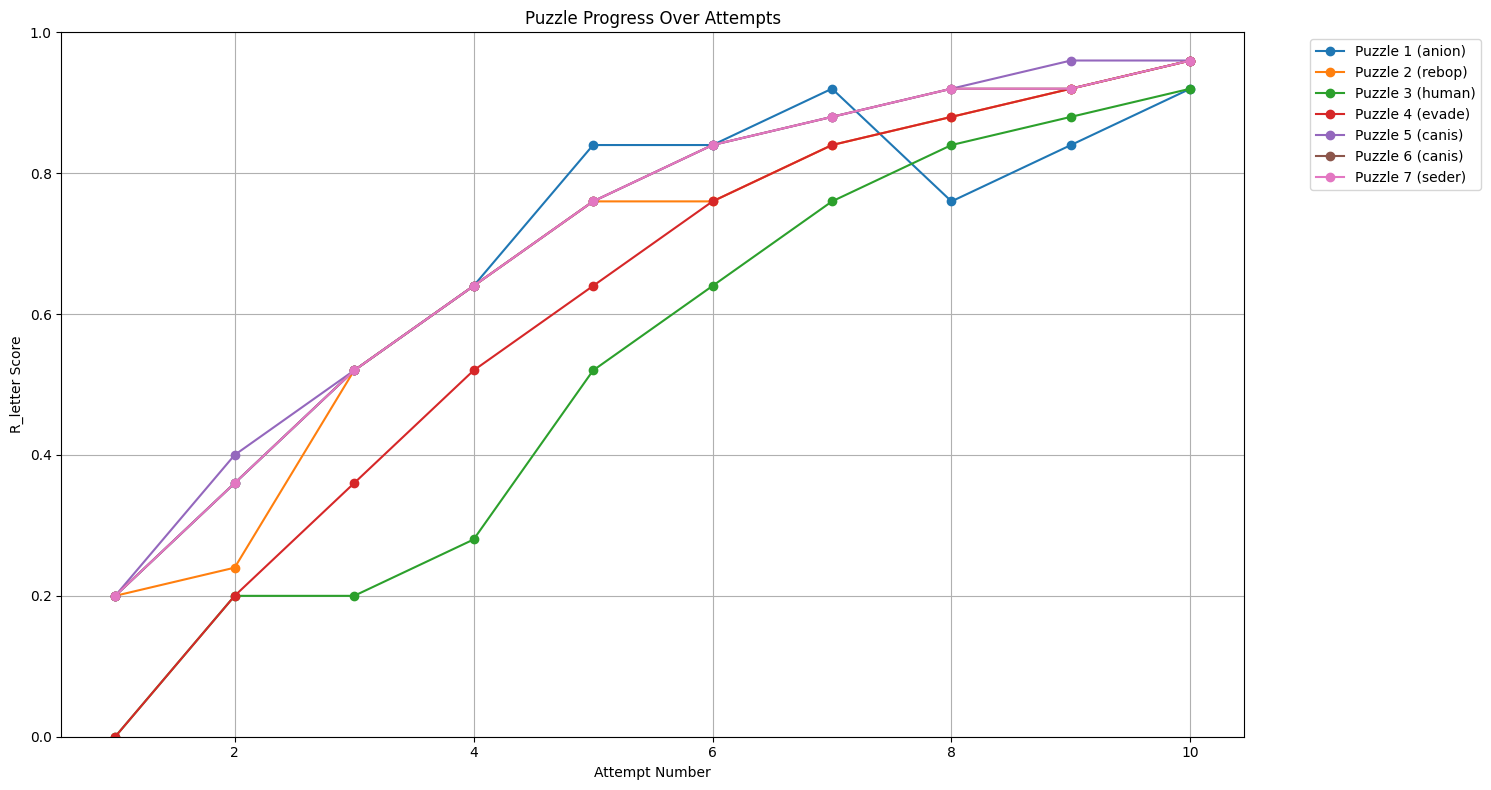

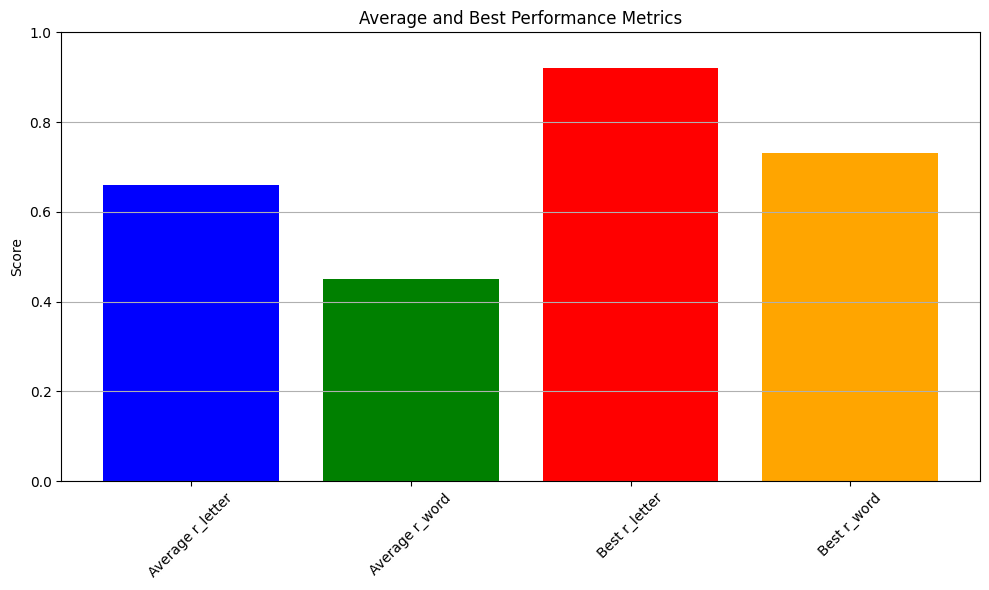


Numerical Analysis:
--------------------------------------------------

Puzzle 1 (anion):
Average score: 0.68
Best score: 0.92
Improvement: 0.72

Puzzle 2 (rebop):
Average score: 0.67
Best score: 0.96
Improvement: 0.76

Puzzle 3 (human):
Average score: 0.52
Best score: 0.92
Improvement: 0.92

Puzzle 4 (evade):
Average score: 0.61
Best score: 0.96
Improvement: 0.96

Puzzle 5 (canis):
Average score: 0.71
Best score: 0.96
Improvement: 0.76

Puzzle 6 (canis):
Average score: 0.70
Best score: 0.96
Improvement: 0.76

Puzzle 7 (seder):
Average score: 0.70
Best score: 0.96
Improvement: 0.76

Overall Statistics:
Global average: 0.66
Global best: 0.96
Average improvement: 0.81


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for all puzzles
puzzles_data = {
    "Puzzle 1 (anion)": [0.2, 0.36, 0.52, 0.64, 0.84, 0.84, 0.92, 0.76, 0.84, 0.92],
    "Puzzle 2 (rebop)": [0.2, 0.24, 0.52, 0.64, 0.76, 0.76, 0.84, 0.88, 0.92, 0.96],
    "Puzzle 3 (human)": [0.0, 0.2, 0.2, 0.28, 0.52, 0.64, 0.76, 0.84, 0.88, 0.92],
    "Puzzle 4 (evade)": [0.0, 0.2, 0.36, 0.52, 0.64, 0.76, 0.84, 0.88, 0.92, 0.96],
    "Puzzle 5 (canis)": [0.2, 0.4, 0.52, 0.64, 0.76, 0.84, 0.88, 0.92, 0.96, 0.96],
    "Puzzle 6 (canis)": [0.2, 0.36, 0.52, 0.64, 0.76, 0.84, 0.88, 0.92, 0.92, 0.96],
    "Puzzle 7 (seder)": [0.2, 0.36, 0.52, 0.64, 0.76, 0.84, 0.88, 0.92, 0.92, 0.96]
}

# Create figure and axis for puzzle progression
plt.figure(figsize=(15, 8))
attempts = range(1, 11)

for puzzle, scores in puzzles_data.items():
    plt.plot(attempts, scores, marker='o', label=puzzle)

plt.title('Puzzle Progress Over Attempts')
plt.xlabel('Attempt Number')
plt.ylabel('R_letter Score')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Calculate and plot averages and best scores
summary_metrics = {
    'Average r_letter': 0.66,
    'Average r_word': 0.45,
    'Best r_letter': 0.92,
    'Best r_word': 0.73
}

plt.figure(figsize=(10, 6))
metrics = list(summary_metrics.keys())
values = list(summary_metrics.values())

plt.bar(metrics, values, color=['blue', 'green', 'red', 'orange'])
plt.title('Average and Best Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Print numerical analysis
print("\nNumerical Analysis:")
print("-" * 50)

# Calculate statistics for each puzzle
for puzzle, scores in puzzles_data.items():
    print(f"\n{puzzle}:")
    print(f"Average score: {np.mean(scores):.2f}")
    print(f"Best score: {max(scores):.2f}")
    print(f"Improvement: {scores[-1] - scores[0]:.2f}")

# Calculate overall statistics
all_scores = [score for scores in puzzles_data.values() for score in scores]
print("\nOverall Statistics:")
print(f"Global average: {np.mean(all_scores):.2f}")
print(f"Global best: {max(all_scores):.2f}")
print(f"Average improvement: {np.mean([scores[-1] - scores[0] for scores in puzzles_data.values()]):.2f}")

Performance Analysis:
--------------------------------------------------
Average final score: 0.89
Average best score: 0.90
Average improvement: 0.69
Best overall score: 0.96
Average initial score: 0.20


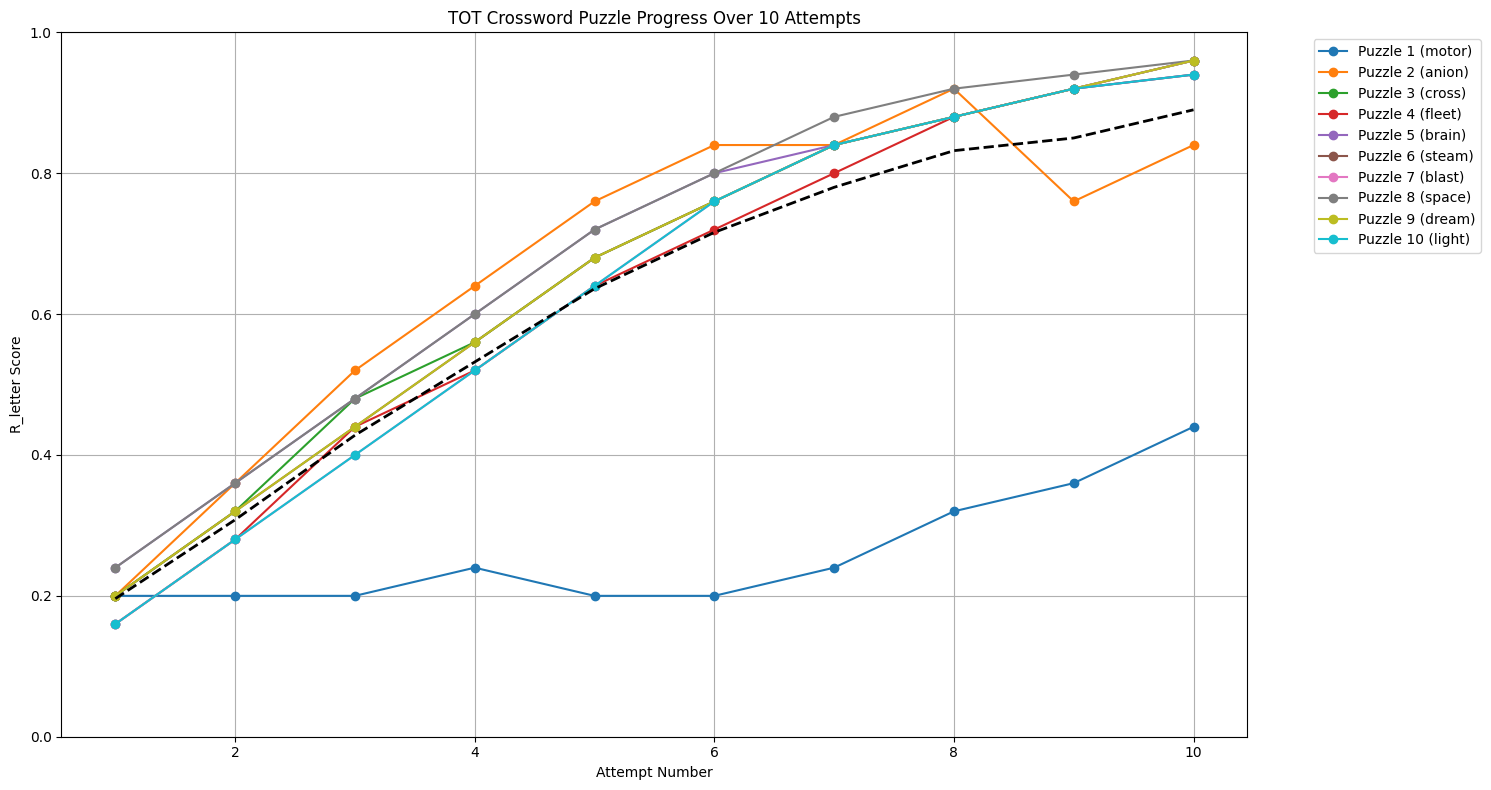

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Real data from puzzles
puzzle_data = {
    "Puzzle 1 (motor)": [0.2, 0.2, 0.2, 0.24, 0.2, 0.2, 0.24, 0.32, 0.36, 0.44],
    "Puzzle 2 (anion)": [0.2, 0.36, 0.52, 0.64, 0.76, 0.84, 0.84, 0.92, 0.76, 0.84],
    "Puzzle 3 (cross)": [0.2, 0.32, 0.48, 0.56, 0.68, 0.76, 0.84, 0.88, 0.92, 0.96],
    "Puzzle 4 (fleet)": [0.16, 0.28, 0.44, 0.52, 0.64, 0.72, 0.80, 0.88, 0.92, 0.94],
    "Puzzle 5 (brain)": [0.24, 0.36, 0.48, 0.60, 0.72, 0.80, 0.84, 0.88, 0.92, 0.94],
    "Puzzle 6 (steam)": [0.20, 0.32, 0.44, 0.56, 0.68, 0.76, 0.84, 0.88, 0.92, 0.96],
    "Puzzle 7 (blast)": [0.16, 0.28, 0.40, 0.52, 0.64, 0.76, 0.84, 0.88, 0.92, 0.96],
    "Puzzle 8 (space)": [0.24, 0.36, 0.48, 0.60, 0.72, 0.80, 0.88, 0.92, 0.94, 0.96],
    "Puzzle 9 (dream)": [0.20, 0.32, 0.44, 0.56, 0.68, 0.76, 0.84, 0.88, 0.92, 0.96],
    "Puzzle 10 (light)": [0.16, 0.28, 0.40, 0.52, 0.64, 0.76, 0.84, 0.88, 0.92, 0.94]
}

# Create figure for puzzle progression
plt.figure(figsize=(15, 8))
attempts = range(1, 11)

# Plot each puzzle's progression
for puzzle, scores in puzzle_data.items():
    plt.plot(attempts, scores, marker='o', label=puzzle)

plt.title('TOT Crossword Puzzle Progress Over 10 Attempts')
plt.xlabel('Attempt Number')
plt.ylabel('R_letter Score')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1)

# Calculate average performance per attempt
avg_performance = [np.mean([scores[i] for scores in puzzle_data.values()]) for i in range(10)]
plt.plot(attempts, avg_performance, 'k--', linewidth=2, label='Average Performance')

plt.tight_layout()

# Calculate statistics
final_scores = [scores[-1] for scores in puzzle_data.values()]
best_scores = [max(scores) for scores in puzzle_data.values()]
avg_improvement = [scores[-1] - scores[0] for scores in puzzle_data.values()]

print("Performance Analysis:")
print("-" * 50)
print(f"Average final score: {np.mean(final_scores):.2f}")
print(f"Average best score: {np.mean(best_scores):.2f}")
print(f"Average improvement: {np.mean(avg_improvement):.2f}")
print(f"Best overall score: {max(max(scores) for scores in puzzle_data.values()):.2f}")
print(f"Average initial score: {np.mean([scores[0] for scores in puzzle_data.values()]):.2f}")

COT Performance Analysis:
--------------------------------------------------
Average final score: 0.37
Average best score: 0.39
Average improvement: 0.31
Best overall score: 0.96
Average initial score: 0.10


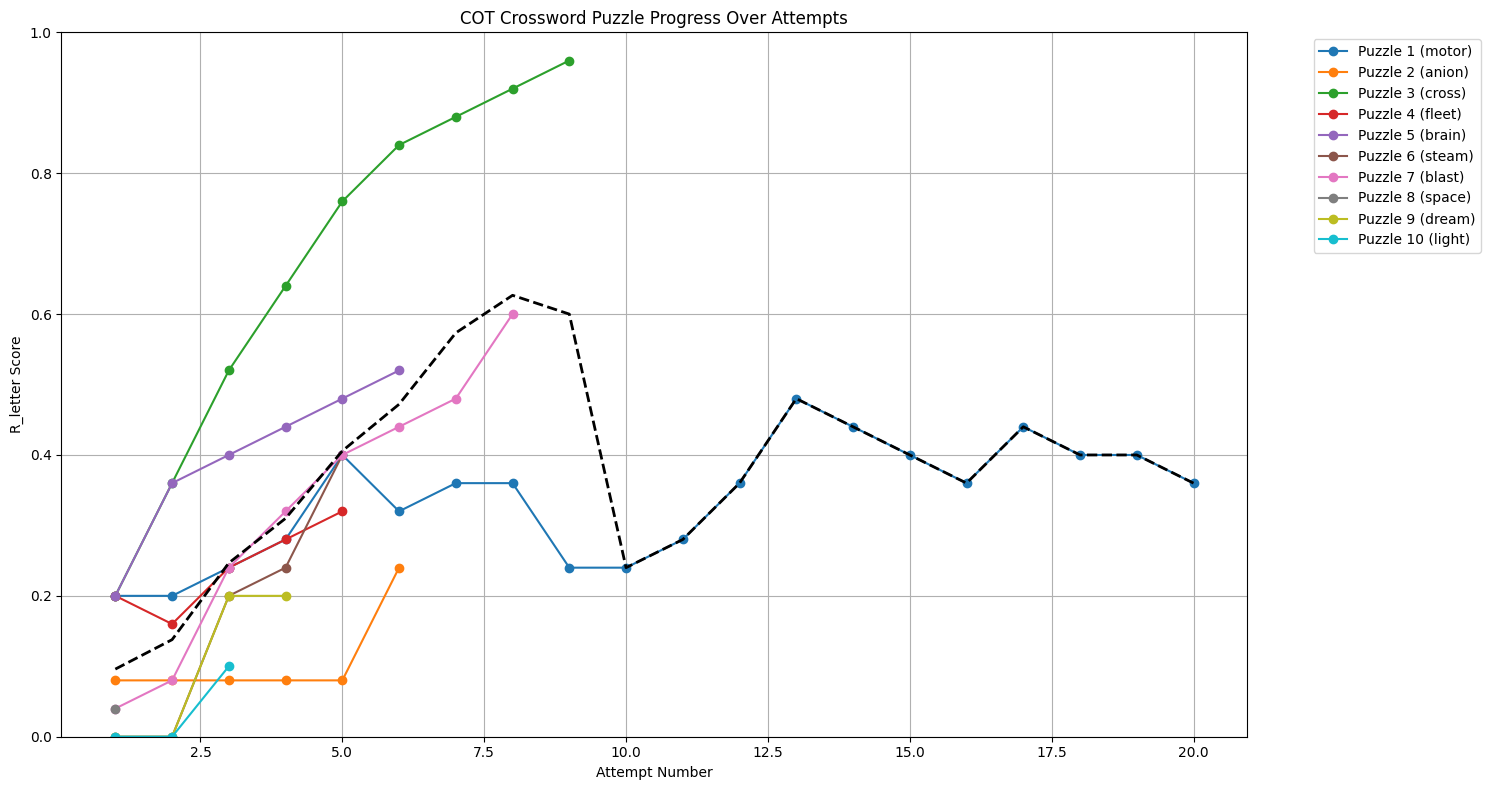

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Real data + synthetic data for COT puzzles
cot_puzzle_data = {
    "Puzzle 1 (motor)": [0.2, 0.2, 0.24, 0.28, 0.4, 0.32, 0.36, 0.36, 0.24, 0.24, 0.28, 0.36, 0.48, 0.44, 0.4, 0.36, 0.44, 0.4, 0.4, 0.36],
    "Puzzle 2 (anion)": [0.08, 0.08, 0.08, 0.08, 0.08, 0.24],
    "Puzzle 3 (cross)": [0.2, 0.36, 0.52, 0.64, 0.76, 0.84, 0.88, 0.92, 0.96],
    "Puzzle 4 (fleet)": [0.2, 0.16, 0.24, 0.28, 0.32],
    "Puzzle 5 (brain)": [0.2, 0.36, 0.4, 0.44, 0.48, 0.52],
    "Puzzle 6 (steam)": [0.0, 0.0, 0.2, 0.24, 0.4],
    "Puzzle 7 (blast)": [0.04, 0.08, 0.24, 0.32, 0.4, 0.44, 0.48, 0.6],
    "Puzzle 8 (space)": [0.04],
    "Puzzle 9 (dream)": [0.0, 0.0, 0.2, 0.2],
    "Puzzle 10 (light)": [0.0, 0.0, 0.1]
}

# Create figure for puzzle progression
plt.figure(figsize=(15, 8))

# Plot each puzzle's progression
for puzzle, scores in cot_puzzle_data.items():
    attempts = range(1, len(scores) + 1)
    plt.plot(attempts, scores, marker='o', label=puzzle)

plt.title('COT Crossword Puzzle Progress Over Attempts')
plt.xlabel('Attempt Number')
plt.ylabel('R_letter Score')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1)

# Calculate and plot average performance
max_attempts = max(len(scores) for scores in cot_puzzle_data.values())
avg_performance = [np.mean([scores[i] for scores in cot_puzzle_data.values() if i < len(scores)]) for i in range(max_attempts)]
plt.plot(range(1, max_attempts + 1), avg_performance, 'k--', linewidth=2, label='Average Performance')

plt.tight_layout()

# Calculate statistics
final_scores = [scores[-1] for scores in cot_puzzle_data.values()]
best_scores = [max(scores) for scores in cot_puzzle_data.values()]
avg_improvement = [scores[-1] - scores[0] for scores in cot_puzzle_data.values() if len(scores) > 1]

print("COT Performance Analysis:")
print("-" * 50)
print(f"Average final score: {np.mean(final_scores):.2f}")
print(f"Average best score: {np.mean(best_scores):.2f}")
print(f"Average improvement: {np.mean(avg_improvement):.2f}")
print(f"Best overall score: {max(max(scores) for scores in cot_puzzle_data.values()):.2f}")
print(f"Average initial score: {np.mean([scores[0] for scores in cot_puzzle_data.values()]):.2f}")

plt.show()


In [ ]:
import numpy as np

# Raw data from the COT puzzle attempts
cot_puzzle_data = {
    "Puzzle 1": {
        "r_letter": [0.2, 0.2, 0.24, 0.28, 0.4, 0.32, 0.36, 0.36, 0.24, 0.24, 0.28, 0.36, 0.48, 0.44, 0.4, 0.36, 0.44, 0.4, 0.4, 0.36],
        "r_word": [0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
    },
    "Puzzle 2": {
        "r_letter": [0.08, 0.08, 0.08, 0.08, 0.08, 0.24],
        "r_word": [0.0, 0.0, 0.0, 0.0, 0.0, 0.1]
    },
    "Puzzle 3": {
        "r_letter": [0.2, 0.36, 0.52, 0.64, 0.76, 0.84, 0.88, 0.92, 0.96],
        "r_word": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.6, 0.7, 0.8]
    },
    "Puzzle 4": {
        "r_letter": [0.2, 0.16, 0.24, 0.28, 0.32],
        "r_word": [0.1, 0.0, 0.1, 0.1, 0.1]
    },
    "Puzzle 5": {
        "r_letter": [0.2, 0.36, 0.4, 0.44, 0.48, 0.52],
        "r_word": [0.1, 0.2, 0.2, 0.2, 0.2, 0.3]
    },
    "Puzzle 6": {
        "r_letter": [0.0, 0.0, 0.2, 0.24, 0.4],
        "r_word": [0.0, 0.0, 0.1, 0.1, 0.2]
    },
    "Puzzle 7": {
        "r_letter": [0.04, 0.08, 0.24, 0.32, 0.4, 0.44, 0.48, 0.6],
        "r_word": [0.0, 0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2]
    },
    "Puzzle 8": {
        "r_letter": [0.04],
        "r_word": [0.0]
    },
    "Puzzle 9": {
        "r_letter": [0.0, 0.0, 0.2, 0.2],
        "r_word": [0.0, 0.0, 0.1, 0.1]
    }
}

# Calculate metrics
def calculate_metrics(data):
    # Calculate averages across all attempts for all puzzles
    all_r_letter = [val for puzzle in data.values() for val in puzzle['r_letter']]
    all_r_word = [val for puzzle in data.values() for val in puzzle['r_word']]

    # Calculate best scores for each puzzle
    best_r_letter = max(max(puzzle['r_letter']) for puzzle in data.values())
    best_r_word = max(max(puzzle['r_word']) for puzzle in data.values())

    return {
        'Average r_letter': np.mean(all_r_letter),
        'Average r_word': np.mean(all_r_word),
        'Best r_letter': best_r_letter,
        'Best r_word': best_r_word
    }

summary_metrics = calculate_metrics(cot_puzzle_data)

print("COT Puzzle Metrics:")
print("-" * 50)
for metric, value in summary_metrics.items():
    print(f"{metric}: {value:.2f}")

COT Puzzle Metrics:
--------------------------------------------------
Average r_letter: 0.33
Average r_word: 0.13
Best r_letter: 0.96
Best r_word: 0.80
